In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle
import numpy as np
import functools
import sys
from tqdm import tqdm, trange
from aemulusnu_mf_lib.utils import *
from aemulusnu_massfunction.emulator_training import *

from classy import Class

import math
import torch
import gpytorch
from matplotlib import pyplot as plt

import pyccl as ccl


In [3]:

cosmos_f = open('../data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

a_list_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alist.pkl'
a_list_f = open(a_list_fname, 'rb')
a_list = pickle.load(a_list_f)
a_list_f.close()

In [4]:
weird_boxes = []


errors = {a:{} for a in a_list}
X = []
Y = []
z_to_a = {}
a_to_z = {}
kt = np.logspace(-3, 1, 100) # h/Mpc
for box in tqdm(cosmo_params):
    if(box in weird_boxes):
        continue
    curr_cosmo = cosmo_params[box]
    if(box == 'Box_n50_0_1400'):
        print(curr_cosmo)

    curr_cosmo_values = [curr_cosmo[curr_key] for curr_key in key_ordering]

    h = curr_cosmo['H0']/100

    Ωb =  curr_cosmo['ombh2'] / h**2
    Ωc =  curr_cosmo['omch2'] / h**2

    cosmo = ccl.Cosmology(Omega_c=Ωc,
                          Omega_b=Ωb,
                          h=h,
                          A_s=curr_cosmo['10^9 As']*10**(-9),
                          n_s=curr_cosmo['ns'],
                          w0=curr_cosmo['w0'],
                          m_nu=[curr_cosmo['nu_mass_ev']/3, curr_cosmo['nu_mass_ev']/3, curr_cosmo['nu_mass_ev']/3])


    try:
        with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_params.pkl"%(box), "rb") as f:
            MLE_params = pickle.load(f)
            param_values = list(MLE_params.values())
            Y+= [param_values]
            X+= [curr_cosmo_values]
    except:
        print(box, z)
    for a in a_list:
        z = scaleToRedshift(a)
        z_to_a[z] = a
        a_to_z[a] = z

100%|██████████| 150/150 [00:00<00:00, 1064.48it/s]

{'ns': 0.97000003, 'H0': 67.0, 'w0': -1.0, 'ombh2': 0.0223, 'omch2': 0.12, 'nu_mass_ev': 0.07071068, '10^9 As': 2.10100315}


In [5]:
X = np.array(X)
Y = np.array(Y)

print(X.shape)
print(Y.shape)
################################
print('scaling input')
in_scaler = Normalizer()
in_scaler.fit(X)
X = in_scaler.transform(X)
print(X.shape)


print('scaling output')
out_scaler = Standardizer()
out_scaler.fit(Y)
Y = out_scaler.transform(Y)
print(Y.shape)

##REMEMBER TO UNSCALE OUTPUT AND SAVE SCALERS#####

X_train = torch.from_numpy(X).float()
Y_train = torch.from_numpy(Y).float()
n_tasks = len(Y_train[0])

(150, 7)
(150, 8)
scaling input
(150, 7)
scaling output
(150, 8)


In [6]:

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks,
                                                              has_global_noise=False, 
                                                              has_task_noise=True)
model = MultitaskGPModel(X_train, Y_train, likelihood)


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()


training_iterations = 3000

In [7]:
epochs_iter = tqdm(range(training_iterations), desc="Iteration")


# Create the optimizer with the initial learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, amsgrad=True)  # Includes GaussianLikelihood parameters

for i in epochs_iter:
    # Training step
    model.train()
    likelihood.train()

    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Y_train)
    epochs_iter.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()
    print('Iter %d/%d - Loss: %.4f' % (i + 1, training_iterations, loss.item()))

    # Change learning rate after half of iterations
#     if i == 250:
#         lr = 0.01
#         print('reducing lr to 0.01')
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = lr

#     if i == 150:
#         lr = 0.01
#         print('reducing lr to 0.01')
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = lr
#-.926

Iteration:   0%|          | 4/3000 [00:01<11:33,  4.32it/s, loss=6.72]

Iter 1/3000 - Loss: 6.8419
Iter 2/3000 - Loss: 6.8118
Iter 3/3000 - Loss: 6.7816
Iter 4/3000 - Loss: 6.7513
Iter 5/3000 - Loss: 6.7210


Iteration:   0%|          | 11/3000 [00:01<04:00, 12.43it/s, loss=6.54]

Iter 6/3000 - Loss: 6.6905
Iter 7/3000 - Loss: 6.6599
Iter 8/3000 - Loss: 6.6293
Iter 9/3000 - Loss: 6.5985
Iter 10/3000 - Loss: 6.5676
Iter 11/3000 - Loss: 6.5367


Iteration:   0%|          | 14/3000 [00:01<03:23, 14.71it/s, loss=6.38]

Iter 12/3000 - Loss: 6.5056
Iter 13/3000 - Loss: 6.4743
Iter 14/3000 - Loss: 6.4430
Iter 15/3000 - Loss: 6.4116
Iter 16/3000 - Loss: 6.3800


Iteration:   1%|          | 20/3000 [00:01<02:41, 18.48it/s, loss=6.19]

Iter 17/3000 - Loss: 6.3483
Iter 18/3000 - Loss: 6.3165
Iter 19/3000 - Loss: 6.2845
Iter 20/3000 - Loss: 6.2524
Iter 21/3000 - Loss: 6.2202


Iteration:   1%|          | 26/3000 [00:02<02:17, 21.67it/s, loss=6.02]

Iter 22/3000 - Loss: 6.1878
Iter 23/3000 - Loss: 6.1552
Iter 24/3000 - Loss: 6.1225
Iter 25/3000 - Loss: 6.0897
Iter 26/3000 - Loss: 6.0567
Iter 27/3000 - Loss: 6.0235


Iteration:   1%|          | 34/3000 [00:02<01:46, 27.91it/s, loss=5.75]

Iter 28/3000 - Loss: 5.9902
Iter 29/3000 - Loss: 5.9566
Iter 30/3000 - Loss: 5.9229
Iter 31/3000 - Loss: 5.8890
Iter 32/3000 - Loss: 5.8549
Iter 33/3000 - Loss: 5.8206
Iter 34/3000 - Loss: 5.7861


Iteration:   1%|▏         | 40/3000 [00:02<01:49, 27.03it/s, loss=5.57]

Iter 35/3000 - Loss: 5.7514
Iter 36/3000 - Loss: 5.7165
Iter 37/3000 - Loss: 5.6813
Iter 38/3000 - Loss: 5.6459
Iter 39/3000 - Loss: 5.6103
Iter 40/3000 - Loss: 5.5744


Iteration:   2%|▏         | 46/3000 [00:02<01:45, 28.08it/s, loss=5.32]

Iter 41/3000 - Loss: 5.5383
Iter 42/3000 - Loss: 5.5019
Iter 43/3000 - Loss: 5.4652
Iter 44/3000 - Loss: 5.4282
Iter 45/3000 - Loss: 5.3910
Iter 46/3000 - Loss: 5.3534
Iter 47/3000 - Loss: 5.3156


Iteration:   2%|▏         | 52/3000 [00:02<01:57, 25.13it/s, loss=5.08]

Iter 48/3000 - Loss: 5.2774
Iter 49/3000 - Loss: 5.2389
Iter 50/3000 - Loss: 5.2000
Iter 51/3000 - Loss: 5.1608
Iter 52/3000 - Loss: 5.1212


Iteration:   2%|▏         | 56/3000 [00:03<01:50, 26.61it/s, loss=4.83]

Iter 53/3000 - Loss: 5.0812
Iter 54/3000 - Loss: 5.0409
Iter 55/3000 - Loss: 5.0002
Iter 56/3000 - Loss: 4.9590
Iter 57/3000 - Loss: 4.9175
Iter 58/3000 - Loss: 4.8755


Iteration:   2%|▏         | 63/3000 [00:03<01:55, 25.42it/s, loss=4.66]

Iter 59/3000 - Loss: 4.8330
Iter 60/3000 - Loss: 4.7901
Iter 61/3000 - Loss: 4.7467
Iter 62/3000 - Loss: 4.7029
Iter 63/3000 - Loss: 4.6586


Iteration:   2%|▏         | 67/3000 [00:03<01:46, 27.42it/s, loss=4.28]

Iter 64/3000 - Loss: 4.6137
Iter 65/3000 - Loss: 4.5684
Iter 66/3000 - Loss: 4.5225
Iter 67/3000 - Loss: 4.4761
Iter 68/3000 - Loss: 4.4291
Iter 69/3000 - Loss: 4.3816
Iter 70/3000 - Loss: 4.3335


Iteration:   2%|▎         | 75/3000 [00:03<01:37, 30.15it/s, loss=3.98]

Iter 71/3000 - Loss: 4.2848
Iter 72/3000 - Loss: 4.2356
Iter 73/3000 - Loss: 4.1858
Iter 74/3000 - Loss: 4.1353
Iter 75/3000 - Loss: 4.0843
Iter 76/3000 - Loss: 4.0327
Iter 77/3000 - Loss: 3.9805


Iteration:   3%|▎         | 79/3000 [00:03<01:41, 28.90it/s, loss=3.77]

Iter 78/3000 - Loss: 3.9277
Iter 79/3000 - Loss: 3.8743
Iter 80/3000 - Loss: 3.8203
Iter 81/3000 - Loss: 3.7657


Iteration:   3%|▎         | 82/3000 [00:04<05:18,  9.17it/s, loss=3.71]

Iter 82/3000 - Loss: 3.7106


Iteration:   3%|▎         | 85/3000 [00:05<05:38,  8.61it/s, loss=3.54]

Iter 83/3000 - Loss: 3.6549
Iter 84/3000 - Loss: 3.5986
Iter 85/3000 - Loss: 3.5418


Iteration:   3%|▎         | 87/3000 [00:05<05:23,  9.00it/s, loss=3.43]

Iter 86/3000 - Loss: 3.4846
Iter 87/3000 - Loss: 3.4268


Iteration:   3%|▎         | 91/3000 [00:05<04:36, 10.51it/s, loss=3.07]

Iter 88/3000 - Loss: 3.3686
Iter 89/3000 - Loss: 3.3100
Iter 90/3000 - Loss: 3.2511
Iter 91/3000 - Loss: 3.1918
Iter 92/3000 - Loss: 3.1322
Iter 93/3000 - Loss: 3.0724


Iteration:   3%|▎         | 98/3000 [00:06<02:51, 16.91it/s, loss=2.71]

Iter 94/3000 - Loss: 3.0125
Iter 95/3000 - Loss: 2.9524
Iter 96/3000 - Loss: 2.8923
Iter 97/3000 - Loss: 2.8323
Iter 98/3000 - Loss: 2.7723
Iter 99/3000 - Loss: 2.7125


Iteration:   3%|▎         | 101/3000 [00:06<02:35, 18.62it/s, loss=2.48]

Iter 100/3000 - Loss: 2.6530
Iter 101/3000 - Loss: 2.5939
Iter 102/3000 - Loss: 2.5352
Iter 103/3000 - Loss: 2.4770


Iteration:   4%|▎         | 107/3000 [00:06<02:28, 19.46it/s, loss=2.2] 

Iter 104/3000 - Loss: 2.4195
Iter 105/3000 - Loss: 2.3626
Iter 106/3000 - Loss: 2.3066
Iter 107/3000 - Loss: 2.2515
Iter 108/3000 - Loss: 2.1974


Iteration:   4%|▍         | 114/3000 [00:06<02:03, 23.44it/s, loss=1.85]

Iter 109/3000 - Loss: 2.1444
Iter 110/3000 - Loss: 2.0926
Iter 111/3000 - Loss: 2.0421
Iter 112/3000 - Loss: 1.9929
Iter 113/3000 - Loss: 1.9451
Iter 114/3000 - Loss: 1.8988
Iter 115/3000 - Loss: 1.8541


Iteration:   4%|▍         | 122/3000 [00:06<01:46, 27.07it/s, loss=1.59]

Iter 116/3000 - Loss: 1.8109
Iter 117/3000 - Loss: 1.7694
Iter 118/3000 - Loss: 1.7295
Iter 119/3000 - Loss: 1.6913
Iter 120/3000 - Loss: 1.6548
Iter 121/3000 - Loss: 1.6199
Iter 122/3000 - Loss: 1.5867


Iteration:   4%|▍         | 126/3000 [00:07<01:44, 27.42it/s, loss=1.44]

Iter 123/3000 - Loss: 1.5552
Iter 124/3000 - Loss: 1.5252
Iter 125/3000 - Loss: 1.4968
Iter 126/3000 - Loss: 1.4698
Iter 127/3000 - Loss: 1.4443


Iteration:   4%|▍         | 133/3000 [00:07<01:41, 28.28it/s, loss=1.28]

Iter 128/3000 - Loss: 1.4201
Iter 129/3000 - Loss: 1.3973
Iter 130/3000 - Loss: 1.3757
Iter 131/3000 - Loss: 1.3554
Iter 132/3000 - Loss: 1.3361
Iter 133/3000 - Loss: 1.3180
Iter 134/3000 - Loss: 1.3009


Iteration:   5%|▍         | 141/3000 [00:07<01:29, 31.93it/s, loss=1.2] 

Iter 135/3000 - Loss: 1.2847
Iter 136/3000 - Loss: 1.2695
Iter 137/3000 - Loss: 1.2552
Iter 138/3000 - Loss: 1.2417
Iter 139/3000 - Loss: 1.2290
Iter 140/3000 - Loss: 1.2171
Iter 141/3000 - Loss: 1.2059
Iter 142/3000 - Loss: 1.1954


Iteration:   5%|▍         | 145/3000 [00:07<01:34, 30.19it/s, loss=1.14]

Iter 143/3000 - Loss: 1.1856
Iter 144/3000 - Loss: 1.1764
Iter 145/3000 - Loss: 1.1677
Iter 146/3000 - Loss: 1.1596
Iter 147/3000 - Loss: 1.1519


Iteration:   5%|▌         | 153/3000 [00:08<01:30, 31.30it/s, loss=1.1] 

Iter 148/3000 - Loss: 1.1447
Iter 149/3000 - Loss: 1.1379
Iter 150/3000 - Loss: 1.1314
Iter 151/3000 - Loss: 1.1253
Iter 152/3000 - Loss: 1.1195
Iter 153/3000 - Loss: 1.1140
Iter 154/3000 - Loss: 1.1087
Iter 155/3000 - Loss: 1.1037


Iteration:   5%|▌         | 157/3000 [00:08<01:37, 29.21it/s, loss=1.09]

Iter 156/3000 - Loss: 1.0989
Iter 157/3000 - Loss: 1.0943


Iteration:   5%|▌         | 160/3000 [00:09<05:47,  8.18it/s, loss=1.08]

Iter 158/3000 - Loss: 1.0900
Iter 159/3000 - Loss: 1.0858
Iter 160/3000 - Loss: 1.0818


Iteration:   5%|▌         | 163/3000 [00:09<05:03,  9.36it/s, loss=1.06]

Iter 161/3000 - Loss: 1.0780
Iter 162/3000 - Loss: 1.0743
Iter 163/3000 - Loss: 1.0708
Iter 164/3000 - Loss: 1.0675
Iter 165/3000 - Loss: 1.0643


Iteration:   6%|▌         | 170/3000 [00:09<03:19, 14.17it/s, loss=1.05]

Iter 166/3000 - Loss: 1.0612
Iter 167/3000 - Loss: 1.0583
Iter 168/3000 - Loss: 1.0554
Iter 169/3000 - Loss: 1.0527
Iter 170/3000 - Loss: 1.0501
Iter 171/3000 - Loss: 1.0476


Iteration:   6%|▌         | 178/3000 [00:09<02:13, 21.16it/s, loss=1.03]

Iter 172/3000 - Loss: 1.0452
Iter 173/3000 - Loss: 1.0429
Iter 174/3000 - Loss: 1.0406
Iter 175/3000 - Loss: 1.0385
Iter 176/3000 - Loss: 1.0364
Iter 177/3000 - Loss: 1.0344
Iter 178/3000 - Loss: 1.0325
Iter 179/3000 - Loss: 1.0307


Iteration:   6%|▌         | 182/3000 [00:10<01:54, 24.65it/s, loss=1.02]

Iter 180/3000 - Loss: 1.0289
Iter 181/3000 - Loss: 1.0271
Iter 182/3000 - Loss: 1.0254
Iter 183/3000 - Loss: 1.0238
Iter 184/3000 - Loss: 1.0223
Iter 185/3000 - Loss: 1.0207


Iteration:   6%|▋         | 190/3000 [00:10<01:52, 24.98it/s, loss=1.01]

Iter 186/3000 - Loss: 1.0192
Iter 187/3000 - Loss: 1.0178
Iter 188/3000 - Loss: 1.0164
Iter 189/3000 - Loss: 1.0150
Iter 190/3000 - Loss: 1.0137


Iteration:   6%|▋         | 193/3000 [00:10<02:03, 22.69it/s, loss=1.01]

Iter 191/3000 - Loss: 1.0124
Iter 192/3000 - Loss: 1.0111
Iter 193/3000 - Loss: 1.0099
Iter 194/3000 - Loss: 1.0087
Iter 195/3000 - Loss: 1.0076


Iteration:   7%|▋         | 199/3000 [00:10<02:09, 21.63it/s, loss=1]   

Iter 196/3000 - Loss: 1.0064
Iter 197/3000 - Loss: 1.0053
Iter 198/3000 - Loss: 1.0042
Iter 199/3000 - Loss: 1.0032
Iter 200/3000 - Loss: 1.0021


Iteration:   7%|▋         | 207/3000 [00:11<01:44, 26.83it/s, loss=0.995]

Iter 201/3000 - Loss: 1.0011
Iter 202/3000 - Loss: 1.0001
Iter 203/3000 - Loss: 0.9991
Iter 204/3000 - Loss: 0.9982
Iter 205/3000 - Loss: 0.9973
Iter 206/3000 - Loss: 0.9963
Iter 207/3000 - Loss: 0.9955


Iteration:   7%|▋         | 213/3000 [00:11<01:42, 27.27it/s, loss=0.99] 

Iter 208/3000 - Loss: 0.9946
Iter 209/3000 - Loss: 0.9937
Iter 210/3000 - Loss: 0.9929
Iter 211/3000 - Loss: 0.9921
Iter 212/3000 - Loss: 0.9912
Iter 213/3000 - Loss: 0.9904


Iteration:   7%|▋         | 216/3000 [00:11<01:41, 27.46it/s, loss=0.986]

Iter 214/3000 - Loss: 0.9897
Iter 215/3000 - Loss: 0.9889
Iter 216/3000 - Loss: 0.9881
Iter 217/3000 - Loss: 0.9874
Iter 218/3000 - Loss: 0.9867
Iter 219/3000 - Loss: 0.9860


Iteration:   7%|▋         | 223/3000 [00:11<01:44, 26.69it/s, loss=0.982]

Iter 220/3000 - Loss: 0.9852
Iter 221/3000 - Loss: 0.9846
Iter 222/3000 - Loss: 0.9839
Iter 223/3000 - Loss: 0.9832
Iter 224/3000 - Loss: 0.9826
Iter 225/3000 - Loss: 0.9819


Iteration:   8%|▊         | 230/3000 [00:11<01:39, 27.79it/s, loss=0.978]

Iter 226/3000 - Loss: 0.9813
Iter 227/3000 - Loss: 0.9806
Iter 228/3000 - Loss: 0.9800
Iter 229/3000 - Loss: 0.9794
Iter 230/3000 - Loss: 0.9788
Iter 231/3000 - Loss: 0.9782


Iteration:   8%|▊         | 237/3000 [00:12<01:30, 30.43it/s, loss=0.974]

Iter 232/3000 - Loss: 0.9776
Iter 233/3000 - Loss: 0.9770
Iter 234/3000 - Loss: 0.9764
Iter 235/3000 - Loss: 0.9759
Iter 236/3000 - Loss: 0.9753
Iter 237/3000 - Loss: 0.9748
Iter 238/3000 - Loss: 0.9742


Iteration:   8%|▊         | 237/3000 [00:12<01:30, 30.43it/s, loss=0.974]

Iter 239/3000 - Loss: 0.9737


Iteration:   8%|▊         | 244/3000 [00:13<04:47,  9.59it/s, loss=0.971]

Iter 240/3000 - Loss: 0.9731
Iter 241/3000 - Loss: 0.9726
Iter 242/3000 - Loss: 0.9721
Iter 243/3000 - Loss: 0.9716
Iter 244/3000 - Loss: 0.9711


Iteration:   8%|▊         | 247/3000 [00:13<04:18, 10.65it/s, loss=0.969]

Iter 245/3000 - Loss: 0.9706
Iter 246/3000 - Loss: 0.9701
Iter 247/3000 - Loss: 0.9696
Iter 248/3000 - Loss: 0.9691
Iter 249/3000 - Loss: 0.9686


Iteration:   8%|▊         | 253/3000 [00:13<03:07, 14.61it/s, loss=0.966]

Iter 250/3000 - Loss: 0.9681
Iter 251/3000 - Loss: 0.9677
Iter 252/3000 - Loss: 0.9672
Iter 253/3000 - Loss: 0.9667


Iteration:   9%|▊         | 256/3000 [00:14<02:57, 15.42it/s, loss=0.964]

Iter 254/3000 - Loss: 0.9663
Iter 255/3000 - Loss: 0.9658
Iter 256/3000 - Loss: 0.9654
Iter 257/3000 - Loss: 0.9649
Iter 258/3000 - Loss: 0.9645
Iter 259/3000 - Loss: 0.9641


Iteration:   9%|▉         | 263/3000 [00:14<02:12, 20.72it/s, loss=0.962]

Iter 260/3000 - Loss: 0.9636
Iter 261/3000 - Loss: 0.9632
Iter 262/3000 - Loss: 0.9628
Iter 263/3000 - Loss: 0.9623
Iter 264/3000 - Loss: 0.9619
Iter 265/3000 - Loss: 0.9615


Iteration:   9%|▉         | 270/3000 [00:14<01:49, 24.96it/s, loss=0.959]

Iter 266/3000 - Loss: 0.9611
Iter 267/3000 - Loss: 0.9607
Iter 268/3000 - Loss: 0.9603
Iter 269/3000 - Loss: 0.9599
Iter 270/3000 - Loss: 0.9595
Iter 271/3000 - Loss: 0.9591


Iteration:   9%|▉         | 277/3000 [00:14<01:43, 26.38it/s, loss=0.957]

Iter 272/3000 - Loss: 0.9587
Iter 273/3000 - Loss: 0.9583
Iter 274/3000 - Loss: 0.9579
Iter 275/3000 - Loss: 0.9575
Iter 276/3000 - Loss: 0.9571
Iter 277/3000 - Loss: 0.9568


Iteration:   9%|▉         | 280/3000 [00:15<01:45, 25.67it/s, loss=0.955]

Iter 278/3000 - Loss: 0.9564
Iter 279/3000 - Loss: 0.9560
Iter 280/3000 - Loss: 0.9556
Iter 281/3000 - Loss: 0.9552
Iter 282/3000 - Loss: 0.9549


Iteration:  10%|▉         | 286/3000 [00:15<01:53, 23.85it/s, loss=0.953]

Iter 283/3000 - Loss: 0.9545
Iter 284/3000 - Loss: 0.9542
Iter 285/3000 - Loss: 0.9538
Iter 286/3000 - Loss: 0.9534
Iter 287/3000 - Loss: 0.9531
Iter 288/3000 - Loss: 0.9527


Iteration:  10%|▉         | 293/3000 [00:15<01:39, 27.15it/s, loss=0.95] 

Iter 289/3000 - Loss: 0.9524
Iter 290/3000 - Loss: 0.9520
Iter 291/3000 - Loss: 0.9517
Iter 292/3000 - Loss: 0.9513
Iter 293/3000 - Loss: 0.9509
Iter 294/3000 - Loss: 0.9506


Iteration:  10%|▉         | 299/3000 [00:15<01:38, 27.31it/s, loss=0.949]

Iter 295/3000 - Loss: 0.9502
Iter 296/3000 - Loss: 0.9499
Iter 297/3000 - Loss: 0.9496
Iter 298/3000 - Loss: 0.9492
Iter 299/3000 - Loss: 0.9489
Iter 300/3000 - Loss: 0.9486


Iteration:  10%|█         | 305/3000 [00:15<01:47, 25.00it/s, loss=0.947]

Iter 301/3000 - Loss: 0.9482
Iter 302/3000 - Loss: 0.9479
Iter 303/3000 - Loss: 0.9475
Iter 304/3000 - Loss: 0.9472
Iter 305/3000 - Loss: 0.9469


Iteration:  10%|█         | 309/3000 [00:16<01:37, 27.73it/s, loss=0.946]

Iter 306/3000 - Loss: 0.9466
Iter 307/3000 - Loss: 0.9462
Iter 308/3000 - Loss: 0.9459
Iter 309/3000 - Loss: 0.9456


Iteration:  10%|█         | 312/3000 [00:17<06:16,  7.13it/s, loss=0.945]

Iter 310/3000 - Loss: 0.9452
Iter 311/3000 - Loss: 0.9449
Iter 312/3000 - Loss: 0.9446


Iteration:  10%|█         | 312/3000 [00:17<06:16,  7.13it/s, loss=0.944]

Iter 313/3000 - Loss: 0.9443


Iteration:  10%|█         | 315/3000 [00:17<06:23,  7.00it/s, loss=0.943]

Iter 314/3000 - Loss: 0.9439
Iter 315/3000 - Loss: 0.9436
Iter 316/3000 - Loss: 0.9433
Iter 317/3000 - Loss: 0.9430


Iteration:  11%|█         | 320/3000 [00:18<04:35,  9.73it/s, loss=0.941]

Iter 318/3000 - Loss: 0.9427
Iter 319/3000 - Loss: 0.9423
Iter 320/3000 - Loss: 0.9420
Iter 321/3000 - Loss: 0.9417
Iter 322/3000 - Loss: 0.9414


Iteration:  11%|█         | 327/3000 [00:18<02:47, 15.93it/s, loss=0.94] 

Iter 323/3000 - Loss: 0.9411
Iter 324/3000 - Loss: 0.9408
Iter 325/3000 - Loss: 0.9404
Iter 326/3000 - Loss: 0.9401
Iter 327/3000 - Loss: 0.9398
Iter 328/3000 - Loss: 0.9395


Iteration:  11%|█         | 330/3000 [00:18<02:45, 16.15it/s, loss=0.938]

Iter 329/3000 - Loss: 0.9392
Iter 330/3000 - Loss: 0.9389
Iter 331/3000 - Loss: 0.9386
Iter 332/3000 - Loss: 0.9383


Iteration:  11%|█         | 336/3000 [00:18<02:17, 19.37it/s, loss=0.936]

Iter 333/3000 - Loss: 0.9380
Iter 334/3000 - Loss: 0.9377
Iter 335/3000 - Loss: 0.9374
Iter 336/3000 - Loss: 0.9370
Iter 337/3000 - Loss: 0.9367
Iter 338/3000 - Loss: 0.9364


Iteration:  11%|█▏        | 342/3000 [00:18<02:00, 22.09it/s, loss=0.934]

Iter 339/3000 - Loss: 0.9361
Iter 340/3000 - Loss: 0.9358
Iter 341/3000 - Loss: 0.9355
Iter 342/3000 - Loss: 0.9352
Iter 343/3000 - Loss: 0.9349
Iter 344/3000 - Loss: 0.9346
Iter 345/3000 - Loss: 0.9343


Iteration:  12%|█▏        | 349/3000 [00:19<01:44, 25.38it/s, loss=0.933]

Iter 346/3000 - Loss: 0.9340
Iter 347/3000 - Loss: 0.9337
Iter 348/3000 - Loss: 0.9334
Iter 349/3000 - Loss: 0.9331
Iter 350/3000 - Loss: 0.9328


Iteration:  12%|█▏        | 352/3000 [00:19<02:15, 19.58it/s, loss=0.932]

Iter 351/3000 - Loss: 0.9325
Iter 352/3000 - Loss: 0.9322
Iter 353/3000 - Loss: 0.9319


Iteration:  12%|█▏        | 352/3000 [00:19<02:15, 19.58it/s, loss=0.932]

Iter 354/3000 - Loss: 0.9316


Iteration:  12%|█▏        | 355/3000 [00:19<03:53, 11.33it/s, loss=0.931]

Iter 355/3000 - Loss: 0.9313
Iter 356/3000 - Loss: 0.9310
Iter 357/3000 - Loss: 0.9307


Iteration:  12%|█▏        | 360/3000 [00:21<07:16,  6.05it/s, loss=0.929]

Iter 358/3000 - Loss: 0.9304
Iter 359/3000 - Loss: 0.9301
Iter 360/3000 - Loss: 0.9298
Iter 361/3000 - Loss: 0.9295


Iteration:  12%|█▏        | 363/3000 [00:21<05:39,  7.77it/s, loss=0.928]

Iter 362/3000 - Loss: 0.9292
Iter 363/3000 - Loss: 0.9289
Iter 364/3000 - Loss: 0.9286


Iteration:  12%|█▏        | 368/3000 [00:21<03:57, 11.10it/s, loss=0.926]

Iter 365/3000 - Loss: 0.9283
Iter 366/3000 - Loss: 0.9280
Iter 367/3000 - Loss: 0.9277
Iter 368/3000 - Loss: 0.9274
Iter 369/3000 - Loss: 0.9271
Iter 370/3000 - Loss: 0.9268


Iteration:  12%|█▎        | 375/3000 [00:22<02:33, 17.06it/s, loss=0.925]

Iter 371/3000 - Loss: 0.9265
Iter 372/3000 - Loss: 0.9262
Iter 373/3000 - Loss: 0.9259
Iter 374/3000 - Loss: 0.9256
Iter 375/3000 - Loss: 0.9253
Iter 376/3000 - Loss: 0.9250


Iteration:  13%|█▎        | 381/3000 [00:22<02:15, 19.40it/s, loss=0.923]

Iter 377/3000 - Loss: 0.9247
Iter 378/3000 - Loss: 0.9244
Iter 379/3000 - Loss: 0.9241
Iter 380/3000 - Loss: 0.9238
Iter 381/3000 - Loss: 0.9235


Iteration:  13%|█▎        | 381/3000 [00:22<02:15, 19.40it/s, loss=0.923]

Iter 382/3000 - Loss: 0.9232
Iter 383/3000 - Loss: 0.9229


Iteration:  13%|█▎        | 386/3000 [00:22<02:54, 14.96it/s, loss=0.922]

Iter 384/3000 - Loss: 0.9226
Iter 385/3000 - Loss: 0.9223
Iter 386/3000 - Loss: 0.9220


Iteration:  13%|█▎        | 388/3000 [00:22<03:04, 14.15it/s, loss=0.921]

Iter 387/3000 - Loss: 0.9217
Iter 388/3000 - Loss: 0.9214
Iter 389/3000 - Loss: 0.9211


Iteration:  13%|█▎        | 394/3000 [00:23<02:23, 18.18it/s, loss=0.919]

Iter 390/3000 - Loss: 0.9208
Iter 391/3000 - Loss: 0.9205
Iter 392/3000 - Loss: 0.9202
Iter 393/3000 - Loss: 0.9199
Iter 394/3000 - Loss: 0.9196
Iter 395/3000 - Loss: 0.9193
Iter 396/3000 - Loss: 0.9190


Iteration:  13%|█▎        | 398/3000 [00:23<02:01, 21.45it/s, loss=0.918]

Iter 397/3000 - Loss: 0.9187
Iter 398/3000 - Loss: 0.9184


Iteration:  13%|█▎        | 401/3000 [00:23<02:52, 15.06it/s, loss=0.917]

Iter 399/3000 - Loss: 0.9181
Iter 400/3000 - Loss: 0.9178
Iter 401/3000 - Loss: 0.9175
Iter 402/3000 - Loss: 0.9172


Iteration:  13%|█▎        | 403/3000 [00:23<03:03, 14.14it/s, loss=0.917]

Iter 403/3000 - Loss: 0.9169
Iter 404/3000 - Loss: 0.9166


Iteration:  14%|█▎        | 407/3000 [00:25<07:24,  5.84it/s, loss=0.916]

Iter 405/3000 - Loss: 0.9163
Iter 406/3000 - Loss: 0.9160
Iter 407/3000 - Loss: 0.9157


Iteration:  14%|█▍        | 414/3000 [00:25<03:42, 11.63it/s, loss=0.913]

Iter 408/3000 - Loss: 0.9154
Iter 409/3000 - Loss: 0.9151
Iter 410/3000 - Loss: 0.9148
Iter 411/3000 - Loss: 0.9145
Iter 412/3000 - Loss: 0.9142
Iter 413/3000 - Loss: 0.9139
Iter 414/3000 - Loss: 0.9136


Iteration:  14%|█▍        | 417/3000 [00:25<03:05, 13.94it/s, loss=0.912]

Iter 415/3000 - Loss: 0.9133
Iter 416/3000 - Loss: 0.9130
Iter 417/3000 - Loss: 0.9126
Iter 418/3000 - Loss: 0.9123
Iter 419/3000 - Loss: 0.9120


Iteration:  14%|█▍        | 423/3000 [00:25<02:33, 16.81it/s, loss=0.91] 

Iter 420/3000 - Loss: 0.9117
Iter 421/3000 - Loss: 0.9114
Iter 422/3000 - Loss: 0.9111
Iter 423/3000 - Loss: 0.9108
Iter 424/3000 - Loss: 0.9105


Iteration:  14%|█▍        | 426/3000 [00:26<02:24, 17.85it/s, loss=0.909]

Iter 425/3000 - Loss: 0.9102
Iter 426/3000 - Loss: 0.9099
Iter 427/3000 - Loss: 0.9096
Iter 428/3000 - Loss: 0.9093


Iteration:  14%|█▍        | 429/3000 [00:26<02:17, 18.73it/s, loss=0.908]

Iter 429/3000 - Loss: 0.9090
Iter 430/3000 - Loss: 0.9087
Iter 431/3000 - Loss: 0.9084


Iteration:  14%|█▍        | 434/3000 [00:26<02:46, 15.37it/s, loss=0.907]

Iter 432/3000 - Loss: 0.9080
Iter 433/3000 - Loss: 0.9078
Iter 434/3000 - Loss: 0.9074
Iter 435/3000 - Loss: 0.9071


Iteration:  15%|█▍        | 438/3000 [00:26<02:13, 19.12it/s, loss=0.906]

Iter 436/3000 - Loss: 0.9068
Iter 437/3000 - Loss: 0.9065
Iter 438/3000 - Loss: 0.9062
Iter 439/3000 - Loss: 0.9059


Iteration:  15%|█▍        | 445/3000 [00:27<01:56, 22.01it/s, loss=0.904]

Iter 440/3000 - Loss: 0.9056
Iter 441/3000 - Loss: 0.9053
Iter 442/3000 - Loss: 0.9050
Iter 443/3000 - Loss: 0.9046
Iter 444/3000 - Loss: 0.9043
Iter 445/3000 - Loss: 0.9040
Iter 446/3000 - Loss: 0.9037


Iteration:  15%|█▌        | 451/3000 [00:27<01:42, 24.87it/s, loss=0.901]

Iter 447/3000 - Loss: 0.9034
Iter 448/3000 - Loss: 0.9031
Iter 449/3000 - Loss: 0.9028
Iter 450/3000 - Loss: 0.9024
Iter 451/3000 - Loss: 0.9021
Iter 452/3000 - Loss: 0.9018
Iter 453/3000 - Loss: 0.9015


Iteration:  15%|█▌        | 459/3000 [00:27<01:23, 30.46it/s, loss=0.899]

Iter 454/3000 - Loss: 0.9012
Iter 455/3000 - Loss: 0.9009
Iter 456/3000 - Loss: 0.9006
Iter 457/3000 - Loss: 0.9002
Iter 458/3000 - Loss: 0.8999
Iter 459/3000 - Loss: 0.8996
Iter 460/3000 - Loss: 0.8993
Iter 461/3000 - Loss: 0.8990


Iteration:  16%|█▌        | 467/3000 [00:27<01:17, 32.80it/s, loss=0.897]

Iter 462/3000 - Loss: 0.8986
Iter 463/3000 - Loss: 0.8983
Iter 464/3000 - Loss: 0.8980
Iter 465/3000 - Loss: 0.8977
Iter 466/3000 - Loss: 0.8974
Iter 467/3000 - Loss: 0.8970


Iteration:  16%|█▌        | 467/3000 [00:27<01:17, 32.80it/s, loss=0.896]

Iter 468/3000 - Loss: 0.8967
Iter 469/3000 - Loss: 0.8964
Iter 470/3000 - Loss: 0.8961


Iteration:  16%|█▌        | 471/3000 [00:28<02:01, 20.74it/s, loss=0.896]

Iter 471/3000 - Loss: 0.8958


Iteration:  16%|█▌        | 471/3000 [00:28<02:01, 20.74it/s, loss=0.895]

Iter 472/3000 - Loss: 0.8954


Iteration:  16%|█▌        | 471/3000 [00:29<02:01, 20.74it/s, loss=0.895]

Iter 473/3000 - Loss: 0.8951


Iteration:  16%|█▌        | 477/3000 [00:29<05:36,  7.50it/s, loss=0.893]

Iter 474/3000 - Loss: 0.8948
Iter 475/3000 - Loss: 0.8945
Iter 476/3000 - Loss: 0.8941
Iter 477/3000 - Loss: 0.8938
Iter 478/3000 - Loss: 0.8935


Iteration:  16%|█▌        | 477/3000 [00:29<05:36,  7.50it/s, loss=0.893]

Iter 479/3000 - Loss: 0.8932


Iteration:  16%|█▌        | 480/3000 [00:30<08:32,  4.92it/s, loss=0.893]

Iter 480/3000 - Loss: 0.8928


Iteration:  16%|█▌        | 482/3000 [00:31<08:51,  4.74it/s, loss=0.892]

Iter 481/3000 - Loss: 0.8925
Iter 482/3000 - Loss: 0.8922


Iteration:  16%|█▌        | 482/3000 [00:31<08:51,  4.74it/s, loss=0.892]

Iter 483/3000 - Loss: 0.8918


Iteration:  16%|█▌        | 487/3000 [00:33<10:38,  3.94it/s, loss=0.891]

Iter 484/3000 - Loss: 0.8915
Iter 485/3000 - Loss: 0.8912
Iter 486/3000 - Loss: 0.8909
Iter 487/3000 - Loss: 0.8906


Iteration:  16%|█▋        | 489/3000 [00:33<08:50,  4.73it/s, loss=0.89] 

Iter 488/3000 - Loss: 0.8902
Iter 489/3000 - Loss: 0.8899
Iter 490/3000 - Loss: 0.8895


Iteration:  16%|█▋        | 494/3000 [00:33<05:19,  7.85it/s, loss=0.888]

Iter 491/3000 - Loss: 0.8892
Iter 492/3000 - Loss: 0.8889
Iter 493/3000 - Loss: 0.8886
Iter 494/3000 - Loss: 0.8882
Iter 495/3000 - Loss: 0.8879


Iteration:  17%|█▋        | 498/3000 [00:33<03:55, 10.62it/s, loss=0.886]

Iter 496/3000 - Loss: 0.8876
Iter 497/3000 - Loss: 0.8872
Iter 498/3000 - Loss: 0.8869
Iter 499/3000 - Loss: 0.8866
Iter 500/3000 - Loss: 0.8862


Iteration:  17%|█▋        | 505/3000 [00:34<02:21, 17.64it/s, loss=0.884]

Iter 501/3000 - Loss: 0.8859
Iter 502/3000 - Loss: 0.8856
Iter 503/3000 - Loss: 0.8852
Iter 504/3000 - Loss: 0.8849
Iter 505/3000 - Loss: 0.8845
Iter 506/3000 - Loss: 0.8842


Iteration:  17%|█▋        | 511/3000 [00:34<02:05, 19.90it/s, loss=0.883]

Iter 507/3000 - Loss: 0.8839
Iter 508/3000 - Loss: 0.8835
Iter 509/3000 - Loss: 0.8832
Iter 510/3000 - Loss: 0.8829
Iter 511/3000 - Loss: 0.8825


Iteration:  17%|█▋        | 515/3000 [00:34<01:48, 22.83it/s, loss=0.88] 

Iter 512/3000 - Loss: 0.8822
Iter 513/3000 - Loss: 0.8818
Iter 514/3000 - Loss: 0.8815
Iter 515/3000 - Loss: 0.8811
Iter 516/3000 - Loss: 0.8808
Iter 517/3000 - Loss: 0.8805


Iteration:  17%|█▋        | 522/3000 [00:34<01:29, 27.82it/s, loss=0.878]

Iter 518/3000 - Loss: 0.8801
Iter 519/3000 - Loss: 0.8798
Iter 520/3000 - Loss: 0.8794
Iter 521/3000 - Loss: 0.8791
Iter 522/3000 - Loss: 0.8788
Iter 523/3000 - Loss: 0.8784
Iter 524/3000 - Loss: 0.8781


Iteration:  18%|█▊        | 530/3000 [00:34<01:23, 29.41it/s, loss=0.876]

Iter 525/3000 - Loss: 0.8777
Iter 526/3000 - Loss: 0.8774
Iter 527/3000 - Loss: 0.8770
Iter 528/3000 - Loss: 0.8767
Iter 529/3000 - Loss: 0.8763
Iter 530/3000 - Loss: 0.8760
Iter 531/3000 - Loss: 0.8756


Iteration:  18%|█▊        | 538/3000 [00:35<01:18, 31.54it/s, loss=0.873]

Iter 532/3000 - Loss: 0.8753
Iter 533/3000 - Loss: 0.8749
Iter 534/3000 - Loss: 0.8746
Iter 535/3000 - Loss: 0.8742
Iter 536/3000 - Loss: 0.8739
Iter 537/3000 - Loss: 0.8735
Iter 538/3000 - Loss: 0.8732


Iteration:  18%|█▊        | 542/3000 [00:35<01:18, 31.13it/s, loss=0.871]

Iter 539/3000 - Loss: 0.8728
Iter 540/3000 - Loss: 0.8725
Iter 541/3000 - Loss: 0.8721
Iter 542/3000 - Loss: 0.8718
Iter 543/3000 - Loss: 0.8714


Iteration:  18%|█▊        | 550/3000 [00:35<01:24, 28.97it/s, loss=0.869]

Iter 544/3000 - Loss: 0.8711
Iter 545/3000 - Loss: 0.8707
Iter 546/3000 - Loss: 0.8704
Iter 547/3000 - Loss: 0.8700
Iter 548/3000 - Loss: 0.8696
Iter 549/3000 - Loss: 0.8693
Iter 550/3000 - Loss: 0.8689


Iteration:  18%|█▊        | 554/3000 [00:35<01:22, 29.70it/s, loss=0.867]

Iter 551/3000 - Loss: 0.8686
Iter 552/3000 - Loss: 0.8682
Iter 553/3000 - Loss: 0.8679
Iter 554/3000 - Loss: 0.8675
Iter 555/3000 - Loss: 0.8671
Iter 556/3000 - Loss: 0.8668


Iteration:  19%|█▊        | 558/3000 [00:36<04:43,  8.60it/s, loss=0.866]

Iter 557/3000 - Loss: 0.8664
Iter 558/3000 - Loss: 0.8661


Iteration:  19%|█▊        | 561/3000 [00:37<04:08,  9.82it/s, loss=0.864]

Iter 559/3000 - Loss: 0.8657
Iter 560/3000 - Loss: 0.8653
Iter 561/3000 - Loss: 0.8650
Iter 562/3000 - Loss: 0.8646
Iter 563/3000 - Loss: 0.8643


Iteration:  19%|█▉        | 567/3000 [00:37<03:04, 13.20it/s, loss=0.862]

Iter 564/3000 - Loss: 0.8639
Iter 565/3000 - Loss: 0.8635
Iter 566/3000 - Loss: 0.8632
Iter 567/3000 - Loss: 0.8628
Iter 568/3000 - Loss: 0.8624
Iter 569/3000 - Loss: 0.8621
Iter 570/3000 - Loss: 0.8617


Iteration:  19%|█▉        | 574/3000 [00:37<02:26, 16.60it/s, loss=0.86] 

Iter 571/3000 - Loss: 0.8613
Iter 572/3000 - Loss: 0.8610
Iter 573/3000 - Loss: 0.8606
Iter 574/3000 - Loss: 0.8602
Iter 575/3000 - Loss: 0.8599


Iteration:  19%|█▉        | 578/3000 [00:37<02:03, 19.55it/s, loss=0.858]

Iter 576/3000 - Loss: 0.8595
Iter 577/3000 - Loss: 0.8591
Iter 578/3000 - Loss: 0.8588
Iter 579/3000 - Loss: 0.8584


Iteration:  19%|█▉        | 581/3000 [00:38<02:19, 17.30it/s, loss=0.857]

Iter 580/3000 - Loss: 0.8580
Iter 581/3000 - Loss: 0.8576
Iter 582/3000 - Loss: 0.8573
Iter 583/3000 - Loss: 0.8569


Iteration:  20%|█▉        | 587/3000 [00:38<02:02, 19.75it/s, loss=0.855]

Iter 584/3000 - Loss: 0.8565
Iter 585/3000 - Loss: 0.8562
Iter 586/3000 - Loss: 0.8558
Iter 587/3000 - Loss: 0.8554
Iter 588/3000 - Loss: 0.8550


Iteration:  20%|█▉        | 587/3000 [00:38<02:02, 19.75it/s, loss=0.855]

Iter 589/3000 - Loss: 0.8547


Iteration:  20%|█▉        | 590/3000 [00:39<04:16,  9.39it/s, loss=0.854]

Iter 590/3000 - Loss: 0.8543
Iter 591/3000 - Loss: 0.8539


Iteration:  20%|█▉        | 592/3000 [00:39<04:43,  8.48it/s, loss=0.853]

Iter 592/3000 - Loss: 0.8535
Iter 593/3000 - Loss: 0.8532


Iteration:  20%|█▉        | 594/3000 [00:40<09:56,  4.04it/s, loss=0.852]

Iter 594/3000 - Loss: 0.8528
Iter 595/3000 - Loss: 0.8524


Iteration:  20%|█▉        | 596/3000 [00:41<09:58,  4.02it/s, loss=0.851]

Iter 596/3000 - Loss: 0.8520
Iter 597/3000 - Loss: 0.8517
Iter 598/3000 - Loss: 0.8513


Iteration:  20%|██        | 600/3000 [00:41<07:23,  5.41it/s, loss=0.85] 

Iter 599/3000 - Loss: 0.8509
Iter 600/3000 - Loss: 0.8505
Iter 601/3000 - Loss: 0.8501
Iter 602/3000 - Loss: 0.8498


Iteration:  20%|██        | 606/3000 [00:41<03:47, 10.52it/s, loss=0.847]

Iter 603/3000 - Loss: 0.8494
Iter 604/3000 - Loss: 0.8490
Iter 605/3000 - Loss: 0.8486
Iter 606/3000 - Loss: 0.8482
Iter 607/3000 - Loss: 0.8478
Iter 608/3000 - Loss: 0.8475


Iteration:  20%|██        | 613/3000 [00:42<02:21, 16.89it/s, loss=0.845]

Iter 609/3000 - Loss: 0.8471
Iter 610/3000 - Loss: 0.8467
Iter 611/3000 - Loss: 0.8463
Iter 612/3000 - Loss: 0.8459
Iter 613/3000 - Loss: 0.8455
Iter 614/3000 - Loss: 0.8452


Iteration:  21%|██        | 616/3000 [00:42<02:06, 18.81it/s, loss=0.844]

Iter 615/3000 - Loss: 0.8448
Iter 616/3000 - Loss: 0.8444
Iter 617/3000 - Loss: 0.8440


Iteration:  21%|██        | 622/3000 [00:42<02:08, 18.47it/s, loss=0.842]

Iter 618/3000 - Loss: 0.8436
Iter 619/3000 - Loss: 0.8432
Iter 620/3000 - Loss: 0.8428
Iter 621/3000 - Loss: 0.8424
Iter 622/3000 - Loss: 0.8421


Iteration:  21%|██        | 628/3000 [00:42<01:53, 20.92it/s, loss=0.84] 

Iter 623/3000 - Loss: 0.8417
Iter 624/3000 - Loss: 0.8413
Iter 625/3000 - Loss: 0.8409
Iter 626/3000 - Loss: 0.8405
Iter 627/3000 - Loss: 0.8401
Iter 628/3000 - Loss: 0.8397


Iteration:  21%|██        | 634/3000 [00:42<01:43, 22.86it/s, loss=0.837]

Iter 629/3000 - Loss: 0.8393
Iter 630/3000 - Loss: 0.8389
Iter 631/3000 - Loss: 0.8385
Iter 632/3000 - Loss: 0.8381
Iter 633/3000 - Loss: 0.8377
Iter 634/3000 - Loss: 0.8374


Iteration:  21%|██▏       | 640/3000 [00:43<01:37, 24.08it/s, loss=0.835]

Iter 635/3000 - Loss: 0.8370
Iter 636/3000 - Loss: 0.8366
Iter 637/3000 - Loss: 0.8362
Iter 638/3000 - Loss: 0.8358
Iter 639/3000 - Loss: 0.8354
Iter 640/3000 - Loss: 0.8350


Iteration:  21%|██▏       | 643/3000 [00:43<02:05, 18.79it/s, loss=0.833]

Iter 641/3000 - Loss: 0.8346
Iter 642/3000 - Loss: 0.8342
Iter 643/3000 - Loss: 0.8338
Iter 644/3000 - Loss: 0.8334


Iteration:  21%|██▏       | 643/3000 [00:43<02:05, 18.79it/s, loss=0.833]

Iter 645/3000 - Loss: 0.8330


Iteration:  22%|██▏       | 646/3000 [00:44<06:45,  5.81it/s, loss=0.833]

Iter 646/3000 - Loss: 0.8326


Iteration:  22%|██▏       | 648/3000 [00:45<06:37,  5.92it/s, loss=0.831]

Iter 647/3000 - Loss: 0.8322
Iter 648/3000 - Loss: 0.8318
Iter 649/3000 - Loss: 0.8314
Iter 650/3000 - Loss: 0.8310


Iteration:  22%|██▏       | 653/3000 [00:45<04:43,  8.28it/s, loss=0.83] 

Iter 651/3000 - Loss: 0.8306
Iter 652/3000 - Loss: 0.8302
Iter 653/3000 - Loss: 0.8298


Iteration:  22%|██▏       | 655/3000 [00:45<04:11,  9.31it/s, loss=0.829]

Iter 654/3000 - Loss: 0.8294
Iter 655/3000 - Loss: 0.8290


Iteration:  22%|██▏       | 655/3000 [00:45<04:11,  9.31it/s, loss=0.829]

Iter 656/3000 - Loss: 0.8286


Iteration:  22%|██▏       | 660/3000 [00:46<04:05,  9.54it/s, loss=0.827]

Iter 657/3000 - Loss: 0.8282
Iter 658/3000 - Loss: 0.8277
Iter 659/3000 - Loss: 0.8273
Iter 660/3000 - Loss: 0.8269
Iter 661/3000 - Loss: 0.8265


Iteration:  22%|██▏       | 663/3000 [00:46<03:19, 11.74it/s, loss=0.826]

Iter 662/3000 - Loss: 0.8261
Iter 663/3000 - Loss: 0.8257


Iteration:  22%|██▏       | 665/3000 [00:46<04:21,  8.92it/s, loss=0.824]

Iter 664/3000 - Loss: 0.8253
Iter 665/3000 - Loss: 0.8249
Iter 666/3000 - Loss: 0.8245


Iteration:  22%|██▏       | 673/3000 [00:46<02:18, 16.77it/s, loss=0.821]

Iter 667/3000 - Loss: 0.8241
Iter 668/3000 - Loss: 0.8237
Iter 669/3000 - Loss: 0.8233
Iter 670/3000 - Loss: 0.8229
Iter 671/3000 - Loss: 0.8224
Iter 672/3000 - Loss: 0.8220
Iter 673/3000 - Loss: 0.8216
Iter 674/3000 - Loss: 0.8212


Iteration:  22%|██▏       | 673/3000 [00:47<02:18, 16.77it/s, loss=0.821]

Iter 675/3000 - Loss: 0.8208


Iteration:  23%|██▎       | 676/3000 [00:48<05:45,  6.72it/s, loss=0.82] 

Iter 676/3000 - Loss: 0.8204


Iteration:  23%|██▎       | 678/3000 [00:48<06:57,  5.56it/s, loss=0.819]

Iter 677/3000 - Loss: 0.8200
Iter 678/3000 - Loss: 0.8196


Iteration:  23%|██▎       | 682/3000 [00:49<05:26,  7.09it/s, loss=0.818]

Iter 679/3000 - Loss: 0.8191
Iter 680/3000 - Loss: 0.8187
Iter 681/3000 - Loss: 0.8183
Iter 682/3000 - Loss: 0.8179


Iteration:  23%|██▎       | 684/3000 [00:49<05:00,  7.71it/s, loss=0.817]

Iter 683/3000 - Loss: 0.8175
Iter 684/3000 - Loss: 0.8171
Iter 685/3000 - Loss: 0.8167


Iteration:  23%|██▎       | 690/3000 [00:49<02:48, 13.72it/s, loss=0.814]

Iter 686/3000 - Loss: 0.8163
Iter 687/3000 - Loss: 0.8158
Iter 688/3000 - Loss: 0.8154
Iter 689/3000 - Loss: 0.8150
Iter 690/3000 - Loss: 0.8146
Iter 691/3000 - Loss: 0.8142
Iter 692/3000 - Loss: 0.8138


Iteration:  23%|██▎       | 697/3000 [00:49<01:54, 20.20it/s, loss=0.81] 

Iter 693/3000 - Loss: 0.8133
Iter 694/3000 - Loss: 0.8129
Iter 695/3000 - Loss: 0.8125
Iter 696/3000 - Loss: 0.8121
Iter 697/3000 - Loss: 0.8117
Iter 698/3000 - Loss: 0.8113
Iter 699/3000 - Loss: 0.8108
Iter 700/3000 - Loss: 0.8104


Iteration:  24%|██▎       | 705/3000 [00:50<01:29, 25.63it/s, loss=0.807]

Iter 701/3000 - Loss: 0.8100
Iter 702/3000 - Loss: 0.8096
Iter 703/3000 - Loss: 0.8092
Iter 704/3000 - Loss: 0.8087
Iter 705/3000 - Loss: 0.8083
Iter 706/3000 - Loss: 0.8079
Iter 707/3000 - Loss: 0.8075
Iter 708/3000 - Loss: 0.8071


Iteration:  24%|██▍       | 713/3000 [00:50<01:14, 30.74it/s, loss=0.804]

Iter 709/3000 - Loss: 0.8066
Iter 710/3000 - Loss: 0.8062
Iter 711/3000 - Loss: 0.8058
Iter 712/3000 - Loss: 0.8054
Iter 713/3000 - Loss: 0.8049
Iter 714/3000 - Loss: 0.8045
Iter 715/3000 - Loss: 0.8041


Iteration:  24%|██▍       | 721/3000 [00:50<01:18, 29.04it/s, loss=0.801]

Iter 716/3000 - Loss: 0.8037
Iter 717/3000 - Loss: 0.8032
Iter 718/3000 - Loss: 0.8028
Iter 719/3000 - Loss: 0.8024
Iter 720/3000 - Loss: 0.8020
Iter 721/3000 - Loss: 0.8015


Iteration:  24%|██▍       | 725/3000 [00:50<01:14, 30.45it/s, loss=0.799]

Iter 722/3000 - Loss: 0.8011
Iter 723/3000 - Loss: 0.8007
Iter 724/3000 - Loss: 0.8003
Iter 725/3000 - Loss: 0.7998
Iter 726/3000 - Loss: 0.7994
Iter 727/3000 - Loss: 0.7990
Iter 728/3000 - Loss: 0.7986


Iteration:  24%|██▍       | 733/3000 [00:50<01:09, 32.62it/s, loss=0.795]

Iter 729/3000 - Loss: 0.7981
Iter 730/3000 - Loss: 0.7977
Iter 731/3000 - Loss: 0.7973
Iter 732/3000 - Loss: 0.7969
Iter 733/3000 - Loss: 0.7964
Iter 734/3000 - Loss: 0.7960
Iter 735/3000 - Loss: 0.7955
Iter 736/3000 - Loss: 0.7951


Iteration:  25%|██▍       | 742/3000 [00:51<01:04, 34.87it/s, loss=0.792]

Iter 737/3000 - Loss: 0.7947
Iter 738/3000 - Loss: 0.7943
Iter 739/3000 - Loss: 0.7938
Iter 740/3000 - Loss: 0.7934
Iter 741/3000 - Loss: 0.7930
Iter 742/3000 - Loss: 0.7925
Iter 743/3000 - Loss: 0.7921
Iter 744/3000 - Loss: 0.7916


Iteration:  25%|██▌       | 750/3000 [00:51<01:06, 33.95it/s, loss=0.789]

Iter 745/3000 - Loss: 0.7912
Iter 746/3000 - Loss: 0.7908
Iter 747/3000 - Loss: 0.7903
Iter 748/3000 - Loss: 0.7899
Iter 749/3000 - Loss: 0.7895
Iter 750/3000 - Loss: 0.7890
Iter 751/3000 - Loss: 0.7886


Iteration:  25%|██▌       | 750/3000 [00:51<01:06, 33.95it/s, loss=0.788]

Iter 752/3000 - Loss: 0.7882


Iteration:  25%|██▌       | 754/3000 [00:52<04:39,  8.04it/s, loss=0.786]

Iter 753/3000 - Loss: 0.7877
Iter 754/3000 - Loss: 0.7873
Iter 755/3000 - Loss: 0.7868
Iter 756/3000 - Loss: 0.7864
Iter 757/3000 - Loss: 0.7860


Iteration:  25%|██▌       | 761/3000 [00:52<03:02, 12.28it/s, loss=0.782]

Iter 758/3000 - Loss: 0.7855
Iter 759/3000 - Loss: 0.7851
Iter 760/3000 - Loss: 0.7846
Iter 761/3000 - Loss: 0.7842
Iter 762/3000 - Loss: 0.7838
Iter 763/3000 - Loss: 0.7833
Iter 764/3000 - Loss: 0.7829


Iteration:  26%|██▌       | 765/3000 [00:53<02:23, 15.60it/s, loss=0.781]

Iter 765/3000 - Loss: 0.7824
Iter 766/3000 - Loss: 0.7820
Iter 767/3000 - Loss: 0.7815
Iter 768/3000 - Loss: 0.7811


Iteration:  26%|██▌       | 773/3000 [00:53<01:56, 19.13it/s, loss=0.778]

Iter 769/3000 - Loss: 0.7807
Iter 770/3000 - Loss: 0.7802
Iter 771/3000 - Loss: 0.7798
Iter 772/3000 - Loss: 0.7793
Iter 773/3000 - Loss: 0.7789
Iter 774/3000 - Loss: 0.7785
Iter 775/3000 - Loss: 0.7780


Iteration:  26%|██▌       | 780/3000 [00:53<01:49, 20.35it/s, loss=0.775]

Iter 776/3000 - Loss: 0.7776
Iter 777/3000 - Loss: 0.7772
Iter 778/3000 - Loss: 0.7767
Iter 779/3000 - Loss: 0.7763
Iter 780/3000 - Loss: 0.7759
Iter 781/3000 - Loss: 0.7754
Iter 782/3000 - Loss: 0.7750


Iteration:  26%|██▋       | 788/3000 [00:53<01:24, 26.20it/s, loss=0.772]

Iter 783/3000 - Loss: 0.7746
Iter 784/3000 - Loss: 0.7742
Iter 785/3000 - Loss: 0.7737
Iter 786/3000 - Loss: 0.7733
Iter 787/3000 - Loss: 0.7729
Iter 788/3000 - Loss: 0.7725
Iter 789/3000 - Loss: 0.7721
Iter 790/3000 - Loss: 0.7716


Iteration:  26%|██▋       | 795/3000 [00:54<01:48, 20.41it/s, loss=0.77] 

Iter 791/3000 - Loss: 0.7712
Iter 792/3000 - Loss: 0.7708
Iter 793/3000 - Loss: 0.7704
Iter 794/3000 - Loss: 0.7700
Iter 795/3000 - Loss: 0.7696


Iteration:  27%|██▋       | 802/3000 [00:54<01:39, 22.12it/s, loss=0.767]

Iter 796/3000 - Loss: 0.7692
Iter 797/3000 - Loss: 0.7688
Iter 798/3000 - Loss: 0.7685
Iter 799/3000 - Loss: 0.7681
Iter 800/3000 - Loss: 0.7677
Iter 801/3000 - Loss: 0.7673
Iter 802/3000 - Loss: 0.7670


Iteration:  27%|██▋       | 806/3000 [00:54<01:30, 24.18it/s, loss=0.765]

Iter 803/3000 - Loss: 0.7666
Iter 804/3000 - Loss: 0.7662
Iter 805/3000 - Loss: 0.7659
Iter 806/3000 - Loss: 0.7655
Iter 807/3000 - Loss: 0.7651


Iteration:  27%|██▋       | 809/3000 [00:55<01:43, 21.25it/s, loss=0.764]

Iter 808/3000 - Loss: 0.7648
Iter 809/3000 - Loss: 0.7645
Iter 810/3000 - Loss: 0.7641


Iteration:  27%|██▋       | 809/3000 [00:55<01:43, 21.25it/s, loss=0.764]

Iter 811/3000 - Loss: 0.7638


Iteration:  27%|██▋       | 812/3000 [00:56<05:07,  7.11it/s, loss=0.763]

Iter 812/3000 - Loss: 0.7635
Iter 813/3000 - Loss: 0.7631


Iteration:  27%|██▋       | 816/3000 [00:56<04:31,  8.03it/s, loss=0.761]

Iter 814/3000 - Loss: 0.7628
Iter 815/3000 - Loss: 0.7625
Iter 816/3000 - Loss: 0.7622
Iter 817/3000 - Loss: 0.7619
Iter 818/3000 - Loss: 0.7616
Iter 819/3000 - Loss: 0.7613


Iteration:  28%|██▊       | 825/3000 [00:56<02:17, 15.78it/s, loss=0.759]

Iter 820/3000 - Loss: 0.7610
Iter 821/3000 - Loss: 0.7607
Iter 822/3000 - Loss: 0.7604
Iter 823/3000 - Loss: 0.7601
Iter 824/3000 - Loss: 0.7598
Iter 825/3000 - Loss: 0.7596
Iter 826/3000 - Loss: 0.7593
Iter 827/3000 - Loss: 0.7590


Iteration:  28%|██▊       | 834/3000 [00:57<01:29, 24.10it/s, loss=0.757]

Iter 828/3000 - Loss: 0.7588
Iter 829/3000 - Loss: 0.7585
Iter 830/3000 - Loss: 0.7583
Iter 831/3000 - Loss: 0.7580
Iter 832/3000 - Loss: 0.7578
Iter 833/3000 - Loss: 0.7575
Iter 834/3000 - Loss: 0.7573
Iter 835/3000 - Loss: 0.7571


Iteration:  28%|██▊       | 841/3000 [00:57<01:28, 24.36it/s, loss=0.756]

Iter 836/3000 - Loss: 0.7568
Iter 837/3000 - Loss: 0.7566
Iter 838/3000 - Loss: 0.7564
Iter 839/3000 - Loss: 0.7562
Iter 840/3000 - Loss: 0.7559
Iter 841/3000 - Loss: 0.7557
Iter 842/3000 - Loss: 0.7555


Iteration:  28%|██▊       | 850/3000 [00:57<01:09, 31.00it/s, loss=0.754]

Iter 843/3000 - Loss: 0.7553
Iter 844/3000 - Loss: 0.7551
Iter 845/3000 - Loss: 0.7549
Iter 846/3000 - Loss: 0.7547
Iter 847/3000 - Loss: 0.7545
Iter 848/3000 - Loss: 0.7544
Iter 849/3000 - Loss: 0.7542
Iter 850/3000 - Loss: 0.7540
Iter 851/3000 - Loss: 0.7538


Iteration:  28%|██▊       | 854/3000 [00:57<01:06, 32.31it/s, loss=0.753]

Iter 852/3000 - Loss: 0.7536
Iter 853/3000 - Loss: 0.7535
Iter 854/3000 - Loss: 0.7533
Iter 855/3000 - Loss: 0.7531
Iter 856/3000 - Loss: 0.7530
Iter 857/3000 - Loss: 0.7528


Iteration:  29%|██▊       | 862/3000 [00:58<01:19, 26.81it/s, loss=0.752]

Iter 858/3000 - Loss: 0.7527
Iter 859/3000 - Loss: 0.7525
Iter 860/3000 - Loss: 0.7523
Iter 861/3000 - Loss: 0.7522
Iter 862/3000 - Loss: 0.7520


Iteration:  29%|██▉       | 865/3000 [00:58<01:41, 21.04it/s, loss=0.752]

Iter 863/3000 - Loss: 0.7519
Iter 864/3000 - Loss: 0.7518
Iter 865/3000 - Loss: 0.7516


Iteration:  29%|██▉       | 868/3000 [00:58<01:39, 21.37it/s, loss=0.751]

Iter 866/3000 - Loss: 0.7515
Iter 867/3000 - Loss: 0.7513
Iter 868/3000 - Loss: 0.7512
Iter 869/3000 - Loss: 0.7511
Iter 870/3000 - Loss: 0.7510
Iter 871/3000 - Loss: 0.7508


Iteration:  29%|██▉       | 875/3000 [00:58<01:26, 24.58it/s, loss=0.75] 

Iter 872/3000 - Loss: 0.7507
Iter 873/3000 - Loss: 0.7506
Iter 874/3000 - Loss: 0.7505
Iter 875/3000 - Loss: 0.7504


Iteration:  29%|██▉       | 878/3000 [00:59<02:05, 16.88it/s, loss=0.75]

Iter 876/3000 - Loss: 0.7502
Iter 877/3000 - Loss: 0.7501
Iter 878/3000 - Loss: 0.7500
Iter 879/3000 - Loss: 0.7499


Iteration:  29%|██▉       | 881/3000 [01:00<05:30,  6.41it/s, loss=0.75]

Iter 880/3000 - Loss: 0.7498
Iter 881/3000 - Loss: 0.7497


Iteration:  29%|██▉       | 881/3000 [01:00<05:30,  6.41it/s, loss=0.75]

Iter 882/3000 - Loss: 0.7496


Iteration:  29%|██▉       | 883/3000 [01:00<06:42,  5.26it/s, loss=0.749]

Iter 883/3000 - Loss: 0.7495


Iteration:  29%|██▉       | 883/3000 [01:01<06:42,  5.26it/s, loss=0.749]

Iter 884/3000 - Loss: 0.7494


Iteration:  30%|██▉       | 886/3000 [01:02<08:31,  4.13it/s, loss=0.749]

Iter 885/3000 - Loss: 0.7493
Iter 886/3000 - Loss: 0.7492
Iter 887/3000 - Loss: 0.7491
Iter 888/3000 - Loss: 0.7490


Iteration:  30%|██▉       | 894/3000 [01:02<03:31,  9.95it/s, loss=0.748]

Iter 889/3000 - Loss: 0.7489
Iter 890/3000 - Loss: 0.7488
Iter 891/3000 - Loss: 0.7487
Iter 892/3000 - Loss: 0.7486
Iter 893/3000 - Loss: 0.7486
Iter 894/3000 - Loss: 0.7485
Iter 895/3000 - Loss: 0.7484
Iter 896/3000 - Loss: 0.7483


Iteration:  30%|███       | 903/3000 [01:02<01:56, 17.99it/s, loss=0.748]

Iter 897/3000 - Loss: 0.7482
Iter 898/3000 - Loss: 0.7482
Iter 899/3000 - Loss: 0.7481
Iter 900/3000 - Loss: 0.7480
Iter 901/3000 - Loss: 0.7479
Iter 902/3000 - Loss: 0.7479
Iter 903/3000 - Loss: 0.7478
Iter 904/3000 - Loss: 0.7477


Iteration:  30%|███       | 912/3000 [01:02<01:21, 25.53it/s, loss=0.747]

Iter 905/3000 - Loss: 0.7476
Iter 906/3000 - Loss: 0.7476
Iter 907/3000 - Loss: 0.7475
Iter 908/3000 - Loss: 0.7474
Iter 909/3000 - Loss: 0.7474
Iter 910/3000 - Loss: 0.7473
Iter 911/3000 - Loss: 0.7472
Iter 912/3000 - Loss: 0.7472


Iteration:  31%|███       | 921/3000 [01:02<01:05, 31.61it/s, loss=0.747]

Iter 913/3000 - Loss: 0.7471
Iter 914/3000 - Loss: 0.7470
Iter 915/3000 - Loss: 0.7470
Iter 916/3000 - Loss: 0.7469
Iter 917/3000 - Loss: 0.7469
Iter 918/3000 - Loss: 0.7468
Iter 919/3000 - Loss: 0.7467
Iter 920/3000 - Loss: 0.7467
Iter 921/3000 - Loss: 0.7466


Iteration:  31%|███       | 925/3000 [01:03<01:03, 32.62it/s, loss=0.746]

Iter 922/3000 - Loss: 0.7466
Iter 923/3000 - Loss: 0.7465
Iter 924/3000 - Loss: 0.7465
Iter 925/3000 - Loss: 0.7464
Iter 926/3000 - Loss: 0.7464
Iter 927/3000 - Loss: 0.7463


Iteration:  31%|███       | 929/3000 [01:04<03:32,  9.73it/s, loss=0.746]

Iter 928/3000 - Loss: 0.7463
Iter 929/3000 - Loss: 0.7462
Iter 930/3000 - Loss: 0.7462
Iter 931/3000 - Loss: 0.7461
Iter 932/3000 - Loss: 0.7461


Iteration:  31%|███       | 933/3000 [01:04<02:56, 11.70it/s, loss=0.746]

Iter 933/3000 - Loss: 0.7460
Iter 934/3000 - Loss: 0.7460
Iter 935/3000 - Loss: 0.7459


Iteration:  31%|███       | 936/3000 [01:04<04:01,  8.55it/s, loss=0.746]

Iter 936/3000 - Loss: 0.7459


Iteration:  31%|███       | 936/3000 [01:05<04:01,  8.55it/s, loss=0.746]

Iter 937/3000 - Loss: 0.7458


Iteration:  31%|███▏      | 938/3000 [01:06<07:50,  4.38it/s, loss=0.746]

Iter 938/3000 - Loss: 0.7458


Iteration:  31%|███▏      | 938/3000 [01:07<07:50,  4.38it/s, loss=0.746]

Iter 939/3000 - Loss: 0.7458


Iteration:  31%|███▏      | 942/3000 [01:08<10:56,  3.14it/s, loss=0.746]

Iter 940/3000 - Loss: 0.7457
Iter 941/3000 - Loss: 0.7457
Iter 942/3000 - Loss: 0.7457


Iteration:  31%|███▏      | 944/3000 [01:08<09:11,  3.73it/s, loss=0.746]

Iter 943/3000 - Loss: 0.7456
Iter 944/3000 - Loss: 0.7455


Iteration:  31%|███▏      | 944/3000 [01:08<09:11,  3.73it/s, loss=0.745]

Iter 945/3000 - Loss: 0.7455


Iteration:  32%|███▏      | 948/3000 [01:09<07:50,  4.36it/s, loss=0.745]

Iter 946/3000 - Loss: 0.7455
Iter 947/3000 - Loss: 0.7454
Iter 948/3000 - Loss: 0.7454


Iteration:  32%|███▏      | 949/3000 [01:10<08:41,  3.93it/s, loss=0.745]

Iter 949/3000 - Loss: 0.7454


Iteration:  32%|███▏      | 951/3000 [01:10<08:03,  4.24it/s, loss=0.745]

Iter 950/3000 - Loss: 0.7453
Iter 951/3000 - Loss: 0.7453
Iter 952/3000 - Loss: 0.7452


Iteration:  32%|███▏      | 953/3000 [01:10<05:48,  5.88it/s, loss=0.745]

Iter 953/3000 - Loss: 0.7452


Iteration:  32%|███▏      | 955/3000 [01:11<06:01,  5.66it/s, loss=0.745]

Iter 954/3000 - Loss: 0.7452
Iter 955/3000 - Loss: 0.7451


Iteration:  32%|███▏      | 957/3000 [01:11<04:49,  7.07it/s, loss=0.745]

Iter 956/3000 - Loss: 0.7451
Iter 957/3000 - Loss: 0.7451
Iter 958/3000 - Loss: 0.7450


Iteration:  32%|███▏      | 962/3000 [01:11<03:06, 10.93it/s, loss=0.745]

Iter 959/3000 - Loss: 0.7450
Iter 960/3000 - Loss: 0.7450
Iter 961/3000 - Loss: 0.7449
Iter 962/3000 - Loss: 0.7449


Iteration:  32%|███▏      | 964/3000 [01:12<08:23,  4.05it/s, loss=0.745]

Iter 963/3000 - Loss: 0.7449
Iter 964/3000 - Loss: 0.7448
Iter 965/3000 - Loss: 0.7448
Iter 966/3000 - Loss: 0.7448
Iter 967/3000 - Loss: 0.7447


Iteration:  32%|███▏      | 972/3000 [01:13<03:26,  9.80it/s, loss=0.745]

Iter 968/3000 - Loss: 0.7447
Iter 969/3000 - Loss: 0.7447
Iter 970/3000 - Loss: 0.7446
Iter 971/3000 - Loss: 0.7446
Iter 972/3000 - Loss: 0.7446
Iter 973/3000 - Loss: 0.7446
Iter 974/3000 - Loss: 0.7445


Iteration:  33%|███▎      | 979/3000 [01:13<02:11, 15.32it/s, loss=0.744]

Iter 975/3000 - Loss: 0.7445
Iter 976/3000 - Loss: 0.7445
Iter 977/3000 - Loss: 0.7444
Iter 978/3000 - Loss: 0.7444
Iter 979/3000 - Loss: 0.7444
Iter 980/3000 - Loss: 0.7444


Iteration:  33%|███▎      | 985/3000 [01:13<01:43, 19.45it/s, loss=0.744]

Iter 981/3000 - Loss: 0.7443
Iter 982/3000 - Loss: 0.7443
Iter 983/3000 - Loss: 0.7443
Iter 984/3000 - Loss: 0.7443
Iter 985/3000 - Loss: 0.7442
Iter 986/3000 - Loss: 0.7442
Iter 987/3000 - Loss: 0.7442


Iteration:  33%|███▎      | 992/3000 [01:13<01:21, 24.75it/s, loss=0.744]

Iter 988/3000 - Loss: 0.7442
Iter 989/3000 - Loss: 0.7441
Iter 990/3000 - Loss: 0.7441
Iter 991/3000 - Loss: 0.7441
Iter 992/3000 - Loss: 0.7441
Iter 993/3000 - Loss: 0.7440
Iter 994/3000 - Loss: 0.7440


Iteration:  33%|███▎      | 1000/3000 [01:13<01:06, 30.02it/s, loss=0.744]

Iter 995/3000 - Loss: 0.7440
Iter 996/3000 - Loss: 0.7440
Iter 997/3000 - Loss: 0.7440
Iter 998/3000 - Loss: 0.7439
Iter 999/3000 - Loss: 0.7439
Iter 1000/3000 - Loss: 0.7439
Iter 1001/3000 - Loss: 0.7439
Iter 1002/3000 - Loss: 0.7439


Iteration:  34%|███▎      | 1008/3000 [01:14<00:59, 33.46it/s, loss=0.744]

Iter 1003/3000 - Loss: 0.7438
Iter 1004/3000 - Loss: 0.7438
Iter 1005/3000 - Loss: 0.7438
Iter 1006/3000 - Loss: 0.7438
Iter 1007/3000 - Loss: 0.7438
Iter 1008/3000 - Loss: 0.7438
Iter 1009/3000 - Loss: 0.7437
Iter 1010/3000 - Loss: 0.7437


Iteration:  34%|███▍      | 1016/3000 [01:14<00:56, 35.34it/s, loss=0.744]

Iter 1011/3000 - Loss: 0.7437
Iter 1012/3000 - Loss: 0.7437
Iter 1013/3000 - Loss: 0.7437
Iter 1014/3000 - Loss: 0.7436
Iter 1015/3000 - Loss: 0.7436
Iter 1016/3000 - Loss: 0.7436
Iter 1017/3000 - Loss: 0.7436
Iter 1018/3000 - Loss: 0.7436


Iteration:  34%|███▍      | 1024/3000 [01:14<01:02, 31.48it/s, loss=0.743]

Iter 1019/3000 - Loss: 0.7435
Iter 1020/3000 - Loss: 0.7435
Iter 1021/3000 - Loss: 0.7435
Iter 1022/3000 - Loss: 0.7435
Iter 1023/3000 - Loss: 0.7435
Iter 1024/3000 - Loss: 0.7435
Iter 1025/3000 - Loss: 0.7434


Iteration:  34%|███▍      | 1024/3000 [01:14<01:02, 31.48it/s, loss=0.743]

Iter 1026/3000 - Loss: 0.7434
Iter 1027/3000 - Loss: 0.7434


Iteration:  34%|███▍      | 1028/3000 [01:14<01:40, 19.72it/s, loss=0.743]

Iter 1028/3000 - Loss: 0.7434


Iteration:  34%|███▍      | 1031/3000 [01:15<02:16, 14.37it/s, loss=0.743]

Iter 1029/3000 - Loss: 0.7434
Iter 1030/3000 - Loss: 0.7434
Iter 1031/3000 - Loss: 0.7433


Iteration:  34%|███▍      | 1034/3000 [01:16<05:12,  6.30it/s, loss=0.743]

Iter 1032/3000 - Loss: 0.7433
Iter 1033/3000 - Loss: 0.7433
Iter 1034/3000 - Loss: 0.7433
Iter 1035/3000 - Loss: 0.7433
Iter 1036/3000 - Loss: 0.7433


Iteration:  35%|███▍      | 1041/3000 [01:16<03:12, 10.20it/s, loss=0.743]

Iter 1037/3000 - Loss: 0.7432
Iter 1038/3000 - Loss: 0.7432
Iter 1039/3000 - Loss: 0.7432
Iter 1040/3000 - Loss: 0.7432
Iter 1041/3000 - Loss: 0.7432


Iteration:  35%|███▍      | 1048/3000 [01:17<02:05, 15.60it/s, loss=0.743]

Iter 1042/3000 - Loss: 0.7432
Iter 1043/3000 - Loss: 0.7432
Iter 1044/3000 - Loss: 0.7431
Iter 1045/3000 - Loss: 0.7431
Iter 1046/3000 - Loss: 0.7431
Iter 1047/3000 - Loss: 0.7431
Iter 1048/3000 - Loss: 0.7431


Iteration:  35%|███▌      | 1051/3000 [01:17<02:05, 15.55it/s, loss=0.743]

Iter 1049/3000 - Loss: 0.7431
Iter 1050/3000 - Loss: 0.7431
Iter 1051/3000 - Loss: 0.7430


Iteration:  35%|███▌      | 1054/3000 [01:17<02:12, 14.72it/s, loss=0.743]

Iter 1052/3000 - Loss: 0.7430
Iter 1053/3000 - Loss: 0.7430
Iter 1054/3000 - Loss: 0.7430


Iteration:  35%|███▌      | 1054/3000 [01:17<02:12, 14.72it/s, loss=0.743]

Iter 1055/3000 - Loss: 0.7430


Iteration:  35%|███▌      | 1056/3000 [01:17<02:42, 11.95it/s, loss=0.743]

Iter 1056/3000 - Loss: 0.7430
Iter 1057/3000 - Loss: 0.7430


Iteration:  35%|███▌      | 1060/3000 [01:18<02:44, 11.77it/s, loss=0.743]

Iter 1058/3000 - Loss: 0.7430
Iter 1059/3000 - Loss: 0.7429
Iter 1060/3000 - Loss: 0.7429
Iter 1061/3000 - Loss: 0.7429


Iteration:  36%|███▌      | 1065/3000 [01:18<02:04, 15.48it/s, loss=0.743]

Iter 1062/3000 - Loss: 0.7429
Iter 1063/3000 - Loss: 0.7429
Iter 1064/3000 - Loss: 0.7429
Iter 1065/3000 - Loss: 0.7429
Iter 1066/3000 - Loss: 0.7429


Iteration:  36%|███▌      | 1072/3000 [01:18<01:26, 22.26it/s, loss=0.743]

Iter 1067/3000 - Loss: 0.7429
Iter 1068/3000 - Loss: 0.7428
Iter 1069/3000 - Loss: 0.7428
Iter 1070/3000 - Loss: 0.7428
Iter 1071/3000 - Loss: 0.7428
Iter 1072/3000 - Loss: 0.7428
Iter 1073/3000 - Loss: 0.7428


Iteration:  36%|███▌      | 1079/3000 [01:18<01:16, 25.12it/s, loss=0.743]

Iter 1074/3000 - Loss: 0.7428
Iter 1075/3000 - Loss: 0.7428
Iter 1076/3000 - Loss: 0.7428
Iter 1077/3000 - Loss: 0.7427
Iter 1078/3000 - Loss: 0.7427
Iter 1079/3000 - Loss: 0.7427
Iter 1080/3000 - Loss: 0.7427


Iteration:  36%|███▋      | 1088/3000 [01:19<01:02, 30.67it/s, loss=0.743]

Iter 1081/3000 - Loss: 0.7427
Iter 1082/3000 - Loss: 0.7427
Iter 1083/3000 - Loss: 0.7427
Iter 1084/3000 - Loss: 0.7427
Iter 1085/3000 - Loss: 0.7427
Iter 1086/3000 - Loss: 0.7427
Iter 1087/3000 - Loss: 0.7426
Iter 1088/3000 - Loss: 0.7426


Iteration:  36%|███▋      | 1092/3000 [01:19<01:02, 30.37it/s, loss=0.743]

Iter 1089/3000 - Loss: 0.7426
Iter 1090/3000 - Loss: 0.7426
Iter 1091/3000 - Loss: 0.7426
Iter 1092/3000 - Loss: 0.7426
Iter 1093/3000 - Loss: 0.7426


Iteration:  36%|███▋      | 1092/3000 [01:19<01:02, 30.37it/s, loss=0.743]

Iter 1094/3000 - Loss: 0.7426


Iteration:  37%|███▋      | 1096/3000 [01:20<04:12,  7.55it/s, loss=0.743]

Iter 1095/3000 - Loss: 0.7426
Iter 1096/3000 - Loss: 0.7426


Iteration:  37%|███▋      | 1099/3000 [01:21<04:01,  7.88it/s, loss=0.743]

Iter 1097/3000 - Loss: 0.7426
Iter 1098/3000 - Loss: 0.7425
Iter 1099/3000 - Loss: 0.7425
Iter 1100/3000 - Loss: 0.7425


Iteration:  37%|███▋      | 1106/3000 [01:21<02:33, 12.34it/s, loss=0.742]

Iter 1101/3000 - Loss: 0.7425
Iter 1102/3000 - Loss: 0.7425
Iter 1103/3000 - Loss: 0.7425
Iter 1104/3000 - Loss: 0.7425
Iter 1105/3000 - Loss: 0.7425
Iter 1106/3000 - Loss: 0.7425
Iter 1107/3000 - Loss: 0.7425


Iteration:  37%|███▋      | 1112/3000 [01:21<01:53, 16.62it/s, loss=0.742]

Iter 1108/3000 - Loss: 0.7425
Iter 1109/3000 - Loss: 0.7424
Iter 1110/3000 - Loss: 0.7424
Iter 1111/3000 - Loss: 0.7424
Iter 1112/3000 - Loss: 0.7424


Iteration:  37%|███▋      | 1118/3000 [01:21<01:29, 21.14it/s, loss=0.742]

Iter 1113/3000 - Loss: 0.7424
Iter 1114/3000 - Loss: 0.7424
Iter 1115/3000 - Loss: 0.7424
Iter 1116/3000 - Loss: 0.7424
Iter 1117/3000 - Loss: 0.7424
Iter 1118/3000 - Loss: 0.7424


Iteration:  37%|███▋      | 1124/3000 [01:21<01:19, 23.68it/s, loss=0.742]

Iter 1119/3000 - Loss: 0.7424
Iter 1120/3000 - Loss: 0.7424
Iter 1121/3000 - Loss: 0.7424
Iter 1122/3000 - Loss: 0.7423
Iter 1123/3000 - Loss: 0.7423
Iter 1124/3000 - Loss: 0.7423


Iteration:  38%|███▊      | 1131/3000 [01:22<01:06, 28.25it/s, loss=0.742]

Iter 1125/3000 - Loss: 0.7423
Iter 1126/3000 - Loss: 0.7423
Iter 1127/3000 - Loss: 0.7423
Iter 1128/3000 - Loss: 0.7423
Iter 1129/3000 - Loss: 0.7423
Iter 1130/3000 - Loss: 0.7423
Iter 1131/3000 - Loss: 0.7423
Iter 1132/3000 - Loss: 0.7423


Iteration:  38%|███▊      | 1140/3000 [01:22<00:57, 32.36it/s, loss=0.742]

Iter 1133/3000 - Loss: 0.7423
Iter 1134/3000 - Loss: 0.7423
Iter 1135/3000 - Loss: 0.7423
Iter 1136/3000 - Loss: 0.7422
Iter 1137/3000 - Loss: 0.7422
Iter 1138/3000 - Loss: 0.7422
Iter 1139/3000 - Loss: 0.7422
Iter 1140/3000 - Loss: 0.7422


Iteration:  38%|███▊      | 1144/3000 [01:22<00:55, 33.47it/s, loss=0.742]

Iter 1141/3000 - Loss: 0.7422
Iter 1142/3000 - Loss: 0.7422
Iter 1143/3000 - Loss: 0.7422
Iter 1144/3000 - Loss: 0.7422
Iter 1145/3000 - Loss: 0.7422
Iter 1146/3000 - Loss: 0.7422
Iter 1147/3000 - Loss: 0.7422
Iter 1148/3000 - Loss: 0.7422


Iteration:  38%|███▊      | 1153/3000 [01:22<00:51, 35.93it/s, loss=0.742]

Iter 1149/3000 - Loss: 0.7422
Iter 1150/3000 - Loss: 0.7422
Iter 1151/3000 - Loss: 0.7422
Iter 1152/3000 - Loss: 0.7421
Iter 1153/3000 - Loss: 0.7421
Iter 1154/3000 - Loss: 0.7421


Iteration:  39%|███▊      | 1157/3000 [01:23<00:59, 30.96it/s, loss=0.742]

Iter 1155/3000 - Loss: 0.7421
Iter 1156/3000 - Loss: 0.7421
Iter 1157/3000 - Loss: 0.7421
Iter 1158/3000 - Loss: 0.7421
Iter 1159/3000 - Loss: 0.7421


Iteration:  39%|███▉      | 1164/3000 [01:23<01:06, 27.72it/s, loss=0.742]

Iter 1160/3000 - Loss: 0.7421
Iter 1161/3000 - Loss: 0.7421
Iter 1162/3000 - Loss: 0.7421
Iter 1163/3000 - Loss: 0.7422
Iter 1164/3000 - Loss: 0.7422
Iter 1165/3000 - Loss: 0.7422


Iteration:  39%|███▉      | 1171/3000 [01:23<01:05, 27.79it/s, loss=0.742]

Iter 1166/3000 - Loss: 0.7422
Iter 1167/3000 - Loss: 0.7421
Iter 1168/3000 - Loss: 0.7421
Iter 1169/3000 - Loss: 0.7421
Iter 1170/3000 - Loss: 0.7421
Iter 1171/3000 - Loss: 0.7421


Iteration:  39%|███▉      | 1175/3000 [01:23<01:02, 29.13it/s, loss=0.742]

Iter 1172/3000 - Loss: 0.7420
Iter 1173/3000 - Loss: 0.7421
Iter 1174/3000 - Loss: 0.7421
Iter 1175/3000 - Loss: 0.7420
Iter 1176/3000 - Loss: 0.7420


Iteration:  39%|███▉      | 1178/3000 [01:23<01:13, 24.80it/s, loss=0.742]

Iter 1177/3000 - Loss: 0.7420
Iter 1178/3000 - Loss: 0.7420


Iteration:  39%|███▉      | 1181/3000 [01:25<04:27,  6.80it/s, loss=0.742]

Iter 1179/3000 - Loss: 0.7420
Iter 1180/3000 - Loss: 0.7420
Iter 1181/3000 - Loss: 0.7420


Iteration:  39%|███▉      | 1183/3000 [01:25<03:57,  7.65it/s, loss=0.742]

Iter 1182/3000 - Loss: 0.7420
Iter 1183/3000 - Loss: 0.7420
Iter 1184/3000 - Loss: 0.7420
Iter 1185/3000 - Loss: 0.7420


Iteration:  40%|███▉      | 1189/3000 [01:25<02:36, 11.57it/s, loss=0.742]

Iter 1186/3000 - Loss: 0.7420
Iter 1187/3000 - Loss: 0.7420
Iter 1188/3000 - Loss: 0.7420
Iter 1189/3000 - Loss: 0.7420
Iter 1190/3000 - Loss: 0.7419


Iteration:  40%|███▉      | 1196/3000 [01:25<01:41, 17.86it/s, loss=0.742]

Iter 1191/3000 - Loss: 0.7419
Iter 1192/3000 - Loss: 0.7419
Iter 1193/3000 - Loss: 0.7419
Iter 1194/3000 - Loss: 0.7419
Iter 1195/3000 - Loss: 0.7419
Iter 1196/3000 - Loss: 0.7419


Iteration:  40%|███▉      | 1196/3000 [01:25<01:41, 17.86it/s, loss=0.742]

Iter 1197/3000 - Loss: 0.7419
Iter 1198/3000 - Loss: 0.7419


Iteration:  40%|████      | 1202/3000 [01:26<02:06, 14.23it/s, loss=0.742]

Iter 1199/3000 - Loss: 0.7419
Iter 1200/3000 - Loss: 0.7419
Iter 1201/3000 - Loss: 0.7419
Iter 1202/3000 - Loss: 0.7419
Iter 1203/3000 - Loss: 0.7419


Iteration:  40%|████      | 1202/3000 [01:26<02:06, 14.23it/s, loss=0.742]

Iter 1204/3000 - Loss: 0.7419


Iteration:  40%|████      | 1205/3000 [01:26<02:31, 11.87it/s, loss=0.742]

Iter 1205/3000 - Loss: 0.7419


Iteration:  40%|████      | 1207/3000 [01:27<03:18,  9.01it/s, loss=0.742]

Iter 1206/3000 - Loss: 0.7419
Iter 1207/3000 - Loss: 0.7419


Iteration:  40%|████      | 1209/3000 [01:27<02:58, 10.02it/s, loss=0.742]

Iter 1208/3000 - Loss: 0.7419
Iter 1209/3000 - Loss: 0.7419
Iter 1210/3000 - Loss: 0.7419
Iter 1211/3000 - Loss: 0.7418
Iter 1212/3000 - Loss: 0.7418


Iteration:  40%|████      | 1213/3000 [01:27<02:18, 12.88it/s, loss=0.742]

Iter 1213/3000 - Loss: 0.7418


Iteration:  40%|████      | 1215/3000 [01:27<03:38,  8.18it/s, loss=0.742]

Iter 1214/3000 - Loss: 0.7418
Iter 1215/3000 - Loss: 0.7418


Iteration:  41%|████      | 1221/3000 [01:29<04:18,  6.87it/s, loss=0.742]

Iter 1216/3000 - Loss: 0.7418
Iter 1217/3000 - Loss: 0.7418
Iter 1218/3000 - Loss: 0.7418
Iter 1219/3000 - Loss: 0.7418
Iter 1220/3000 - Loss: 0.7418
Iter 1221/3000 - Loss: 0.7418


Iteration:  41%|████      | 1229/3000 [01:29<02:13, 13.24it/s, loss=0.742]

Iter 1222/3000 - Loss: 0.7418
Iter 1223/3000 - Loss: 0.7418
Iter 1224/3000 - Loss: 0.7418
Iter 1225/3000 - Loss: 0.7418
Iter 1226/3000 - Loss: 0.7418
Iter 1227/3000 - Loss: 0.7418
Iter 1228/3000 - Loss: 0.7418
Iter 1229/3000 - Loss: 0.7418


Iteration:  41%|████      | 1233/3000 [01:29<01:49, 16.21it/s, loss=0.742]

Iter 1230/3000 - Loss: 0.7418
Iter 1231/3000 - Loss: 0.7418
Iter 1232/3000 - Loss: 0.7418
Iter 1233/3000 - Loss: 0.7418
Iter 1234/3000 - Loss: 0.7418


Iteration:  41%|████▏     | 1239/3000 [01:29<01:32, 19.04it/s, loss=0.742]

Iter 1235/3000 - Loss: 0.7417
Iter 1236/3000 - Loss: 0.7417
Iter 1237/3000 - Loss: 0.7417
Iter 1238/3000 - Loss: 0.7417
Iter 1239/3000 - Loss: 0.7417
Iter 1240/3000 - Loss: 0.7417
Iter 1241/3000 - Loss: 0.7417


Iteration:  41%|████▏     | 1243/3000 [01:29<01:17, 22.73it/s, loss=0.742]

Iter 1242/3000 - Loss: 0.7417
Iter 1243/3000 - Loss: 0.7417


Iteration:  42%|████▏     | 1246/3000 [01:30<02:12, 13.22it/s, loss=0.742]

Iter 1244/3000 - Loss: 0.7417
Iter 1245/3000 - Loss: 0.7417
Iter 1246/3000 - Loss: 0.7417
Iter 1247/3000 - Loss: 0.7417


Iteration:  42%|████▏     | 1250/3000 [01:30<01:44, 16.78it/s, loss=0.742]

Iter 1248/3000 - Loss: 0.7417
Iter 1249/3000 - Loss: 0.7417
Iter 1250/3000 - Loss: 0.7417
Iter 1251/3000 - Loss: 0.7417
Iter 1252/3000 - Loss: 0.7417


Iteration:  42%|████▏     | 1253/3000 [01:30<01:55, 15.15it/s, loss=0.742]

Iter 1253/3000 - Loss: 0.7417
Iter 1254/3000 - Loss: 0.7417


Iteration:  42%|████▏     | 1253/3000 [01:31<01:55, 15.15it/s, loss=0.742]

Iter 1255/3000 - Loss: 0.7417


Iteration:  42%|████▏     | 1256/3000 [01:31<03:56,  7.37it/s, loss=0.742]

Iter 1256/3000 - Loss: 0.7417
Iter 1257/3000 - Loss: 0.7417
Iter 1258/3000 - Loss: 0.7417


Iteration:  42%|████▏     | 1259/3000 [01:32<05:30,  5.27it/s, loss=0.742]

Iter 1259/3000 - Loss: 0.7417


Iteration:  42%|████▏     | 1263/3000 [01:33<04:46,  6.06it/s, loss=0.742]

Iter 1260/3000 - Loss: 0.7417
Iter 1261/3000 - Loss: 0.7416
Iter 1262/3000 - Loss: 0.7416
Iter 1263/3000 - Loss: 0.7416


Iteration:  42%|████▏     | 1267/3000 [01:33<03:12,  9.01it/s, loss=0.742]

Iter 1264/3000 - Loss: 0.7416
Iter 1265/3000 - Loss: 0.7416
Iter 1266/3000 - Loss: 0.7416
Iter 1267/3000 - Loss: 0.7416
Iter 1268/3000 - Loss: 0.7416
Iter 1269/3000 - Loss: 0.7416
Iter 1270/3000 - Loss: 0.7416
Iter 1271/3000 - Loss: 0.7416


Iteration:  43%|████▎     | 1276/3000 [01:33<01:44, 16.54it/s, loss=0.742]

Iter 1272/3000 - Loss: 0.7416
Iter 1273/3000 - Loss: 0.7416
Iter 1274/3000 - Loss: 0.7416
Iter 1275/3000 - Loss: 0.7416
Iter 1276/3000 - Loss: 0.7416
Iter 1277/3000 - Loss: 0.7416


Iteration:  43%|████▎     | 1282/3000 [01:33<01:40, 17.18it/s, loss=0.742]

Iter 1278/3000 - Loss: 0.7416
Iter 1279/3000 - Loss: 0.7416
Iter 1280/3000 - Loss: 0.7416
Iter 1281/3000 - Loss: 0.7416
Iter 1282/3000 - Loss: 0.7416
Iter 1283/3000 - Loss: 0.7416


Iteration:  43%|████▎     | 1286/3000 [01:34<01:22, 20.84it/s, loss=0.742]

Iter 1284/3000 - Loss: 0.7416
Iter 1285/3000 - Loss: 0.7416
Iter 1286/3000 - Loss: 0.7415
Iter 1287/3000 - Loss: 0.7415


Iteration:  43%|████▎     | 1292/3000 [01:34<01:22, 20.75it/s, loss=0.742]

Iter 1288/3000 - Loss: 0.7415
Iter 1289/3000 - Loss: 0.7415
Iter 1290/3000 - Loss: 0.7415
Iter 1291/3000 - Loss: 0.7415
Iter 1292/3000 - Loss: 0.7415
Iter 1293/3000 - Loss: 0.7415


Iteration:  43%|████▎     | 1299/3000 [01:34<01:10, 24.24it/s, loss=0.741]

Iter 1294/3000 - Loss: 0.7415
Iter 1295/3000 - Loss: 0.7415
Iter 1296/3000 - Loss: 0.7415
Iter 1297/3000 - Loss: 0.7415
Iter 1298/3000 - Loss: 0.7415
Iter 1299/3000 - Loss: 0.7415


Iteration:  44%|████▎     | 1307/3000 [01:34<00:58, 29.02it/s, loss=0.741]

Iter 1300/3000 - Loss: 0.7415
Iter 1301/3000 - Loss: 0.7415
Iter 1302/3000 - Loss: 0.7415
Iter 1303/3000 - Loss: 0.7415
Iter 1304/3000 - Loss: 0.7415
Iter 1305/3000 - Loss: 0.7415
Iter 1306/3000 - Loss: 0.7415
Iter 1307/3000 - Loss: 0.7415


Iteration:  44%|████▎     | 1311/3000 [01:35<01:03, 26.78it/s, loss=0.741]

Iter 1308/3000 - Loss: 0.7415
Iter 1309/3000 - Loss: 0.7414
Iter 1310/3000 - Loss: 0.7414
Iter 1311/3000 - Loss: 0.7414
Iter 1312/3000 - Loss: 0.7414
Iter 1313/3000 - Loss: 0.7414


Iteration:  44%|████▍     | 1317/3000 [01:35<01:02, 27.09it/s, loss=0.741]

Iter 1314/3000 - Loss: 0.7414
Iter 1315/3000 - Loss: 0.7414
Iter 1316/3000 - Loss: 0.7414
Iter 1317/3000 - Loss: 0.7414
Iter 1318/3000 - Loss: 0.7414
Iter 1319/3000 - Loss: 0.7414


Iteration:  44%|████▍     | 1323/3000 [01:35<00:59, 28.38it/s, loss=0.741]

Iter 1320/3000 - Loss: 0.7414
Iter 1321/3000 - Loss: 0.7414
Iter 1322/3000 - Loss: 0.7414
Iter 1323/3000 - Loss: 0.7414
Iter 1324/3000 - Loss: 0.7414
Iter 1325/3000 - Loss: 0.7414


Iteration:  44%|████▍     | 1329/3000 [01:35<01:03, 26.35it/s, loss=0.741]

Iter 1326/3000 - Loss: 0.7414
Iter 1327/3000 - Loss: 0.7414
Iter 1328/3000 - Loss: 0.7413
Iter 1329/3000 - Loss: 0.7413
Iter 1330/3000 - Loss: 0.7413


Iteration:  44%|████▍     | 1329/3000 [01:35<01:03, 26.35it/s, loss=0.741]

Iter 1331/3000 - Loss: 0.7413


Iteration:  44%|████▍     | 1334/3000 [01:36<03:40,  7.57it/s, loss=0.741]

Iter 1332/3000 - Loss: 0.7413
Iter 1333/3000 - Loss: 0.7413
Iter 1334/3000 - Loss: 0.7413
Iter 1335/3000 - Loss: 0.7413


Iteration:  45%|████▍     | 1339/3000 [01:37<02:20, 11.86it/s, loss=0.741]

Iter 1336/3000 - Loss: 0.7413
Iter 1337/3000 - Loss: 0.7413
Iter 1338/3000 - Loss: 0.7413
Iter 1339/3000 - Loss: 0.7413
Iter 1340/3000 - Loss: 0.7413
Iter 1341/3000 - Loss: 0.7413


Iteration:  45%|████▍     | 1342/3000 [01:37<02:03, 13.46it/s, loss=0.741]

Iter 1342/3000 - Loss: 0.7413
Iter 1343/3000 - Loss: 0.7412
Iter 1344/3000 - Loss: 0.7412


Iteration:  45%|████▌     | 1350/3000 [01:37<01:30, 18.32it/s, loss=0.741]

Iter 1345/3000 - Loss: 0.7412
Iter 1346/3000 - Loss: 0.7412
Iter 1347/3000 - Loss: 0.7412
Iter 1348/3000 - Loss: 0.7412
Iter 1349/3000 - Loss: 0.7412
Iter 1350/3000 - Loss: 0.7412
Iter 1351/3000 - Loss: 0.7412
Iter 1352/3000 - Loss: 0.7412


Iteration:  45%|████▌     | 1360/3000 [01:37<00:59, 27.75it/s, loss=0.741]

Iter 1353/3000 - Loss: 0.7412
Iter 1354/3000 - Loss: 0.7411
Iter 1355/3000 - Loss: 0.7411
Iter 1356/3000 - Loss: 0.7411
Iter 1357/3000 - Loss: 0.7411
Iter 1358/3000 - Loss: 0.7411
Iter 1359/3000 - Loss: 0.7411
Iter 1360/3000 - Loss: 0.7411
Iter 1361/3000 - Loss: 0.7411


Iteration:  46%|████▌     | 1370/3000 [01:38<00:46, 34.93it/s, loss=0.741]

Iter 1362/3000 - Loss: 0.7411
Iter 1363/3000 - Loss: 0.7410
Iter 1364/3000 - Loss: 0.7410
Iter 1365/3000 - Loss: 0.7410
Iter 1366/3000 - Loss: 0.7410
Iter 1367/3000 - Loss: 0.7410
Iter 1368/3000 - Loss: 0.7410
Iter 1369/3000 - Loss: 0.7410
Iter 1370/3000 - Loss: 0.7410


Iteration:  46%|████▌     | 1375/3000 [01:38<00:43, 37.77it/s, loss=0.741]

Iter 1371/3000 - Loss: 0.7409
Iter 1372/3000 - Loss: 0.7409
Iter 1373/3000 - Loss: 0.7409
Iter 1374/3000 - Loss: 0.7409
Iter 1375/3000 - Loss: 0.7409
Iter 1376/3000 - Loss: 0.7409
Iter 1377/3000 - Loss: 0.7408
Iter 1378/3000 - Loss: 0.7408
Iter 1379/3000 - Loss: 0.7408


Iteration:  46%|████▌     | 1385/3000 [01:38<00:39, 40.91it/s, loss=0.741]

Iter 1380/3000 - Loss: 0.7408
Iter 1381/3000 - Loss: 0.7408
Iter 1382/3000 - Loss: 0.7407
Iter 1383/3000 - Loss: 0.7407
Iter 1384/3000 - Loss: 0.7407
Iter 1385/3000 - Loss: 0.7407


Iteration:  46%|████▌     | 1385/3000 [01:38<00:39, 40.91it/s, loss=0.741]

Iter 1386/3000 - Loss: 0.7407
Iter 1387/3000 - Loss: 0.7406
Iter 1388/3000 - Loss: 0.7406


Iteration:  46%|████▋     | 1390/3000 [01:38<01:02, 25.61it/s, loss=0.741]

Iter 1389/3000 - Loss: 0.7406
Iter 1390/3000 - Loss: 0.7406


Iteration:  46%|████▋     | 1390/3000 [01:39<01:02, 25.61it/s, loss=0.74] 

Iter 1391/3000 - Loss: 0.7405
Iter 1392/3000 - Loss: 0.7405
Iter 1393/3000 - Loss: 0.7405


Iteration:  46%|████▋     | 1394/3000 [01:39<02:07, 12.61it/s, loss=0.74]

Iter 1394/3000 - Loss: 0.7405
Iter 1395/3000 - Loss: 0.7404


Iteration:  47%|████▋     | 1397/3000 [01:39<02:24, 11.09it/s, loss=0.74]

Iter 1396/3000 - Loss: 0.7404
Iter 1397/3000 - Loss: 0.7404


Iteration:  47%|████▋     | 1397/3000 [01:40<02:24, 11.09it/s, loss=0.74]

Iter 1398/3000 - Loss: 0.7403


Iteration:  47%|████▋     | 1404/3000 [01:41<03:38,  7.31it/s, loss=0.74]

Iter 1399/3000 - Loss: 0.7403
Iter 1400/3000 - Loss: 0.7403
Iter 1401/3000 - Loss: 0.7402
Iter 1402/3000 - Loss: 0.7402
Iter 1403/3000 - Loss: 0.7402
Iter 1404/3000 - Loss: 0.7401
Iter 1405/3000 - Loss: 0.7401
Iter 1406/3000 - Loss: 0.7401


Iteration:  47%|████▋     | 1411/3000 [01:41<02:23, 11.08it/s, loss=0.74]

Iter 1407/3000 - Loss: 0.7400
Iter 1408/3000 - Loss: 0.7400
Iter 1409/3000 - Loss: 0.7399
Iter 1410/3000 - Loss: 0.7399
Iter 1411/3000 - Loss: 0.7398
Iter 1412/3000 - Loss: 0.7398

Iteration:  47%|████▋     | 1411/3000 [01:41<02:23, 11.08it/s, loss=0.74]


Iter 1413/3000 - Loss: 0.7398


Iteration:  47%|████▋     | 1417/3000 [01:42<02:00, 13.13it/s, loss=0.74]

Iter 1414/3000 - Loss: 0.7397
Iter 1415/3000 - Loss: 0.7397
Iter 1416/3000 - Loss: 0.7396
Iter 1417/3000 - Loss: 0.7396
Iter 1418/3000 - Loss: 0.7395


Iteration:  47%|████▋     | 1420/3000 [01:42<01:45, 15.03it/s, loss=0.739]

Iter 1419/3000 - Loss: 0.7394
Iter 1420/3000 - Loss: 0.7394


Iteration:  47%|████▋     | 1423/3000 [01:42<02:40,  9.81it/s, loss=0.739]

Iter 1421/3000 - Loss: 0.7393
Iter 1422/3000 - Loss: 0.7393
Iter 1423/3000 - Loss: 0.7392
Iter 1424/3000 - Loss: 0.7392


Iteration:  48%|████▊     | 1427/3000 [01:43<02:16, 11.48it/s, loss=0.739]

Iter 1425/3000 - Loss: 0.7391
Iter 1426/3000 - Loss: 0.7390
Iter 1427/3000 - Loss: 0.7390
Iter 1428/3000 - Loss: 0.7389
Iter 1429/3000 - Loss: 0.7389


Iteration:  48%|████▊     | 1434/3000 [01:43<01:27, 17.80it/s, loss=0.738]

Iter 1430/3000 - Loss: 0.7388
Iter 1431/3000 - Loss: 0.7387
Iter 1432/3000 - Loss: 0.7387
Iter 1433/3000 - Loss: 0.7386
Iter 1434/3000 - Loss: 0.7385
Iter 1435/3000 - Loss: 0.7385


Iteration:  48%|████▊     | 1437/3000 [01:43<01:18, 19.94it/s, loss=0.738]

Iter 1436/3000 - Loss: 0.7384
Iter 1437/3000 - Loss: 0.7383
Iter 1438/3000 - Loss: 0.7382
Iter 1439/3000 - Loss: 0.7382


Iteration:  48%|████▊     | 1440/3000 [01:44<02:44,  9.45it/s, loss=0.738]

Iter 1440/3000 - Loss: 0.7381


Iteration:  48%|████▊     | 1442/3000 [01:45<06:08,  4.22it/s, loss=0.738]

Iter 1441/3000 - Loss: 0.7380
Iter 1442/3000 - Loss: 0.7379


Iteration:  48%|████▊     | 1444/3000 [01:45<05:12,  4.98it/s, loss=0.738]

Iter 1443/3000 - Loss: 0.7379
Iter 1444/3000 - Loss: 0.7378
Iter 1445/3000 - Loss: 0.7377


Iteration:  48%|████▊     | 1448/3000 [01:46<03:44,  6.92it/s, loss=0.737]

Iter 1446/3000 - Loss: 0.7376
Iter 1447/3000 - Loss: 0.7376
Iter 1448/3000 - Loss: 0.7375


Iteration:  48%|████▊     | 1453/3000 [01:46<02:18, 11.17it/s, loss=0.737]

Iter 1449/3000 - Loss: 0.7374
Iter 1450/3000 - Loss: 0.7373
Iter 1451/3000 - Loss: 0.7373
Iter 1452/3000 - Loss: 0.7372
Iter 1453/3000 - Loss: 0.7371


Iteration:  49%|████▊     | 1458/3000 [01:46<01:54, 13.52it/s, loss=0.737]

Iter 1454/3000 - Loss: 0.7370
Iter 1455/3000 - Loss: 0.7370
Iter 1456/3000 - Loss: 0.7369
Iter 1457/3000 - Loss: 0.7368
Iter 1458/3000 - Loss: 0.7367
Iter 1459/3000 - Loss: 0.7367


Iteration:  49%|████▊     | 1462/3000 [01:46<02:00, 12.81it/s, loss=0.736]

Iter 1460/3000 - Loss: 0.7366
Iter 1461/3000 - Loss: 0.7365
Iter 1462/3000 - Loss: 0.7364


Iteration:  49%|████▉     | 1465/3000 [01:47<01:42, 15.01it/s, loss=0.736]

Iter 1463/3000 - Loss: 0.7364
Iter 1464/3000 - Loss: 0.7363
Iter 1465/3000 - Loss: 0.7362


Iteration:  49%|████▉     | 1467/3000 [01:47<01:42, 14.94it/s, loss=0.736]

Iter 1466/3000 - Loss: 0.7361
Iter 1467/3000 - Loss: 0.7361
Iter 1468/3000 - Loss: 0.7360
Iter 1469/3000 - Loss: 0.7359


Iteration:  49%|████▉     | 1473/3000 [01:47<01:24, 18.18it/s, loss=0.736]

Iter 1470/3000 - Loss: 0.7359
Iter 1471/3000 - Loss: 0.7358
Iter 1472/3000 - Loss: 0.7357
Iter 1473/3000 - Loss: 0.7357
Iter 1474/3000 - Loss: 0.7356


Iteration:  49%|████▉     | 1475/3000 [01:47<01:24, 17.98it/s, loss=0.735]

Iter 1475/3000 - Loss: 0.7355
Iter 1476/3000 - Loss: 0.7355
Iter 1477/3000 - Loss: 0.7354


Iteration:  49%|████▉     | 1480/3000 [01:48<01:31, 16.62it/s, loss=0.735]

Iter 1478/3000 - Loss: 0.7353
Iter 1479/3000 - Loss: 0.7353
Iter 1480/3000 - Loss: 0.7352
Iter 1481/3000 - Loss: 0.7352
Iter 1482/3000 - Loss: 0.7351


Iteration:  49%|████▉     | 1483/3000 [01:49<04:28,  5.66it/s, loss=0.735]

Iter 1483/3000 - Loss: 0.7350
Iter 1484/3000 - Loss: 0.7350


Iteration:  50%|████▉     | 1487/3000 [01:49<04:10,  6.04it/s, loss=0.735]

Iter 1485/3000 - Loss: 0.7349
Iter 1486/3000 - Loss: 0.7349
Iter 1487/3000 - Loss: 0.7348


Iteration:  50%|████▉     | 1489/3000 [01:50<04:19,  5.82it/s, loss=0.735]

Iter 1488/3000 - Loss: 0.7348
Iter 1489/3000 - Loss: 0.7347
Iter 1490/3000 - Loss: 0.7347


Iteration:  50%|████▉     | 1494/3000 [01:50<03:30,  7.15it/s, loss=0.734]

Iter 1491/3000 - Loss: 0.7346
Iter 1492/3000 - Loss: 0.7346
Iter 1493/3000 - Loss: 0.7345
Iter 1494/3000 - Loss: 0.7345
Iter 1495/3000 - Loss: 0.7344
Iter 1496/3000 - Loss: 0.7344


Iteration:  50%|█████     | 1500/3000 [01:51<02:02, 12.29it/s, loss=0.734]

Iter 1497/3000 - Loss: 0.7343
Iter 1498/3000 - Loss: 0.7343
Iter 1499/3000 - Loss: 0.7342
Iter 1500/3000 - Loss: 0.7342
Iter 1501/3000 - Loss: 0.7341
Iter 1502/3000 - Loss: 0.7341


Iteration:  50%|█████     | 1508/3000 [01:51<01:18, 19.11it/s, loss=0.734]

Iter 1503/3000 - Loss: 0.7340
Iter 1504/3000 - Loss: 0.7340
Iter 1505/3000 - Loss: 0.7340
Iter 1506/3000 - Loss: 0.7339
Iter 1507/3000 - Loss: 0.7339
Iter 1508/3000 - Loss: 0.7338
Iter 1509/3000 - Loss: 0.7338


Iteration:  50%|█████     | 1515/3000 [01:51<01:02, 23.70it/s, loss=0.734]

Iter 1510/3000 - Loss: 0.7338
Iter 1511/3000 - Loss: 0.7337
Iter 1512/3000 - Loss: 0.7337
Iter 1513/3000 - Loss: 0.7336
Iter 1514/3000 - Loss: 0.7336
Iter 1515/3000 - Loss: 0.7336


Iteration:  51%|█████     | 1518/3000 [01:51<01:05, 22.65it/s, loss=0.733]

Iter 1516/3000 - Loss: 0.7335
Iter 1517/3000 - Loss: 0.7335
Iter 1518/3000 - Loss: 0.7335
Iter 1519/3000 - Loss: 0.7334
Iter 1520/3000 - Loss: 0.7334
Iter 1521/3000 - Loss: 0.7334


Iteration:  51%|█████     | 1525/3000 [01:52<00:57, 25.73it/s, loss=0.733]

Iter 1522/3000 - Loss: 0.7333
Iter 1523/3000 - Loss: 0.7333
Iter 1524/3000 - Loss: 0.7333
Iter 1525/3000 - Loss: 0.7333
Iter 1526/3000 - Loss: 0.7332
Iter 1527/3000 - Loss: 0.7332


Iteration:  51%|█████     | 1528/3000 [01:53<03:17,  7.44it/s, loss=0.733]

Iter 1528/3000 - Loss: 0.7332
Iter 1529/3000 - Loss: 0.7331
Iter 1530/3000 - Loss: 0.7331


Iteration:  51%|█████     | 1531/3000 [01:53<03:27,  7.07it/s, loss=0.733]

Iter 1531/3000 - Loss: 0.7331
Iter 1532/3000 - Loss: 0.7331
Iter 1533/3000 - Loss: 0.7330


Iteration:  51%|█████     | 1537/3000 [01:53<02:19, 10.46it/s, loss=0.733]

Iter 1534/3000 - Loss: 0.7330
Iter 1535/3000 - Loss: 0.7330
Iter 1536/3000 - Loss: 0.7329
Iter 1537/3000 - Loss: 0.7329
Iter 1538/3000 - Loss: 0.7329
Iter 1539/3000 - Loss: 0.7329


Iteration:  51%|█████▏    | 1543/3000 [01:54<01:42, 14.27it/s, loss=0.733]

Iter 1540/3000 - Loss: 0.7329
Iter 1541/3000 - Loss: 0.7328
Iter 1542/3000 - Loss: 0.7328
Iter 1543/3000 - Loss: 0.7328


Iteration:  51%|█████▏    | 1543/3000 [01:54<01:42, 14.27it/s, loss=0.733]

Iter 1544/3000 - Loss: 0.7328
Iter 1545/3000 - Loss: 0.7327


Iteration:  52%|█████▏    | 1546/3000 [01:54<02:18, 10.52it/s, loss=0.733]

Iter 1546/3000 - Loss: 0.7327
Iter 1547/3000 - Loss: 0.7327


Iteration:  52%|█████▏    | 1548/3000 [01:54<02:25,  9.97it/s, loss=0.733]

Iter 1548/3000 - Loss: 0.7327


Iteration:  52%|█████▏    | 1550/3000 [01:55<02:44,  8.82it/s, loss=0.733]

Iter 1549/3000 - Loss: 0.7326
Iter 1550/3000 - Loss: 0.7326
Iter 1551/3000 - Loss: 0.7326


Iteration:  52%|█████▏    | 1554/3000 [01:55<03:15,  7.38it/s, loss=0.733]

Iter 1552/3000 - Loss: 0.7326
Iter 1553/3000 - Loss: 0.7326
Iter 1554/3000 - Loss: 0.7325
Iter 1555/3000 - Loss: 0.7325
Iter 1556/3000 - Loss: 0.7325


Iteration:  52%|█████▏    | 1560/3000 [01:56<01:51, 12.94it/s, loss=0.732]

Iter 1557/3000 - Loss: 0.7325
Iter 1558/3000 - Loss: 0.7325
Iter 1559/3000 - Loss: 0.7325
Iter 1560/3000 - Loss: 0.7324
Iter 1561/3000 - Loss: 0.7324


Iteration:  52%|█████▏    | 1562/3000 [01:56<01:53, 12.63it/s, loss=0.732]

Iter 1562/3000 - Loss: 0.7324


Iteration:  52%|█████▏    | 1567/3000 [01:57<03:25,  6.99it/s, loss=0.732]

Iter 1563/3000 - Loss: 0.7324
Iter 1564/3000 - Loss: 0.7324
Iter 1565/3000 - Loss: 0.7323
Iter 1566/3000 - Loss: 0.7323
Iter 1567/3000 - Loss: 0.7323
Iter 1568/3000 - Loss: 0.7323


Iteration:  52%|█████▏    | 1571/3000 [01:57<02:21, 10.13it/s, loss=0.732]

Iter 1569/3000 - Loss: 0.7323
Iter 1570/3000 - Loss: 0.7323
Iter 1571/3000 - Loss: 0.7322
Iter 1572/3000 - Loss: 0.7322
Iter 1573/3000 - Loss: 0.7322


Iteration:  53%|█████▎    | 1578/3000 [01:57<01:27, 16.27it/s, loss=0.732]

Iter 1574/3000 - Loss: 0.7322
Iter 1575/3000 - Loss: 0.7322
Iter 1576/3000 - Loss: 0.7322
Iter 1577/3000 - Loss: 0.7321
Iter 1578/3000 - Loss: 0.7321
Iter 1579/3000 - Loss: 0.7321
Iter 1580/3000 - Loss: 0.7321
Iter 1581/3000 - Loss: 0.7321


Iteration:  53%|█████▎    | 1586/3000 [01:58<01:01, 22.97it/s, loss=0.732]

Iter 1582/3000 - Loss: 0.7321
Iter 1583/3000 - Loss: 0.7321
Iter 1584/3000 - Loss: 0.7320
Iter 1585/3000 - Loss: 0.7320
Iter 1586/3000 - Loss: 0.7320


Iteration:  53%|█████▎    | 1586/3000 [01:58<01:01, 22.97it/s, loss=0.732]

Iter 1587/3000 - Loss: 0.7320
Iter 1588/3000 - Loss: 0.7320
Iter 1589/3000 - Loss: 0.7320


Iteration:  53%|█████▎    | 1594/3000 [01:58<01:09, 20.13it/s, loss=0.732]

Iter 1590/3000 - Loss: 0.7320
Iter 1591/3000 - Loss: 0.7320
Iter 1592/3000 - Loss: 0.7319
Iter 1593/3000 - Loss: 0.7319
Iter 1594/3000 - Loss: 0.7319
Iter 1595/3000 - Loss: 0.7319
Iter 1596/3000 - Loss: 0.7319


Iteration:  53%|█████▎    | 1597/3000 [01:58<01:09, 20.20it/s, loss=0.732]

Iter 1597/3000 - Loss: 0.7319
Iter 1598/3000 - Loss: 0.7319


Iteration:  53%|█████▎    | 1600/3000 [02:00<03:29,  6.68it/s, loss=0.732]

Iter 1599/3000 - Loss: 0.7319
Iter 1600/3000 - Loss: 0.7318
Iter 1601/3000 - Loss: 0.7318


Iteration:  54%|█████▎    | 1608/3000 [02:00<01:54, 12.11it/s, loss=0.732]

Iter 1602/3000 - Loss: 0.7318
Iter 1603/3000 - Loss: 0.7318
Iter 1604/3000 - Loss: 0.7318
Iter 1605/3000 - Loss: 0.7318
Iter 1606/3000 - Loss: 0.7318
Iter 1607/3000 - Loss: 0.7318
Iter 1608/3000 - Loss: 0.7317


Iteration:  54%|█████▎    | 1608/3000 [02:00<01:54, 12.11it/s, loss=0.732]

Iter 1609/3000 - Loss: 0.7317
Iter 1610/3000 - Loss: 0.7317


Iteration:  54%|█████▎    | 1611/3000 [02:00<02:10, 10.63it/s, loss=0.732]

Iter 1611/3000 - Loss: 0.7317
Iter 1612/3000 - Loss: 0.7317
Iter 1613/3000 - Loss: 0.7317


Iteration:  54%|█████▍    | 1617/3000 [02:01<01:44, 13.26it/s, loss=0.732]

Iter 1614/3000 - Loss: 0.7317
Iter 1615/3000 - Loss: 0.7317
Iter 1616/3000 - Loss: 0.7317
Iter 1617/3000 - Loss: 0.7316
Iter 1618/3000 - Loss: 0.7316


Iteration:  54%|█████▍    | 1624/3000 [02:01<01:15, 18.33it/s, loss=0.732]

Iter 1619/3000 - Loss: 0.7316
Iter 1620/3000 - Loss: 0.7316
Iter 1621/3000 - Loss: 0.7316
Iter 1622/3000 - Loss: 0.7316
Iter 1623/3000 - Loss: 0.7316
Iter 1624/3000 - Loss: 0.7316


Iteration:  54%|█████▍    | 1624/3000 [02:01<01:15, 18.33it/s, loss=0.732]

Iter 1625/3000 - Loss: 0.7316
Iter 1626/3000 - Loss: 0.7316


Iteration:  54%|█████▍    | 1630/3000 [02:01<01:41, 13.50it/s, loss=0.732]

Iter 1627/3000 - Loss: 0.7315
Iter 1628/3000 - Loss: 0.7315
Iter 1629/3000 - Loss: 0.7315
Iter 1630/3000 - Loss: 0.7315
Iter 1631/3000 - Loss: 0.7315


Iteration:  55%|█████▍    | 1635/3000 [02:02<01:30, 15.05it/s, loss=0.731]

Iter 1632/3000 - Loss: 0.7315
Iter 1633/3000 - Loss: 0.7315
Iter 1634/3000 - Loss: 0.7315
Iter 1635/3000 - Loss: 0.7315


Iteration:  55%|█████▍    | 1641/3000 [02:02<01:20, 16.85it/s, loss=0.731]

Iter 1636/3000 - Loss: 0.7315
Iter 1637/3000 - Loss: 0.7314
Iter 1638/3000 - Loss: 0.7314
Iter 1639/3000 - Loss: 0.7314
Iter 1640/3000 - Loss: 0.7314
Iter 1641/3000 - Loss: 0.7314
Iter 1642/3000 - Loss: 0.7314
Iter 1643/3000 - Loss: 0.7314


Iteration:  55%|█████▍    | 1645/3000 [02:02<01:06, 20.46it/s, loss=0.731]

Iter 1644/3000 - Loss: 0.7314
Iter 1645/3000 - Loss: 0.7314
Iter 1646/3000 - Loss: 0.7314
Iter 1647/3000 - Loss: 0.7314
Iter 1648/3000 - Loss: 0.7313
Iter 1649/3000 - Loss: 0.7313


Iteration:  55%|█████▌    | 1650/3000 [02:02<01:00, 22.24it/s, loss=0.731]

Iter 1650/3000 - Loss: 0.7313
Iter 1651/3000 - Loss: 0.7313
Iter 1652/3000 - Loss: 0.7313


Iteration:  55%|█████▌    | 1653/3000 [02:03<02:24,  9.29it/s, loss=0.731]

Iter 1653/3000 - Loss: 0.7313


Iteration:  55%|█████▌    | 1653/3000 [02:04<02:24,  9.29it/s, loss=0.731]

Iter 1654/3000 - Loss: 0.7313


Iteration:  55%|█████▌    | 1658/3000 [02:05<03:19,  6.73it/s, loss=0.731]

Iter 1655/3000 - Loss: 0.7313
Iter 1656/3000 - Loss: 0.7313
Iter 1657/3000 - Loss: 0.7313
Iter 1658/3000 - Loss: 0.7313
Iter 1659/3000 - Loss: 0.7312
Iter 1660/3000 - Loss: 0.7312
Iter 1661/3000 - Loss: 0.7312


Iteration:  56%|█████▌    | 1666/3000 [02:05<01:46, 12.56it/s, loss=0.731]

Iter 1662/3000 - Loss: 0.7312
Iter 1663/3000 - Loss: 0.7312
Iter 1664/3000 - Loss: 0.7312
Iter 1665/3000 - Loss: 0.7312
Iter 1666/3000 - Loss: 0.7312
Iter 1667/3000 - Loss: 0.7312
Iter 1668/3000 - Loss: 0.7312


Iteration:  56%|█████▌    | 1674/3000 [02:05<01:10, 18.79it/s, loss=0.731]

Iter 1669/3000 - Loss: 0.7312
Iter 1670/3000 - Loss: 0.7312
Iter 1671/3000 - Loss: 0.7311
Iter 1672/3000 - Loss: 0.7311
Iter 1673/3000 - Loss: 0.7311
Iter 1674/3000 - Loss: 0.7311
Iter 1675/3000 - Loss: 0.7311


Iteration:  56%|█████▌    | 1680/3000 [02:05<00:59, 22.14it/s, loss=0.731]

Iter 1676/3000 - Loss: 0.7311
Iter 1677/3000 - Loss: 0.7311
Iter 1678/3000 - Loss: 0.7311
Iter 1679/3000 - Loss: 0.7311
Iter 1680/3000 - Loss: 0.7311
Iter 1681/3000 - Loss: 0.7311


Iteration:  56%|█████▌    | 1686/3000 [02:05<00:59, 22.07it/s, loss=0.731]

Iter 1682/3000 - Loss: 0.7310
Iter 1683/3000 - Loss: 0.7310
Iter 1684/3000 - Loss: 0.7310
Iter 1685/3000 - Loss: 0.7310
Iter 1686/3000 - Loss: 0.7310


Iteration:  56%|█████▋    | 1694/3000 [02:06<00:47, 27.73it/s, loss=0.731]

Iter 1687/3000 - Loss: 0.7310
Iter 1688/3000 - Loss: 0.7310
Iter 1689/3000 - Loss: 0.7310
Iter 1690/3000 - Loss: 0.7310
Iter 1691/3000 - Loss: 0.7310
Iter 1692/3000 - Loss: 0.7310
Iter 1693/3000 - Loss: 0.7310
Iter 1694/3000 - Loss: 0.7309


Iteration:  57%|█████▋    | 1698/3000 [02:06<00:44, 29.13it/s, loss=0.731]

Iter 1695/3000 - Loss: 0.7309
Iter 1696/3000 - Loss: 0.7309
Iter 1697/3000 - Loss: 0.7309
Iter 1698/3000 - Loss: 0.7309
Iter 1699/3000 - Loss: 0.7309
Iter 1700/3000 - Loss: 0.7309
Iter 1701/3000 - Loss: 0.7309


Iteration:  57%|█████▋    | 1706/3000 [02:06<00:45, 28.62it/s, loss=0.731]

Iter 1702/3000 - Loss: 0.7309
Iter 1703/3000 - Loss: 0.7309
Iter 1704/3000 - Loss: 0.7309
Iter 1705/3000 - Loss: 0.7308
Iter 1706/3000 - Loss: 0.7308
Iter 1707/3000 - Loss: 0.7308
Iter 1708/3000 - Loss: 0.7308


Iteration:  57%|█████▋    | 1710/3000 [02:06<00:42, 30.28it/s, loss=0.731]

Iter 1709/3000 - Loss: 0.7308
Iter 1710/3000 - Loss: 0.7308


Iteration:  57%|█████▋    | 1714/3000 [02:07<02:19,  9.21it/s, loss=0.731]

Iter 1711/3000 - Loss: 0.7308
Iter 1712/3000 - Loss: 0.7308
Iter 1713/3000 - Loss: 0.7308
Iter 1714/3000 - Loss: 0.7308
Iter 1715/3000 - Loss: 0.7308


Iteration:  57%|█████▋    | 1719/3000 [02:07<01:41, 12.62it/s, loss=0.731]

Iter 1716/3000 - Loss: 0.7307
Iter 1717/3000 - Loss: 0.7307
Iter 1718/3000 - Loss: 0.7307
Iter 1719/3000 - Loss: 0.7307


Iteration:  57%|█████▋    | 1722/3000 [02:08<01:41, 12.63it/s, loss=0.731]

Iter 1720/3000 - Loss: 0.7307
Iter 1721/3000 - Loss: 0.7307
Iter 1722/3000 - Loss: 0.7307
Iter 1723/3000 - Loss: 0.7307


Iteration:  58%|█████▊    | 1728/3000 [02:08<01:25, 14.84it/s, loss=0.731]

Iter 1724/3000 - Loss: 0.7307
Iter 1725/3000 - Loss: 0.7307
Iter 1726/3000 - Loss: 0.7306
Iter 1727/3000 - Loss: 0.7306
Iter 1728/3000 - Loss: 0.7306


Iteration:  58%|█████▊    | 1731/3000 [02:08<01:22, 15.46it/s, loss=0.731]

Iter 1729/3000 - Loss: 0.7306
Iter 1730/3000 - Loss: 0.7306
Iter 1731/3000 - Loss: 0.7306
Iter 1732/3000 - Loss: 0.7306
Iter 1733/3000 - Loss: 0.7306


Iteration:  58%|█████▊    | 1739/3000 [02:08<00:57, 22.11it/s, loss=0.73] 

Iter 1734/3000 - Loss: 0.7306
Iter 1735/3000 - Loss: 0.7306
Iter 1736/3000 - Loss: 0.7305
Iter 1737/3000 - Loss: 0.7305
Iter 1738/3000 - Loss: 0.7305
Iter 1739/3000 - Loss: 0.7305
Iter 1740/3000 - Loss: 0.7305
Iter 1741/3000 - Loss: 0.7305


Iteration:  58%|█████▊    | 1747/3000 [02:09<00:46, 26.68it/s, loss=0.73]

Iter 1742/3000 - Loss: 0.7305
Iter 1743/3000 - Loss: 0.7305
Iter 1744/3000 - Loss: 0.7304
Iter 1745/3000 - Loss: 0.7304
Iter 1746/3000 - Loss: 0.7304
Iter 1747/3000 - Loss: 0.7304
Iter 1748/3000 - Loss: 0.7304


Iteration:  58%|█████▊    | 1755/3000 [02:09<00:41, 30.12it/s, loss=0.73]

Iter 1749/3000 - Loss: 0.7304
Iter 1750/3000 - Loss: 0.7304
Iter 1751/3000 - Loss: 0.7304
Iter 1752/3000 - Loss: 0.7304
Iter 1753/3000 - Loss: 0.7303
Iter 1754/3000 - Loss: 0.7303
Iter 1755/3000 - Loss: 0.7303
Iter 1756/3000 - Loss: 0.7303


Iteration:  59%|█████▉    | 1763/3000 [02:09<00:41, 29.84it/s, loss=0.73]

Iter 1757/3000 - Loss: 0.7303
Iter 1758/3000 - Loss: 0.7303
Iter 1759/3000 - Loss: 0.7303
Iter 1760/3000 - Loss: 0.7303
Iter 1761/3000 - Loss: 0.7302
Iter 1762/3000 - Loss: 0.7302
Iter 1763/3000 - Loss: 0.7302


Iteration:  59%|█████▉    | 1767/3000 [02:09<00:41, 30.02it/s, loss=0.73]

Iter 1764/3000 - Loss: 0.7302
Iter 1765/3000 - Loss: 0.7302
Iter 1766/3000 - Loss: 0.7302
Iter 1767/3000 - Loss: 0.7302
Iter 1768/3000 - Loss: 0.7301


Iteration:  59%|█████▉    | 1767/3000 [02:09<00:41, 30.02it/s, loss=0.73]

Iter 1769/3000 - Loss: 0.7301


Iteration:  59%|█████▉    | 1767/3000 [02:10<00:41, 30.02it/s, loss=0.73]

Iter 1770/3000 - Loss: 0.7301


Iteration:  59%|█████▉    | 1771/3000 [02:11<02:44,  7.46it/s, loss=0.73]

Iter 1771/3000 - Loss: 0.7301
Iter 1772/3000 - Loss: 0.7301


Iteration:  59%|█████▉    | 1774/3000 [02:11<02:40,  7.63it/s, loss=0.73]

Iter 1773/3000 - Loss: 0.7301
Iter 1774/3000 - Loss: 0.7301


Iteration:  59%|█████▉    | 1776/3000 [02:11<02:38,  7.74it/s, loss=0.73]

Iter 1775/3000 - Loss: 0.7300
Iter 1776/3000 - Loss: 0.7300
Iter 1777/3000 - Loss: 0.7300


Iteration:  59%|█████▉    | 1782/3000 [02:12<01:43, 11.76it/s, loss=0.73]

Iter 1778/3000 - Loss: 0.7300
Iter 1779/3000 - Loss: 0.7300
Iter 1780/3000 - Loss: 0.7300
Iter 1781/3000 - Loss: 0.7299
Iter 1782/3000 - Loss: 0.7299
Iter 1783/3000 - Loss: 0.7299


Iteration:  60%|█████▉    | 1790/3000 [02:12<01:06, 18.24it/s, loss=0.73]

Iter 1784/3000 - Loss: 0.7299
Iter 1785/3000 - Loss: 0.7299
Iter 1786/3000 - Loss: 0.7299
Iter 1787/3000 - Loss: 0.7298
Iter 1788/3000 - Loss: 0.7298
Iter 1789/3000 - Loss: 0.7298
Iter 1790/3000 - Loss: 0.7298


Iteration:  60%|█████▉    | 1790/3000 [02:12<01:06, 18.24it/s, loss=0.73]

Iter 1791/3000 - Loss: 0.7298
Iter 1792/3000 - Loss: 0.7298


Iteration:  60%|█████▉    | 1793/3000 [02:12<01:18, 15.32it/s, loss=0.73]

Iter 1793/3000 - Loss: 0.7297
Iter 1794/3000 - Loss: 0.7297
Iter 1795/3000 - Loss: 0.7297


Iteration:  60%|█████▉    | 1796/3000 [02:12<01:22, 14.58it/s, loss=0.73]

Iter 1796/3000 - Loss: 0.7297
Iter 1797/3000 - Loss: 0.7297


Iteration:  60%|█████▉    | 1798/3000 [02:13<01:31, 13.07it/s, loss=0.73]

Iter 1798/3000 - Loss: 0.7297


Iteration:  60%|██████    | 1800/3000 [02:14<04:04,  4.90it/s, loss=0.73]

Iter 1799/3000 - Loss: 0.7296
Iter 1800/3000 - Loss: 0.7296


Iteration:  60%|██████    | 1804/3000 [02:14<02:44,  7.29it/s, loss=0.73]

Iter 1801/3000 - Loss: 0.7296
Iter 1802/3000 - Loss: 0.7296
Iter 1803/3000 - Loss: 0.7296
Iter 1804/3000 - Loss: 0.7295
Iter 1805/3000 - Loss: 0.7295
Iter 1806/3000 - Loss: 0.7295


Iteration:  60%|██████    | 1810/3000 [02:14<01:44, 11.34it/s, loss=0.729]

Iter 1807/3000 - Loss: 0.7295
Iter 1808/3000 - Loss: 0.7295
Iter 1809/3000 - Loss: 0.7295
Iter 1810/3000 - Loss: 0.7294
Iter 1811/3000 - Loss: 0.7294
Iter 1812/3000 - Loss: 0.7294


Iteration:  60%|██████    | 1815/3000 [02:15<02:04,  9.52it/s, loss=0.729]

Iter 1813/3000 - Loss: 0.7294
Iter 1814/3000 - Loss: 0.7294
Iter 1815/3000 - Loss: 0.7293


Iteration:  61%|██████    | 1817/3000 [02:15<02:06,  9.33it/s, loss=0.729]

Iter 1816/3000 - Loss: 0.7293
Iter 1817/3000 - Loss: 0.7293
Iter 1818/3000 - Loss: 0.7293


Iteration:  61%|██████    | 1821/3000 [02:16<01:59,  9.90it/s, loss=0.729]

Iter 1819/3000 - Loss: 0.7293
Iter 1820/3000 - Loss: 0.7293
Iter 1821/3000 - Loss: 0.7292


Iteration:  61%|██████    | 1824/3000 [02:16<01:34, 12.45it/s, loss=0.729]

Iter 1822/3000 - Loss: 0.7292
Iter 1823/3000 - Loss: 0.7292
Iter 1824/3000 - Loss: 0.7292
Iter 1825/3000 - Loss: 0.7292
Iter 1826/3000 - Loss: 0.7291


Iteration:  61%|██████    | 1827/3000 [02:17<03:42,  5.28it/s, loss=0.729]

Iter 1827/3000 - Loss: 0.7291
Iter 1828/3000 - Loss: 0.7291


Iteration:  61%|██████    | 1831/3000 [02:18<03:25,  5.68it/s, loss=0.729]

Iter 1829/3000 - Loss: 0.7291
Iter 1830/3000 - Loss: 0.7291
Iter 1831/3000 - Loss: 0.7290


Iteration:  61%|██████    | 1833/3000 [02:18<02:49,  6.88it/s, loss=0.729]

Iter 1832/3000 - Loss: 0.7290
Iter 1833/3000 - Loss: 0.7290


Iteration:  61%|██████    | 1833/3000 [02:18<02:49,  6.88it/s, loss=0.729]

Iter 1834/3000 - Loss: 0.7290


Iteration:  61%|██████▏   | 1838/3000 [02:19<03:12,  6.04it/s, loss=0.729]

Iter 1835/3000 - Loss: 0.7290
Iter 1836/3000 - Loss: 0.7290
Iter 1837/3000 - Loss: 0.7289
Iter 1838/3000 - Loss: 0.7289


Iteration:  61%|██████▏   | 1840/3000 [02:19<02:42,  7.16it/s, loss=0.729]

Iter 1839/3000 - Loss: 0.7289
Iter 1840/3000 - Loss: 0.7289
Iter 1841/3000 - Loss: 0.7289


Iteration:  61%|██████▏   | 1842/3000 [02:19<02:16,  8.47it/s, loss=0.729]

Iter 1842/3000 - Loss: 0.7288
Iter 1843/3000 - Loss: 0.7288


Iteration:  61%|██████▏   | 1844/3000 [02:19<02:48,  6.85it/s, loss=0.729]

Iter 1844/3000 - Loss: 0.7288


Iteration:  62%|██████▏   | 1846/3000 [02:20<02:57,  6.49it/s, loss=0.729]

Iter 1845/3000 - Loss: 0.7288
Iter 1846/3000 - Loss: 0.7288
Iter 1847/3000 - Loss: 0.7288
Iter 1848/3000 - Loss: 0.7287


Iteration:  62%|██████▏   | 1849/3000 [02:21<04:20,  4.42it/s, loss=0.729]

Iter 1849/3000 - Loss: 0.7287


Iteration:  62%|██████▏   | 1852/3000 [02:21<03:32,  5.39it/s, loss=0.729]

Iter 1850/3000 - Loss: 0.7287
Iter 1851/3000 - Loss: 0.7287
Iter 1852/3000 - Loss: 0.7287


Iteration:  62%|██████▏   | 1854/3000 [02:21<02:47,  6.83it/s, loss=0.729]

Iter 1853/3000 - Loss: 0.7286
Iter 1854/3000 - Loss: 0.7286


Iteration:  62%|██████▏   | 1858/3000 [02:22<02:24,  7.91it/s, loss=0.729]

Iter 1855/3000 - Loss: 0.7286
Iter 1856/3000 - Loss: 0.7286
Iter 1857/3000 - Loss: 0.7286
Iter 1858/3000 - Loss: 0.7286


Iteration:  62%|██████▏   | 1865/3000 [02:22<01:14, 15.28it/s, loss=0.728]

Iter 1859/3000 - Loss: 0.7285
Iter 1860/3000 - Loss: 0.7285
Iter 1861/3000 - Loss: 0.7285
Iter 1862/3000 - Loss: 0.7285
Iter 1863/3000 - Loss: 0.7285
Iter 1864/3000 - Loss: 0.7285
Iter 1865/3000 - Loss: 0.7285


Iteration:  62%|██████▏   | 1872/3000 [02:22<00:51, 21.81it/s, loss=0.728]

Iter 1866/3000 - Loss: 0.7284
Iter 1867/3000 - Loss: 0.7284
Iter 1868/3000 - Loss: 0.7284
Iter 1869/3000 - Loss: 0.7284
Iter 1870/3000 - Loss: 0.7284
Iter 1871/3000 - Loss: 0.7284
Iter 1872/3000 - Loss: 0.7283


Iteration:  63%|██████▎   | 1879/3000 [02:23<00:43, 25.80it/s, loss=0.728]

Iter 1873/3000 - Loss: 0.7283
Iter 1874/3000 - Loss: 0.7283
Iter 1875/3000 - Loss: 0.7283
Iter 1876/3000 - Loss: 0.7283
Iter 1877/3000 - Loss: 0.7283
Iter 1878/3000 - Loss: 0.7283
Iter 1879/3000 - Loss: 0.7282


Iteration:  63%|██████▎   | 1883/3000 [02:23<00:40, 27.74it/s, loss=0.728]

Iter 1880/3000 - Loss: 0.7282
Iter 1881/3000 - Loss: 0.7282
Iter 1882/3000 - Loss: 0.7282
Iter 1883/3000 - Loss: 0.7282
Iter 1884/3000 - Loss: 0.7282
Iter 1885/3000 - Loss: 0.7282


Iteration:  63%|██████▎   | 1891/3000 [02:23<00:37, 29.64it/s, loss=0.728]

Iter 1886/3000 - Loss: 0.7281
Iter 1887/3000 - Loss: 0.7281
Iter 1888/3000 - Loss: 0.7281
Iter 1889/3000 - Loss: 0.7281
Iter 1890/3000 - Loss: 0.7281
Iter 1891/3000 - Loss: 0.7281
Iter 1892/3000 - Loss: 0.7281
Iter 1893/3000 - Loss: 0.7281


Iteration:  63%|██████▎   | 1899/3000 [02:23<00:35, 30.90it/s, loss=0.728]

Iter 1894/3000 - Loss: 0.7280
Iter 1895/3000 - Loss: 0.7280
Iter 1896/3000 - Loss: 0.7280
Iter 1897/3000 - Loss: 0.7280
Iter 1898/3000 - Loss: 0.7280
Iter 1899/3000 - Loss: 0.7280
Iter 1900/3000 - Loss: 0.7280


Iteration:  64%|██████▎   | 1907/3000 [02:23<00:34, 31.60it/s, loss=0.728]

Iter 1901/3000 - Loss: 0.7280
Iter 1902/3000 - Loss: 0.7279
Iter 1903/3000 - Loss: 0.7279
Iter 1904/3000 - Loss: 0.7279
Iter 1905/3000 - Loss: 0.7279
Iter 1906/3000 - Loss: 0.7279
Iter 1907/3000 - Loss: 0.7279


Iteration:  64%|██████▎   | 1912/3000 [02:24<00:32, 33.83it/s, loss=0.728]

Iter 1908/3000 - Loss: 0.7279
Iter 1909/3000 - Loss: 0.7279
Iter 1910/3000 - Loss: 0.7279
Iter 1911/3000 - Loss: 0.7278
Iter 1912/3000 - Loss: 0.7278
Iter 1913/3000 - Loss: 0.7278
Iter 1914/3000 - Loss: 0.7278
Iter 1915/3000 - Loss: 0.7278


Iteration:  64%|██████▍   | 1920/3000 [02:24<00:32, 33.48it/s, loss=0.728]

Iter 1916/3000 - Loss: 0.7278
Iter 1917/3000 - Loss: 0.7278
Iter 1918/3000 - Loss: 0.7278
Iter 1919/3000 - Loss: 0.7278
Iter 1920/3000 - Loss: 0.7278
Iter 1921/3000 - Loss: 0.7277


Iteration:  64%|██████▍   | 1924/3000 [02:24<00:38, 28.28it/s, loss=0.728]

Iter 1922/3000 - Loss: 0.7277
Iter 1923/3000 - Loss: 0.7277
Iter 1924/3000 - Loss: 0.7277


Iteration:  64%|██████▍   | 1927/3000 [02:25<02:05,  8.57it/s, loss=0.728]

Iter 1925/3000 - Loss: 0.7277
Iter 1926/3000 - Loss: 0.7277
Iter 1927/3000 - Loss: 0.7277
Iter 1928/3000 - Loss: 0.7277


Iteration:  65%|██████▍   | 1936/3000 [02:25<01:10, 15.01it/s, loss=0.728]

Iter 1929/3000 - Loss: 0.7277
Iter 1930/3000 - Loss: 0.7277
Iter 1931/3000 - Loss: 0.7276
Iter 1932/3000 - Loss: 0.7276
Iter 1933/3000 - Loss: 0.7276
Iter 1934/3000 - Loss: 0.7276
Iter 1935/3000 - Loss: 0.7276
Iter 1936/3000 - Loss: 0.7276
Iter 1937/3000 - Loss: 0.7276


Iteration:  65%|██████▍   | 1936/3000 [02:26<01:10, 15.01it/s, loss=0.728]

Iter 1938/3000 - Loss: 0.7276
Iter 1939/3000 - Loss: 0.7276


Iteration:  65%|██████▍   | 1940/3000 [02:26<01:09, 15.15it/s, loss=0.728]

Iter 1940/3000 - Loss: 0.7276


Iteration:  65%|██████▍   | 1940/3000 [02:26<01:09, 15.15it/s, loss=0.728]

Iter 1941/3000 - Loss: 0.7276


Iteration:  65%|██████▍   | 1940/3000 [02:27<01:09, 15.15it/s, loss=0.728]

Iter 1942/3000 - Loss: 0.7276


Iteration:  65%|██████▍   | 1943/3000 [02:27<02:43,  6.45it/s, loss=0.728]

Iter 1943/3000 - Loss: 0.7275


Iteration:  65%|██████▍   | 1949/3000 [02:28<02:10,  8.04it/s, loss=0.727]

Iter 1944/3000 - Loss: 0.7275
Iter 1945/3000 - Loss: 0.7275
Iter 1946/3000 - Loss: 0.7275
Iter 1947/3000 - Loss: 0.7275
Iter 1948/3000 - Loss: 0.7275
Iter 1949/3000 - Loss: 0.7275
Iter 1950/3000 - Loss: 0.7275
Iter 1951/3000 - Loss: 0.7275


Iteration:  65%|██████▌   | 1956/3000 [02:28<01:21, 12.76it/s, loss=0.727]

Iter 1952/3000 - Loss: 0.7275
Iter 1953/3000 - Loss: 0.7275
Iter 1954/3000 - Loss: 0.7275
Iter 1955/3000 - Loss: 0.7274
Iter 1956/3000 - Loss: 0.7274
Iter 1957/3000 - Loss: 0.7274


Iteration:  65%|██████▌   | 1960/3000 [02:28<01:07, 15.52it/s, loss=0.727]

Iter 1958/3000 - Loss: 0.7274
Iter 1959/3000 - Loss: 0.7274
Iter 1960/3000 - Loss: 0.7274
Iter 1961/3000 - Loss: 0.7274


Iteration:  65%|██████▌   | 1963/3000 [02:29<02:33,  6.77it/s, loss=0.727]

Iter 1962/3000 - Loss: 0.7274
Iter 1963/3000 - Loss: 0.7274
Iter 1964/3000 - Loss: 0.7274
Iter 1965/3000 - Loss: 0.7274
Iter 1966/3000 - Loss: 0.7274


Iteration:  66%|██████▌   | 1967/3000 [02:29<01:56,  8.87it/s, loss=0.727]

Iter 1967/3000 - Loss: 0.7274
Iter 1968/3000 - Loss: 0.7273


Iteration:  66%|██████▌   | 1970/3000 [02:30<01:51,  9.24it/s, loss=0.727]

Iter 1969/3000 - Loss: 0.7273
Iter 1970/3000 - Loss: 0.7273


Iteration:  66%|██████▌   | 1972/3000 [02:30<01:51,  9.21it/s, loss=0.727]

Iter 1971/3000 - Loss: 0.7273
Iter 1972/3000 - Loss: 0.7273
Iter 1973/3000 - Loss: 0.7273


Iteration:  66%|██████▌   | 1974/3000 [02:30<01:40, 10.22it/s, loss=0.727]

Iter 1974/3000 - Loss: 0.7273


Iteration:  66%|██████▌   | 1976/3000 [02:30<02:04,  8.25it/s, loss=0.727]

Iter 1975/3000 - Loss: 0.7273
Iter 1976/3000 - Loss: 0.7273
Iter 1977/3000 - Loss: 0.7273


Iteration:  66%|██████▌   | 1980/3000 [02:31<02:10,  7.81it/s, loss=0.727]

Iter 1978/3000 - Loss: 0.7273
Iter 1979/3000 - Loss: 0.7273
Iter 1980/3000 - Loss: 0.7273


Iteration:  66%|██████▌   | 1986/3000 [02:31<01:14, 13.68it/s, loss=0.727]

Iter 1981/3000 - Loss: 0.7273
Iter 1982/3000 - Loss: 0.7272
Iter 1983/3000 - Loss: 0.7272
Iter 1984/3000 - Loss: 0.7272
Iter 1985/3000 - Loss: 0.7272
Iter 1986/3000 - Loss: 0.7272


Iteration:  66%|██████▋   | 1989/3000 [02:31<01:04, 15.58it/s, loss=0.727]

Iter 1987/3000 - Loss: 0.7272
Iter 1988/3000 - Loss: 0.7272
Iter 1989/3000 - Loss: 0.7272
Iter 1990/3000 - Loss: 0.7272
Iter 1991/3000 - Loss: 0.7272
Iter 1992/3000 - Loss: 0.7272


Iteration:  67%|██████▋   | 1997/3000 [02:31<00:43, 23.05it/s, loss=0.727]

Iter 1993/3000 - Loss: 0.7272
Iter 1994/3000 - Loss: 0.7272
Iter 1995/3000 - Loss: 0.7272
Iter 1996/3000 - Loss: 0.7272
Iter 1997/3000 - Loss: 0.7271
Iter 1998/3000 - Loss: 0.7271
Iter 1999/3000 - Loss: 0.7271
Iter 2000/3000 - Loss: 0.7271


Iteration:  67%|██████▋   | 2005/3000 [02:32<00:39, 25.29it/s, loss=0.727]

Iter 2001/3000 - Loss: 0.7271
Iter 2002/3000 - Loss: 0.7271
Iter 2003/3000 - Loss: 0.7271
Iter 2004/3000 - Loss: 0.7271
Iter 2005/3000 - Loss: 0.7271


Iteration:  67%|██████▋   | 2013/3000 [02:32<00:37, 26.66it/s, loss=0.727]

Iter 2006/3000 - Loss: 0.7271
Iter 2007/3000 - Loss: 0.7271
Iter 2008/3000 - Loss: 0.7271
Iter 2009/3000 - Loss: 0.7271
Iter 2010/3000 - Loss: 0.7271
Iter 2011/3000 - Loss: 0.7271
Iter 2012/3000 - Loss: 0.7271
Iter 2013/3000 - Loss: 0.7271


Iteration:  67%|██████▋   | 2013/3000 [02:32<00:37, 26.66it/s, loss=0.727]

Iter 2014/3000 - Loss: 0.7270


Iteration:  67%|██████▋   | 2013/3000 [02:33<00:37, 26.66it/s, loss=0.727]

Iter 2015/3000 - Loss: 0.7270
Iter 2016/3000 - Loss: 0.7270


Iteration:  67%|██████▋   | 2017/3000 [02:34<02:29,  6.56it/s, loss=0.727]

Iter 2017/3000 - Loss: 0.7270


Iteration:  67%|██████▋   | 2020/3000 [02:34<02:26,  6.67it/s, loss=0.727]

Iter 2018/3000 - Loss: 0.7270
Iter 2019/3000 - Loss: 0.7270
Iter 2020/3000 - Loss: 0.7270
Iter 2021/3000 - Loss: 0.7270
Iter 2022/3000 - Loss: 0.7270
Iter 2023/3000 - Loss: 0.7270


Iteration:  68%|██████▊   | 2025/3000 [02:34<01:41,  9.65it/s, loss=0.727]

Iter 2024/3000 - Loss: 0.7270
Iter 2025/3000 - Loss: 0.7270


Iteration:  68%|██████▊   | 2033/3000 [02:35<01:17, 12.51it/s, loss=0.727]

Iter 2026/3000 - Loss: 0.7270
Iter 2027/3000 - Loss: 0.7270
Iter 2028/3000 - Loss: 0.7270
Iter 2029/3000 - Loss: 0.7270
Iter 2030/3000 - Loss: 0.7270
Iter 2031/3000 - Loss: 0.7270
Iter 2032/3000 - Loss: 0.7269
Iter 2033/3000 - Loss: 0.7269


Iteration:  68%|██████▊   | 2036/3000 [02:35<01:23, 11.57it/s, loss=0.727]

Iter 2034/3000 - Loss: 0.7269
Iter 2035/3000 - Loss: 0.7269
Iter 2036/3000 - Loss: 0.7269
Iter 2037/3000 - Loss: 0.7269


Iteration:  68%|██████▊   | 2038/3000 [02:35<01:43,  9.27it/s, loss=0.727]

Iter 2038/3000 - Loss: 0.7269


Iteration:  68%|██████▊   | 2038/3000 [02:36<01:43,  9.27it/s, loss=0.727]

Iter 2039/3000 - Loss: 0.7269


Iteration:  68%|██████▊   | 2040/3000 [02:36<03:05,  5.18it/s, loss=0.727]

Iter 2040/3000 - Loss: 0.7269


Iteration:  68%|██████▊   | 2043/3000 [02:37<03:11,  4.99it/s, loss=0.727]

Iter 2041/3000 - Loss: 0.7269
Iter 2042/3000 - Loss: 0.7269
Iter 2043/3000 - Loss: 0.7269


Iteration:  68%|██████▊   | 2044/3000 [02:37<03:08,  5.06it/s, loss=0.727]

Iter 2044/3000 - Loss: 0.7269
Iter 2045/3000 - Loss: 0.7269


Iteration:  68%|██████▊   | 2051/3000 [02:38<01:58,  7.98it/s, loss=0.727]

Iter 2046/3000 - Loss: 0.7269
Iter 2047/3000 - Loss: 0.7269
Iter 2048/3000 - Loss: 0.7269
Iter 2049/3000 - Loss: 0.7269
Iter 2050/3000 - Loss: 0.7269
Iter 2051/3000 - Loss: 0.7268


Iteration:  69%|██████▊   | 2057/3000 [02:39<01:23, 11.27it/s, loss=0.727]

Iter 2052/3000 - Loss: 0.7268
Iter 2053/3000 - Loss: 0.7268
Iter 2054/3000 - Loss: 0.7268
Iter 2055/3000 - Loss: 0.7268
Iter 2056/3000 - Loss: 0.7268
Iter 2057/3000 - Loss: 0.7268
Iter 2058/3000 - Loss: 0.7268
Iter 2059/3000 - Loss: 0.7268


Iteration:  69%|██████▊   | 2062/3000 [02:39<01:31, 10.30it/s, loss=0.727]

Iter 2060/3000 - Loss: 0.7268
Iter 2061/3000 - Loss: 0.7268
Iter 2062/3000 - Loss: 0.7268
Iter 2063/3000 - Loss: 0.7268
Iter 2064/3000 - Loss: 0.7268


Iteration:  69%|██████▉   | 2070/3000 [02:39<00:52, 17.59it/s, loss=0.727]

Iter 2065/3000 - Loss: 0.7268
Iter 2066/3000 - Loss: 0.7268
Iter 2067/3000 - Loss: 0.7268
Iter 2068/3000 - Loss: 0.7268
Iter 2069/3000 - Loss: 0.7268
Iter 2070/3000 - Loss: 0.7268
Iter 2071/3000 - Loss: 0.7267


Iteration:  69%|██████▉   | 2078/3000 [02:40<00:37, 24.35it/s, loss=0.727]

Iter 2072/3000 - Loss: 0.7267
Iter 2073/3000 - Loss: 0.7267
Iter 2074/3000 - Loss: 0.7267
Iter 2075/3000 - Loss: 0.7267
Iter 2076/3000 - Loss: 0.7267
Iter 2077/3000 - Loss: 0.7267
Iter 2078/3000 - Loss: 0.7267


Iteration:  70%|██████▉   | 2086/3000 [02:40<00:31, 29.05it/s, loss=0.727]

Iter 2079/3000 - Loss: 0.7267
Iter 2080/3000 - Loss: 0.7267
Iter 2081/3000 - Loss: 0.7267
Iter 2082/3000 - Loss: 0.7267
Iter 2083/3000 - Loss: 0.7267
Iter 2084/3000 - Loss: 0.7267
Iter 2085/3000 - Loss: 0.7267
Iter 2086/3000 - Loss: 0.7267


Iteration:  70%|██████▉   | 2090/3000 [02:40<00:32, 28.22it/s, loss=0.727]

Iter 2087/3000 - Loss: 0.7267
Iter 2088/3000 - Loss: 0.7267
Iter 2089/3000 - Loss: 0.7267
Iter 2090/3000 - Loss: 0.7267
Iter 2091/3000 - Loss: 0.7267
Iter 2092/3000 - Loss: 0.7267


Iteration:  70%|██████▉   | 2094/3000 [02:40<00:30, 29.89it/s, loss=0.727]

Iter 2093/3000 - Loss: 0.7266
Iter 2094/3000 - Loss: 0.7266


Iteration:  70%|██████▉   | 2094/3000 [02:41<00:30, 29.89it/s, loss=0.727]

Iter 2095/3000 - Loss: 0.7266


Iteration:  70%|███████   | 2102/3000 [02:42<01:38,  9.08it/s, loss=0.727]

Iter 2096/3000 - Loss: 0.7266
Iter 2097/3000 - Loss: 0.7266
Iter 2098/3000 - Loss: 0.7266
Iter 2099/3000 - Loss: 0.7266
Iter 2100/3000 - Loss: 0.7266
Iter 2101/3000 - Loss: 0.7266
Iter 2102/3000 - Loss: 0.7266
Iter 2103/3000 - Loss: 0.7266


Iteration:  70%|███████   | 2105/3000 [02:42<01:21, 10.94it/s, loss=0.727]

Iter 2104/3000 - Loss: 0.7266
Iter 2105/3000 - Loss: 0.7266
Iter 2106/3000 - Loss: 0.7266


Iteration:  70%|███████   | 2108/3000 [02:42<01:36,  9.20it/s, loss=0.727]

Iter 2107/3000 - Loss: 0.7266
Iter 2108/3000 - Loss: 0.7266
Iter 2109/3000 - Loss: 0.7266


Iteration:  70%|███████   | 2113/3000 [02:43<01:22, 10.74it/s, loss=0.727]

Iter 2110/3000 - Loss: 0.7266
Iter 2111/3000 - Loss: 0.7266
Iter 2112/3000 - Loss: 0.7266
Iter 2113/3000 - Loss: 0.7266


Iteration:  71%|███████   | 2120/3000 [02:43<00:52, 16.86it/s, loss=0.727]

Iter 2114/3000 - Loss: 0.7266
Iter 2115/3000 - Loss: 0.7266
Iter 2116/3000 - Loss: 0.7266
Iter 2117/3000 - Loss: 0.7265
Iter 2118/3000 - Loss: 0.7265
Iter 2119/3000 - Loss: 0.7265
Iter 2120/3000 - Loss: 0.7265


Iteration:  71%|███████   | 2127/3000 [02:43<00:39, 21.89it/s, loss=0.727]

Iter 2121/3000 - Loss: 0.7265
Iter 2122/3000 - Loss: 0.7265
Iter 2123/3000 - Loss: 0.7265
Iter 2124/3000 - Loss: 0.7265
Iter 2125/3000 - Loss: 0.7265
Iter 2126/3000 - Loss: 0.7265
Iter 2127/3000 - Loss: 0.7265


Iteration:  71%|███████   | 2133/3000 [02:43<00:35, 24.49it/s, loss=0.726]

Iter 2128/3000 - Loss: 0.7265
Iter 2129/3000 - Loss: 0.7265
Iter 2130/3000 - Loss: 0.7265
Iter 2131/3000 - Loss: 0.7265
Iter 2132/3000 - Loss: 0.7265
Iter 2133/3000 - Loss: 0.7265


Iteration:  71%|███████   | 2136/3000 [02:44<00:42, 20.13it/s, loss=0.726]

Iter 2134/3000 - Loss: 0.7265
Iter 2135/3000 - Loss: 0.7265
Iter 2136/3000 - Loss: 0.7265
Iter 2137/3000 - Loss: 0.7265
Iter 2138/3000 - Loss: 0.7265


Iteration:  71%|███████▏  | 2143/3000 [02:44<00:34, 24.75it/s, loss=0.726]

Iter 2139/3000 - Loss: 0.7265
Iter 2140/3000 - Loss: 0.7265
Iter 2141/3000 - Loss: 0.7265
Iter 2142/3000 - Loss: 0.7264
Iter 2143/3000 - Loss: 0.7264
Iter 2144/3000 - Loss: 0.7264
Iter 2145/3000 - Loss: 0.7264
Iter 2146/3000 - Loss: 0.7264


Iteration:  72%|███████▏  | 2147/3000 [02:44<00:30, 27.65it/s, loss=0.726]

Iter 2147/3000 - Loss: 0.7264
Iter 2148/3000 - Loss: 0.7264


Iteration:  72%|███████▏  | 2147/3000 [02:45<00:30, 27.65it/s, loss=0.726]

Iter 2149/3000 - Loss: 0.7264


Iteration:  72%|███████▏  | 2150/3000 [02:46<03:29,  4.05it/s, loss=0.726]

Iter 2150/3000 - Loss: 0.7264


Iteration:  72%|███████▏  | 2150/3000 [02:47<03:29,  4.05it/s, loss=0.726]

Iter 2151/3000 - Loss: 0.7264


Iteration:  72%|███████▏  | 2157/3000 [02:47<02:21,  5.97it/s, loss=0.726]

Iter 2152/3000 - Loss: 0.7264
Iter 2153/3000 - Loss: 0.7264
Iter 2154/3000 - Loss: 0.7264
Iter 2155/3000 - Loss: 0.7264
Iter 2156/3000 - Loss: 0.7264
Iter 2157/3000 - Loss: 0.7264


Iteration:  72%|███████▏  | 2160/3000 [02:47<02:06,  6.67it/s, loss=0.726]

Iter 2158/3000 - Loss: 0.7264
Iter 2159/3000 - Loss: 0.7264
Iter 2160/3000 - Loss: 0.7264


Iteration:  72%|███████▏  | 2166/3000 [02:48<01:19, 10.47it/s, loss=0.726]

Iter 2161/3000 - Loss: 0.7264
Iter 2162/3000 - Loss: 0.7264
Iter 2163/3000 - Loss: 0.7264
Iter 2164/3000 - Loss: 0.7264
Iter 2165/3000 - Loss: 0.7264
Iter 2166/3000 - Loss: 0.7264


Iteration:  72%|███████▏  | 2169/3000 [02:48<01:05, 12.61it/s, loss=0.726]

Iter 2167/3000 - Loss: 0.7264
Iter 2168/3000 - Loss: 0.7264
Iter 2169/3000 - Loss: 0.7263
Iter 2170/3000 - Loss: 0.7263


Iteration:  72%|███████▏  | 2169/3000 [02:48<01:05, 12.61it/s, loss=0.726]

Iter 2171/3000 - Loss: 0.7263


Iteration:  72%|███████▏  | 2172/3000 [02:48<01:29,  9.29it/s, loss=0.726]

Iter 2172/3000 - Loss: 0.7263
Iter 2173/3000 - Loss: 0.7263


Iteration:  72%|███████▏  | 2174/3000 [02:49<01:30,  9.11it/s, loss=0.726]

Iter 2174/3000 - Loss: 0.7263
Iter 2175/3000 - Loss: 0.7263


Iteration:  73%|███████▎  | 2176/3000 [02:50<03:00,  4.55it/s, loss=0.726]

Iter 2176/3000 - Loss: 0.7263


Iteration:  73%|███████▎  | 2181/3000 [02:50<01:55,  7.08it/s, loss=0.726]

Iter 2177/3000 - Loss: 0.7263
Iter 2178/3000 - Loss: 0.7263
Iter 2179/3000 - Loss: 0.7263
Iter 2180/3000 - Loss: 0.7263
Iter 2181/3000 - Loss: 0.7263
Iter 2182/3000 - Loss: 0.7263


Iteration:  73%|███████▎  | 2187/3000 [02:50<01:08, 11.90it/s, loss=0.726]

Iter 2183/3000 - Loss: 0.7263
Iter 2184/3000 - Loss: 0.7263
Iter 2185/3000 - Loss: 0.7263
Iter 2186/3000 - Loss: 0.7263
Iter 2187/3000 - Loss: 0.7263
Iter 2188/3000 - Loss: 0.7263


Iteration:  73%|███████▎  | 2193/3000 [02:51<00:47, 17.10it/s, loss=0.726]

Iter 2189/3000 - Loss: 0.7263
Iter 2190/3000 - Loss: 0.7263
Iter 2191/3000 - Loss: 0.7263
Iter 2192/3000 - Loss: 0.7263
Iter 2193/3000 - Loss: 0.7263
Iter 2194/3000 - Loss: 0.7263


Iteration:  73%|███████▎  | 2196/3000 [02:51<00:42, 19.12it/s, loss=0.726]

Iter 2195/3000 - Loss: 0.7263
Iter 2196/3000 - Loss: 0.7263


Iteration:  73%|███████▎  | 2199/3000 [02:51<00:57, 13.86it/s, loss=0.726]

Iter 2197/3000 - Loss: 0.7263
Iter 2198/3000 - Loss: 0.7262
Iter 2199/3000 - Loss: 0.7262
Iter 2200/3000 - Loss: 0.7262


Iteration:  73%|███████▎  | 2202/3000 [02:51<00:53, 14.78it/s, loss=0.726]

Iter 2201/3000 - Loss: 0.7262
Iter 2202/3000 - Loss: 0.7262
Iter 2203/3000 - Loss: 0.7262


Iteration:  74%|███████▎  | 2208/3000 [02:52<00:51, 15.45it/s, loss=0.726]

Iter 2204/3000 - Loss: 0.7262
Iter 2205/3000 - Loss: 0.7262
Iter 2206/3000 - Loss: 0.7262
Iter 2207/3000 - Loss: 0.7262
Iter 2208/3000 - Loss: 0.7262
Iter 2209/3000 - Loss: 0.7262
Iter 2210/3000 - Loss: 0.7262
Iter 2211/3000 - Loss: 0.7262


Iteration:  74%|███████▍  | 2216/3000 [02:52<00:33, 23.34it/s, loss=0.726]

Iter 2212/3000 - Loss: 0.7262
Iter 2213/3000 - Loss: 0.7262
Iter 2214/3000 - Loss: 0.7262
Iter 2215/3000 - Loss: 0.7262
Iter 2216/3000 - Loss: 0.7262
Iter 2217/3000 - Loss: 0.7262
Iter 2218/3000 - Loss: 0.7262


Iteration:  74%|███████▍  | 2223/3000 [02:52<00:29, 26.19it/s, loss=0.726]

Iter 2219/3000 - Loss: 0.7262
Iter 2220/3000 - Loss: 0.7262
Iter 2221/3000 - Loss: 0.7262
Iter 2222/3000 - Loss: 0.7262
Iter 2223/3000 - Loss: 0.7262
Iter 2224/3000 - Loss: 0.7262
Iter 2225/3000 - Loss: 0.7262
Iter 2226/3000 - Loss: 0.7262


Iteration:  74%|███████▍  | 2231/3000 [02:52<00:29, 26.41it/s, loss=0.726]

Iter 2227/3000 - Loss: 0.7262
Iter 2228/3000 - Loss: 0.7262
Iter 2229/3000 - Loss: 0.7261
Iter 2230/3000 - Loss: 0.7261
Iter 2231/3000 - Loss: 0.7261
Iter 2232/3000 - Loss: 0.7261


Iteration:  74%|███████▍  | 2235/3000 [02:53<00:27, 27.68it/s, loss=0.726]

Iter 2233/3000 - Loss: 0.7261
Iter 2234/3000 - Loss: 0.7261
Iter 2235/3000 - Loss: 0.7261
Iter 2236/3000 - Loss: 0.7261


Iteration:  74%|███████▍  | 2235/3000 [02:53<00:27, 27.68it/s, loss=0.726]

Iter 2237/3000 - Loss: 0.7261


Iteration:  75%|███████▍  | 2238/3000 [02:53<01:16,  9.91it/s, loss=0.726]

Iter 2238/3000 - Loss: 0.7261


Iteration:  75%|███████▍  | 2238/3000 [02:54<01:16,  9.91it/s, loss=0.726]

Iter 2239/3000 - Loss: 0.7261


Iteration:  75%|███████▍  | 2238/3000 [02:54<01:16,  9.91it/s, loss=0.726]

Iter 2240/3000 - Loss: 0.7261


Iteration:  75%|███████▍  | 2243/3000 [02:55<02:29,  5.06it/s, loss=0.726]

Iter 2241/3000 - Loss: 0.7261
Iter 2242/3000 - Loss: 0.7261
Iter 2243/3000 - Loss: 0.7261
Iter 2244/3000 - Loss: 0.7261
Iter 2245/3000 - Loss: 0.7261


Iteration:  75%|███████▍  | 2246/3000 [02:56<02:29,  5.03it/s, loss=0.726]

Iter 2246/3000 - Loss: 0.7261


Iteration:  75%|███████▍  | 2246/3000 [02:56<02:29,  5.03it/s, loss=0.726]

Iter 2247/3000 - Loss: 0.7261


Iteration:  75%|███████▍  | 2248/3000 [03:01<08:25,  1.49it/s, loss=0.726]

Iter 2248/3000 - Loss: 0.7261


Iteration:  75%|███████▌  | 2250/3000 [03:02<08:03,  1.55it/s, loss=0.726]

Iter 2249/3000 - Loss: 0.7261
Iter 2250/3000 - Loss: 0.7261
Iter 2251/3000 - Loss: 0.7261


Iteration:  75%|███████▌  | 2252/3000 [03:02<06:32,  1.90it/s, loss=0.726]

Iter 2252/3000 - Loss: 0.7261


Iteration:  75%|███████▌  | 2254/3000 [03:03<05:00,  2.48it/s, loss=0.726]

Iter 2253/3000 - Loss: 0.7261
Iter 2254/3000 - Loss: 0.7261
Iter 2255/3000 - Loss: 0.7261


Iteration:  75%|███████▌  | 2260/3000 [03:03<01:52,  6.57it/s, loss=0.726]

Iter 2256/3000 - Loss: 0.7261
Iter 2257/3000 - Loss: 0.7261
Iter 2258/3000 - Loss: 0.7261
Iter 2259/3000 - Loss: 0.7261
Iter 2260/3000 - Loss: 0.7261
Iter 2261/3000 - Loss: 0.7261


Iteration:  76%|███████▌  | 2267/3000 [03:03<00:56, 12.96it/s, loss=0.726]

Iter 2262/3000 - Loss: 0.7260
Iter 2263/3000 - Loss: 0.7260
Iter 2264/3000 - Loss: 0.7260
Iter 2265/3000 - Loss: 0.7260
Iter 2266/3000 - Loss: 0.7260
Iter 2267/3000 - Loss: 0.7260
Iter 2268/3000 - Loss: 0.7260


Iteration:  76%|███████▌  | 2271/3000 [03:03<00:43, 16.80it/s, loss=0.726]

Iter 2269/3000 - Loss: 0.7260
Iter 2270/3000 - Loss: 0.7260
Iter 2271/3000 - Loss: 0.7260
Iter 2272/3000 - Loss: 0.7260
Iter 2273/3000 - Loss: 0.7260
Iter 2274/3000 - Loss: 0.7260


Iteration:  76%|███████▌  | 2278/3000 [03:04<00:50, 14.19it/s, loss=0.726]

Iter 2275/3000 - Loss: 0.7260
Iter 2276/3000 - Loss: 0.7260
Iter 2277/3000 - Loss: 0.7260
Iter 2278/3000 - Loss: 0.7260


Iteration:  76%|███████▌  | 2281/3000 [03:04<00:44, 16.27it/s, loss=0.726]

Iter 2279/3000 - Loss: 0.7260
Iter 2280/3000 - Loss: 0.7260
Iter 2281/3000 - Loss: 0.7260
Iter 2282/3000 - Loss: 0.7260
Iter 2283/3000 - Loss: 0.7260


Iteration:  76%|███████▌  | 2284/3000 [03:04<00:40, 17.53it/s, loss=0.726]

Iter 2284/3000 - Loss: 0.7260


Iteration:  76%|███████▋  | 2289/3000 [03:06<01:39,  7.12it/s, loss=0.726]

Iter 2285/3000 - Loss: 0.7260
Iter 2286/3000 - Loss: 0.7260
Iter 2287/3000 - Loss: 0.7260
Iter 2288/3000 - Loss: 0.7260
Iter 2289/3000 - Loss: 0.7260


Iteration:  76%|███████▋  | 2292/3000 [03:06<01:20,  8.79it/s, loss=0.726]

Iter 2290/3000 - Loss: 0.7260
Iter 2291/3000 - Loss: 0.7260
Iter 2292/3000 - Loss: 0.7260


Iteration:  76%|███████▋  | 2294/3000 [03:06<01:13,  9.63it/s, loss=0.726]

Iter 2293/3000 - Loss: 0.7260
Iter 2294/3000 - Loss: 0.7260
Iter 2295/3000 - Loss: 0.7260
Iter 2296/3000 - Loss: 0.7260
Iter 2297/3000 - Loss: 0.7259


Iteration:  77%|███████▋  | 2300/3000 [03:06<00:51, 13.47it/s, loss=0.726]

Iter 2298/3000 - Loss: 0.7259
Iter 2299/3000 - Loss: 0.7259
Iter 2300/3000 - Loss: 0.7259
Iter 2301/3000 - Loss: 0.7259
Iter 2302/3000 - Loss: 0.7259


Iteration:  77%|███████▋  | 2307/3000 [03:07<00:34, 20.16it/s, loss=0.726]

Iter 2303/3000 - Loss: 0.7259
Iter 2304/3000 - Loss: 0.7259
Iter 2305/3000 - Loss: 0.7259
Iter 2306/3000 - Loss: 0.7259
Iter 2307/3000 - Loss: 0.7259
Iter 2308/3000 - Loss: 0.7259
Iter 2309/3000 - Loss: 0.7259


Iteration:  77%|███████▋  | 2315/3000 [03:07<00:25, 26.71it/s, loss=0.726]

Iter 2310/3000 - Loss: 0.7259
Iter 2311/3000 - Loss: 0.7259
Iter 2312/3000 - Loss: 0.7259
Iter 2313/3000 - Loss: 0.7259
Iter 2314/3000 - Loss: 0.7259
Iter 2315/3000 - Loss: 0.7259
Iter 2316/3000 - Loss: 0.7259
Iter 2317/3000 - Loss: 0.7259


Iteration:  77%|███████▋  | 2323/3000 [03:07<00:23, 29.41it/s, loss=0.726]

Iter 2318/3000 - Loss: 0.7259
Iter 2319/3000 - Loss: 0.7259
Iter 2320/3000 - Loss: 0.7259
Iter 2321/3000 - Loss: 0.7259
Iter 2322/3000 - Loss: 0.7259
Iter 2323/3000 - Loss: 0.7259
Iter 2324/3000 - Loss: 0.7259


Iteration:  78%|███████▊  | 2331/3000 [03:07<00:20, 32.79it/s, loss=0.726]

Iter 2325/3000 - Loss: 0.7259
Iter 2326/3000 - Loss: 0.7259
Iter 2327/3000 - Loss: 0.7259
Iter 2328/3000 - Loss: 0.7259
Iter 2329/3000 - Loss: 0.7259
Iter 2330/3000 - Loss: 0.7259
Iter 2331/3000 - Loss: 0.7259


Iteration:  78%|███████▊  | 2331/3000 [03:07<00:20, 32.79it/s, loss=0.726]

Iter 2332/3000 - Loss: 0.7259
Iter 2333/3000 - Loss: 0.7259


Iteration:  78%|███████▊  | 2331/3000 [03:08<00:20, 32.79it/s, loss=0.726]

Iter 2334/3000 - Loss: 0.7259


Iteration:  78%|███████▊  | 2338/3000 [03:08<00:34, 19.05it/s, loss=0.726]

Iter 2335/3000 - Loss: 0.7258
Iter 2336/3000 - Loss: 0.7258
Iter 2337/3000 - Loss: 0.7258
Iter 2338/3000 - Loss: 0.7258


Iteration:  78%|███████▊  | 2338/3000 [03:08<00:34, 19.05it/s, loss=0.726]

Iter 2339/3000 - Loss: 0.7258


Iteration:  78%|███████▊  | 2338/3000 [03:15<00:34, 19.05it/s, loss=0.726]

Iter 2340/3000 - Loss: 0.7258


Iteration:  78%|███████▊  | 2341/3000 [03:22<14:18,  1.30s/it, loss=0.726]

Iter 2341/3000 - Loss: 0.7258


Iteration:  78%|███████▊  | 2346/3000 [03:28<11:56,  1.10s/it, loss=0.726]

Iter 2342/3000 - Loss: 0.7258
Iter 2343/3000 - Loss: 0.7258
Iter 2344/3000 - Loss: 0.7258
Iter 2345/3000 - Loss: 0.7258
Iter 2346/3000 - Loss: 0.7258
Iter 2347/3000 - Loss: 0.7258
Iter 2348/3000 - Loss: 0.7258


Iteration:  78%|███████▊  | 2350/3000 [03:28<07:46,  1.39it/s, loss=0.726]

Iter 2349/3000 - Loss: 0.7258
Iter 2350/3000 - Loss: 0.7258
Iter 2351/3000 - Loss: 0.7258
Iter 2352/3000 - Loss: 0.7258


Iteration:  78%|███████▊  | 2353/3000 [03:28<05:46,  1.87it/s, loss=0.726]

Iter 2353/3000 - Loss: 0.7258


Iteration:  78%|███████▊  | 2353/3000 [03:29<05:46,  1.87it/s, loss=0.726]

Iter 2354/3000 - Loss: 0.7258


Iteration:  78%|███████▊  | 2353/3000 [03:29<05:46,  1.87it/s, loss=0.726]

Iter 2355/3000 - Loss: 0.7258


Iteration:  79%|███████▊  | 2356/3000 [03:30<06:18,  1.70it/s, loss=0.726]

Iter 2356/3000 - Loss: 0.7258
Iter 2357/3000 - Loss: 0.7258


Iteration:  79%|███████▊  | 2358/3000 [03:31<05:23,  1.99it/s, loss=0.726]

Iter 2358/3000 - Loss: 0.7258
Iter 2359/3000 - Loss: 0.7258


Iteration:  79%|███████▊  | 2360/3000 [03:31<04:22,  2.44it/s, loss=0.726]

Iter 2360/3000 - Loss: 0.7258
Iter 2361/3000 - Loss: 0.7258
Iter 2362/3000 - Loss: 0.7258


Iteration:  79%|███████▉  | 2363/3000 [03:32<04:11,  2.53it/s, loss=0.726]

Iter 2363/3000 - Loss: 0.7258


Iteration:  79%|███████▉  | 2364/3000 [03:32<04:06,  2.58it/s, loss=0.726]

Iter 2364/3000 - Loss: 0.7258


Iteration:  79%|███████▉  | 2365/3000 [03:33<05:06,  2.07it/s, loss=0.726]

Iter 2365/3000 - Loss: 0.7258


Iteration:  79%|███████▉  | 2366/3000 [03:35<06:25,  1.64it/s, loss=0.726]

Iter 2366/3000 - Loss: 0.7258


Iteration:  79%|███████▉  | 2367/3000 [03:36<07:21,  1.43it/s, loss=0.726]

Iter 2367/3000 - Loss: 0.7258


Iteration:  79%|███████▉  | 2368/3000 [03:36<07:50,  1.34it/s, loss=0.726]

Iter 2368/3000 - Loss: 0.7258


Iteration:  79%|███████▉  | 2369/3000 [03:38<08:51,  1.19it/s, loss=0.726]

Iter 2369/3000 - Loss: 0.7258


Iteration:  79%|███████▉  | 2370/3000 [03:39<09:56,  1.06it/s, loss=0.726]

Iter 2370/3000 - Loss: 0.7258


Iteration:  79%|███████▉  | 2371/3000 [03:40<10:42,  1.02s/it, loss=0.726]

Iter 2371/3000 - Loss: 0.7258


Iteration:  79%|███████▉  | 2372/3000 [03:41<11:10,  1.07s/it, loss=0.726]

Iter 2372/3000 - Loss: 0.7258


Iteration:  79%|███████▉  | 2373/3000 [03:42<11:35,  1.11s/it, loss=0.726]

Iter 2373/3000 - Loss: 0.7258


Iteration:  79%|███████▉  | 2374/3000 [03:43<11:17,  1.08s/it, loss=0.726]

Iter 2374/3000 - Loss: 0.7257


Iteration:  79%|███████▉  | 2375/3000 [03:45<11:42,  1.12s/it, loss=0.726]

Iter 2375/3000 - Loss: 0.7257


Iteration:  79%|███████▉  | 2376/3000 [03:46<11:35,  1.11s/it, loss=0.726]

Iter 2376/3000 - Loss: 0.7257


Iteration:  79%|███████▉  | 2377/3000 [03:47<11:52,  1.14s/it, loss=0.726]

Iter 2377/3000 - Loss: 0.7257


Iteration:  79%|███████▉  | 2378/3000 [03:48<11:39,  1.12s/it, loss=0.726]

Iter 2378/3000 - Loss: 0.7257


Iteration:  79%|███████▉  | 2379/3000 [03:49<11:39,  1.13s/it, loss=0.726]

Iter 2379/3000 - Loss: 0.7257


Iteration:  79%|███████▉  | 2380/3000 [03:50<11:04,  1.07s/it, loss=0.726]

Iter 2380/3000 - Loss: 0.7257


Iteration:  79%|███████▉  | 2381/3000 [03:51<11:25,  1.11s/it, loss=0.726]

Iter 2381/3000 - Loss: 0.7257


Iteration:  79%|███████▉  | 2382/3000 [03:52<10:12,  1.01it/s, loss=0.726]

Iter 2382/3000 - Loss: 0.7257


Iteration:  79%|███████▉  | 2383/3000 [03:53<09:27,  1.09it/s, loss=0.726]

Iter 2383/3000 - Loss: 0.7257


Iteration:  79%|███████▉  | 2384/3000 [03:54<10:15,  1.00it/s, loss=0.726]

Iter 2384/3000 - Loss: 0.7257


Iteration:  80%|███████▉  | 2385/3000 [03:55<10:46,  1.05s/it, loss=0.726]

Iter 2385/3000 - Loss: 0.7257


Iteration:  80%|███████▉  | 2386/3000 [03:56<11:12,  1.10s/it, loss=0.726]

Iter 2386/3000 - Loss: 0.7257


Iteration:  80%|███████▉  | 2387/3000 [03:57<11:04,  1.08s/it, loss=0.726]

Iter 2387/3000 - Loss: 0.7257


Iteration:  80%|███████▉  | 2388/3000 [03:59<11:13,  1.10s/it, loss=0.726]

Iter 2388/3000 - Loss: 0.7257


Iteration:  80%|███████▉  | 2389/3000 [04:00<11:28,  1.13s/it, loss=0.726]

Iter 2389/3000 - Loss: 0.7257


Iteration:  80%|███████▉  | 2390/3000 [04:01<11:45,  1.16s/it, loss=0.726]

Iter 2390/3000 - Loss: 0.7257


Iteration:  80%|███████▉  | 2391/3000 [04:02<09:52,  1.03it/s, loss=0.726]

Iter 2391/3000 - Loss: 0.7257


Iteration:  80%|███████▉  | 2392/3000 [04:03<10:04,  1.01it/s, loss=0.726]

Iter 2392/3000 - Loss: 0.7257


Iteration:  80%|███████▉  | 2393/3000 [04:04<10:24,  1.03s/it, loss=0.726]

Iter 2393/3000 - Loss: 0.7257


Iteration:  80%|███████▉  | 2394/3000 [04:05<10:44,  1.06s/it, loss=0.726]

Iter 2394/3000 - Loss: 0.7257


Iteration:  80%|███████▉  | 2395/3000 [04:06<10:51,  1.08s/it, loss=0.726]

Iter 2395/3000 - Loss: 0.7257


Iteration:  80%|███████▉  | 2396/3000 [04:07<09:53,  1.02it/s, loss=0.726]

Iter 2396/3000 - Loss: 0.7257


Iteration:  80%|███████▉  | 2397/3000 [04:07<07:43,  1.30it/s, loss=0.726]

Iter 2397/3000 - Loss: 0.7257


Iteration:  80%|███████▉  | 2398/3000 [04:08<08:18,  1.21it/s, loss=0.726]

Iter 2398/3000 - Loss: 0.7257


Iteration:  80%|███████▉  | 2399/3000 [04:09<07:59,  1.25it/s, loss=0.726]

Iter 2399/3000 - Loss: 0.7257


Iteration:  80%|████████  | 2400/3000 [04:10<08:36,  1.16it/s, loss=0.726]

Iter 2400/3000 - Loss: 0.7257


Iteration:  80%|████████  | 2401/3000 [04:10<07:54,  1.26it/s, loss=0.726]

Iter 2401/3000 - Loss: 0.7257


Iteration:  80%|████████  | 2402/3000 [04:12<09:09,  1.09it/s, loss=0.726]

Iter 2402/3000 - Loss: 0.7257


Iteration:  80%|████████  | 2403/3000 [04:13<09:36,  1.04it/s, loss=0.726]

Iter 2403/3000 - Loss: 0.7257


Iteration:  80%|████████  | 2404/3000 [04:14<09:59,  1.01s/it, loss=0.726]

Iter 2404/3000 - Loss: 0.7257


Iteration:  80%|████████  | 2405/3000 [04:15<10:00,  1.01s/it, loss=0.726]

Iter 2405/3000 - Loss: 0.7257


Iteration:  80%|████████  | 2406/3000 [04:15<08:09,  1.21it/s, loss=0.726]

Iter 2406/3000 - Loss: 0.7257


Iteration:  80%|████████  | 2408/3000 [04:16<05:07,  1.92it/s, loss=0.726]

Iter 2407/3000 - Loss: 0.7257
Iter 2408/3000 - Loss: 0.7257


Iteration:  80%|████████  | 2410/3000 [04:16<03:20,  2.94it/s, loss=0.726]

Iter 2409/3000 - Loss: 0.7257
Iter 2410/3000 - Loss: 0.7257


Iteration:  80%|████████  | 2411/3000 [04:17<04:42,  2.08it/s, loss=0.726]

Iter 2411/3000 - Loss: 0.7257


Iteration:  80%|████████  | 2412/3000 [04:17<05:03,  1.94it/s, loss=0.726]

Iter 2412/3000 - Loss: 0.7257


Iteration:  80%|████████  | 2413/3000 [04:18<04:43,  2.07it/s, loss=0.726]

Iter 2413/3000 - Loss: 0.7257


Iteration:  80%|████████  | 2414/3000 [04:19<06:06,  1.60it/s, loss=0.726]

Iter 2414/3000 - Loss: 0.7257


Iteration:  80%|████████  | 2415/3000 [04:19<06:18,  1.55it/s, loss=0.726]

Iter 2415/3000 - Loss: 0.7257


Iteration:  81%|████████  | 2416/3000 [04:20<07:25,  1.31it/s, loss=0.726]

Iter 2416/3000 - Loss: 0.7256


Iteration:  81%|████████  | 2417/3000 [04:22<08:40,  1.12it/s, loss=0.726]

Iter 2417/3000 - Loss: 0.7256


Iteration:  81%|████████  | 2418/3000 [04:23<09:22,  1.03it/s, loss=0.726]

Iter 2418/3000 - Loss: 0.7256


Iteration:  81%|████████  | 2419/3000 [04:24<09:29,  1.02it/s, loss=0.726]

Iter 2419/3000 - Loss: 0.7256


Iteration:  81%|████████  | 2420/3000 [04:25<09:20,  1.03it/s, loss=0.726]

Iter 2420/3000 - Loss: 0.7256


Iteration:  81%|████████  | 2421/3000 [04:25<07:27,  1.29it/s, loss=0.726]

Iter 2421/3000 - Loss: 0.7256


Iteration:  81%|████████  | 2422/3000 [04:25<05:57,  1.62it/s, loss=0.726]

Iter 2422/3000 - Loss: 0.7256


Iteration:  81%|████████  | 2423/3000 [04:26<05:51,  1.64it/s, loss=0.726]

Iter 2423/3000 - Loss: 0.7256


Iteration:  81%|████████  | 2424/3000 [04:27<06:23,  1.50it/s, loss=0.726]

Iter 2424/3000 - Loss: 0.7256


Iteration:  81%|████████  | 2425/3000 [04:28<07:09,  1.34it/s, loss=0.726]

Iter 2425/3000 - Loss: 0.7256


Iteration:  81%|████████  | 2426/3000 [04:29<08:02,  1.19it/s, loss=0.726]

Iter 2426/3000 - Loss: 0.7256


Iteration:  81%|████████  | 2427/3000 [04:30<09:03,  1.05it/s, loss=0.726]

Iter 2427/3000 - Loss: 0.7256


Iteration:  81%|████████  | 2428/3000 [04:31<08:29,  1.12it/s, loss=0.726]

Iter 2428/3000 - Loss: 0.7256


Iteration:  81%|████████  | 2429/3000 [04:31<06:59,  1.36it/s, loss=0.726]

Iter 2429/3000 - Loss: 0.7256


Iteration:  81%|████████  | 2430/3000 [04:32<07:04,  1.34it/s, loss=0.726]

Iter 2430/3000 - Loss: 0.7256


Iteration:  81%|████████  | 2433/3000 [04:32<03:26,  2.75it/s, loss=0.726]

Iter 2431/3000 - Loss: 0.7256
Iter 2432/3000 - Loss: 0.7256
Iter 2433/3000 - Loss: 0.7256


Iteration:  81%|████████  | 2434/3000 [04:33<03:20,  2.82it/s, loss=0.726]

Iter 2434/3000 - Loss: 0.7256
Iter 2435/3000 - Loss: 0.7256


Iteration:  81%|████████  | 2436/3000 [04:33<03:34,  2.63it/s, loss=0.726]

Iter 2436/3000 - Loss: 0.7256


Iteration:  81%|████████  | 2437/3000 [04:34<04:26,  2.12it/s, loss=0.726]

Iter 2437/3000 - Loss: 0.7256


Iteration:  81%|████████▏ | 2438/3000 [04:35<04:32,  2.06it/s, loss=0.726]

Iter 2438/3000 - Loss: 0.7256


Iteration:  81%|████████▏ | 2439/3000 [04:35<05:15,  1.78it/s, loss=0.726]

Iter 2439/3000 - Loss: 0.7256


Iteration:  81%|████████▏ | 2440/3000 [04:37<08:26,  1.11it/s, loss=0.726]

Iter 2440/3000 - Loss: 0.7256


Iteration:  81%|████████▏ | 2441/3000 [04:39<11:11,  1.20s/it, loss=0.726]

Iter 2441/3000 - Loss: 0.7256


Iteration:  81%|████████▏ | 2442/3000 [04:41<12:07,  1.30s/it, loss=0.726]

Iter 2442/3000 - Loss: 0.7256


Iteration:  81%|████████▏ | 2443/3000 [04:42<12:00,  1.29s/it, loss=0.726]

Iter 2443/3000 - Loss: 0.7256


Iteration:  81%|████████▏ | 2444/3000 [04:44<13:59,  1.51s/it, loss=0.726]

Iter 2444/3000 - Loss: 0.7256


Iteration:  82%|████████▏ | 2445/3000 [04:46<14:38,  1.58s/it, loss=0.726]

Iter 2445/3000 - Loss: 0.7256


Iteration:  82%|████████▏ | 2446/3000 [04:48<14:48,  1.60s/it, loss=0.726]

Iter 2446/3000 - Loss: 0.7256


Iteration:  82%|████████▏ | 2447/3000 [04:49<15:19,  1.66s/it, loss=0.726]

Iter 2447/3000 - Loss: 0.7256


Iteration:  82%|████████▏ | 2448/3000 [04:51<15:44,  1.71s/it, loss=0.726]

Iter 2448/3000 - Loss: 0.7256


Iteration:  82%|████████▏ | 2449/3000 [04:53<16:33,  1.80s/it, loss=0.726]

Iter 2449/3000 - Loss: 0.7256


Iteration:  82%|████████▏ | 2450/3000 [04:55<16:03,  1.75s/it, loss=0.726]

Iter 2450/3000 - Loss: 0.7256


Iteration:  82%|████████▏ | 2451/3000 [04:57<16:12,  1.77s/it, loss=0.726]

Iter 2451/3000 - Loss: 0.7256


Iteration:  82%|████████▏ | 2452/3000 [04:59<17:23,  1.90s/it, loss=0.726]

Iter 2452/3000 - Loss: 0.7256


Iteration:  82%|████████▏ | 2453/3000 [05:01<17:18,  1.90s/it, loss=0.726]

Iter 2453/3000 - Loss: 0.7256


Iteration:  82%|████████▏ | 2454/3000 [05:02<16:35,  1.82s/it, loss=0.726]

Iter 2454/3000 - Loss: 0.7256


Iteration:  82%|████████▏ | 2455/3000 [05:04<16:49,  1.85s/it, loss=0.726]

Iter 2455/3000 - Loss: 0.7256


Iteration:  82%|████████▏ | 2456/3000 [05:06<16:53,  1.86s/it, loss=0.726]

Iter 2456/3000 - Loss: 0.7256


Iteration:  82%|████████▏ | 2457/3000 [05:08<17:29,  1.93s/it, loss=0.726]

Iter 2457/3000 - Loss: 0.7256


Iteration:  82%|████████▏ | 2458/3000 [05:10<17:30,  1.94s/it, loss=0.726]

Iter 2458/3000 - Loss: 0.7256


Iteration:  82%|████████▏ | 2459/3000 [05:12<18:19,  2.03s/it, loss=0.726]

Iter 2459/3000 - Loss: 0.7256


Iteration:  82%|████████▏ | 2460/3000 [05:14<17:58,  2.00s/it, loss=0.726]

Iter 2460/3000 - Loss: 0.7256


Iteration:  82%|████████▏ | 2461/3000 [05:16<17:35,  1.96s/it, loss=0.726]

Iter 2461/3000 - Loss: 0.7256


Iteration:  82%|████████▏ | 2462/3000 [05:18<16:40,  1.86s/it, loss=0.726]

Iter 2462/3000 - Loss: 0.7255


Iteration:  82%|████████▏ | 2463/3000 [05:20<16:41,  1.87s/it, loss=0.726]

Iter 2463/3000 - Loss: 0.7255


Iteration:  82%|████████▏ | 2464/3000 [05:22<16:58,  1.90s/it, loss=0.726]

Iter 2464/3000 - Loss: 0.7255


Iteration:  82%|████████▏ | 2465/3000 [05:24<17:06,  1.92s/it, loss=0.726]

Iter 2465/3000 - Loss: 0.7255


Iteration:  82%|████████▏ | 2466/3000 [05:26<17:27,  1.96s/it, loss=0.726]

Iter 2466/3000 - Loss: 0.7255


Iteration:  82%|████████▏ | 2467/3000 [05:28<17:11,  1.93s/it, loss=0.726]

Iter 2467/3000 - Loss: 0.7255


Iteration:  82%|████████▏ | 2468/3000 [05:29<15:53,  1.79s/it, loss=0.726]

Iter 2468/3000 - Loss: 0.7255


Iteration:  82%|████████▏ | 2469/3000 [05:31<16:21,  1.85s/it, loss=0.726]

Iter 2469/3000 - Loss: 0.7255


Iteration:  82%|████████▏ | 2470/3000 [05:33<15:47,  1.79s/it, loss=0.726]

Iter 2470/3000 - Loss: 0.7255


Iteration:  82%|████████▏ | 2471/3000 [05:34<14:54,  1.69s/it, loss=0.726]

Iter 2471/3000 - Loss: 0.7255


Iteration:  82%|████████▏ | 2472/3000 [05:36<15:20,  1.74s/it, loss=0.726]

Iter 2472/3000 - Loss: 0.7255


Iteration:  82%|████████▏ | 2473/3000 [05:38<15:27,  1.76s/it, loss=0.726]

Iter 2473/3000 - Loss: 0.7255


Iteration:  82%|████████▏ | 2474/3000 [05:40<15:12,  1.74s/it, loss=0.726]

Iter 2474/3000 - Loss: 0.7255


Iteration:  82%|████████▎ | 2475/3000 [05:40<12:29,  1.43s/it, loss=0.726]

Iter 2475/3000 - Loss: 0.7255


Iteration:  83%|████████▎ | 2476/3000 [05:42<14:24,  1.65s/it, loss=0.726]

Iter 2476/3000 - Loss: 0.7255


Iteration:  83%|████████▎ | 2477/3000 [05:43<12:45,  1.46s/it, loss=0.726]

Iter 2477/3000 - Loss: 0.7255


Iteration:  83%|████████▎ | 2478/3000 [05:45<12:03,  1.39s/it, loss=0.726]

Iter 2478/3000 - Loss: 0.7255


Iteration:  83%|████████▎ | 2479/3000 [05:45<10:25,  1.20s/it, loss=0.726]

Iter 2479/3000 - Loss: 0.7255


Iteration:  83%|████████▎ | 2480/3000 [05:46<08:12,  1.06it/s, loss=0.726]

Iter 2480/3000 - Loss: 0.7255


Iteration:  83%|████████▎ | 2481/3000 [05:46<06:42,  1.29it/s, loss=0.726]

Iter 2481/3000 - Loss: 0.7255


Iteration:  83%|████████▎ | 2482/3000 [05:46<05:33,  1.56it/s, loss=0.726]

Iter 2482/3000 - Loss: 0.7255


Iteration:  83%|████████▎ | 2483/3000 [05:47<05:02,  1.71it/s, loss=0.725]

Iter 2483/3000 - Loss: 0.7255
Iter 2484/3000 - Loss: 0.7255
Iter 2485/3000 - Loss: 0.7255


Iteration:  83%|████████▎ | 2487/3000 [05:48<02:30,  3.41it/s, loss=0.725]

Iter 2486/3000 - Loss: 0.7255
Iter 2487/3000 - Loss: 0.7255
Iter 2488/3000 - Loss: 0.7255
Iter 2489/3000 - Loss: 0.7255
Iter 2490/3000 - Loss: 0.7255
Iter 2491/3000 - Loss: 0.7255


Iteration:  83%|████████▎ | 2495/3000 [05:48<00:49, 10.17it/s, loss=0.725]

Iter 2492/3000 - Loss: 0.7255
Iter 2493/3000 - Loss: 0.7255
Iter 2494/3000 - Loss: 0.7255
Iter 2495/3000 - Loss: 0.7255
Iter 2496/3000 - Loss: 0.7255
Iter 2497/3000 - Loss: 0.7255
Iter 2498/3000 - Loss: 0.7255
Iter 2499/3000 - Loss: 0.7255


Iteration:  84%|████████▎ | 2505/3000 [05:48<00:24, 20.51it/s, loss=0.725]

Iter 2500/3000 - Loss: 0.7255
Iter 2501/3000 - Loss: 0.7255
Iter 2502/3000 - Loss: 0.7255
Iter 2503/3000 - Loss: 0.7255
Iter 2504/3000 - Loss: 0.7255
Iter 2505/3000 - Loss: 0.7255
Iter 2506/3000 - Loss: 0.7255


Iteration:  84%|████████▍ | 2514/3000 [05:48<00:18, 26.87it/s, loss=0.725]

Iter 2507/3000 - Loss: 0.7255
Iter 2508/3000 - Loss: 0.7255
Iter 2509/3000 - Loss: 0.7255
Iter 2510/3000 - Loss: 0.7254
Iter 2511/3000 - Loss: 0.7254
Iter 2512/3000 - Loss: 0.7254
Iter 2513/3000 - Loss: 0.7254
Iter 2514/3000 - Loss: 0.7254


Iteration:  84%|████████▍ | 2518/3000 [05:49<00:21, 22.72it/s, loss=0.725]

Iter 2515/3000 - Loss: 0.7254
Iter 2516/3000 - Loss: 0.7254
Iter 2517/3000 - Loss: 0.7254
Iter 2518/3000 - Loss: 0.7254
Iter 2519/3000 - Loss: 0.7254


Iteration:  84%|████████▍ | 2521/3000 [05:49<00:20, 23.19it/s, loss=0.725]

Iter 2520/3000 - Loss: 0.7254
Iter 2521/3000 - Loss: 0.7254
Iter 2522/3000 - Loss: 0.7254
Iter 2523/3000 - Loss: 0.7254


Iteration:  84%|████████▍ | 2527/3000 [05:49<00:24, 19.19it/s, loss=0.725]

Iter 2524/3000 - Loss: 0.7254
Iter 2525/3000 - Loss: 0.7254
Iter 2526/3000 - Loss: 0.7254
Iter 2527/3000 - Loss: 0.7254


Iteration:  84%|████████▍ | 2535/3000 [05:49<00:17, 26.38it/s, loss=0.725]

Iter 2528/3000 - Loss: 0.7254
Iter 2529/3000 - Loss: 0.7254
Iter 2530/3000 - Loss: 0.7254
Iter 2531/3000 - Loss: 0.7254
Iter 2532/3000 - Loss: 0.7254
Iter 2533/3000 - Loss: 0.7254
Iter 2534/3000 - Loss: 0.7254
Iter 2535/3000 - Loss: 0.7254
Iter 2536/3000 - Loss: 0.7254
Iter 2537/3000 - Loss: 0.7254


Iteration:  85%|████████▍ | 2545/3000 [05:49<00:13, 34.20it/s, loss=0.725]

Iter 2538/3000 - Loss: 0.7254
Iter 2539/3000 - Loss: 0.7254
Iter 2540/3000 - Loss: 0.7254
Iter 2541/3000 - Loss: 0.7254
Iter 2542/3000 - Loss: 0.7254
Iter 2543/3000 - Loss: 0.7254
Iter 2544/3000 - Loss: 0.7254
Iter 2545/3000 - Loss: 0.7254
Iter 2546/3000 - Loss: 0.7254


Iteration:  85%|████████▌ | 2554/3000 [05:50<00:12, 36.40it/s, loss=0.725]

Iter 2547/3000 - Loss: 0.7254
Iter 2548/3000 - Loss: 0.7254
Iter 2549/3000 - Loss: 0.7254
Iter 2550/3000 - Loss: 0.7254
Iter 2551/3000 - Loss: 0.7254
Iter 2552/3000 - Loss: 0.7254
Iter 2553/3000 - Loss: 0.7254
Iter 2554/3000 - Loss: 0.7254
Iter 2555/3000 - Loss: 0.7254


Iteration:  85%|████████▌ | 2564/3000 [05:50<00:10, 40.25it/s, loss=0.725]

Iter 2556/3000 - Loss: 0.7254
Iter 2557/3000 - Loss: 0.7254
Iter 2558/3000 - Loss: 0.7254
Iter 2559/3000 - Loss: 0.7254
Iter 2560/3000 - Loss: 0.7254
Iter 2561/3000 - Loss: 0.7253
Iter 2562/3000 - Loss: 0.7253
Iter 2563/3000 - Loss: 0.7253
Iter 2564/3000 - Loss: 0.7253


Iteration:  86%|████████▌ | 2569/3000 [05:50<00:10, 41.49it/s, loss=0.725]

Iter 2565/3000 - Loss: 0.7253
Iter 2566/3000 - Loss: 0.7253
Iter 2567/3000 - Loss: 0.7253
Iter 2568/3000 - Loss: 0.7253
Iter 2569/3000 - Loss: 0.7253
Iter 2570/3000 - Loss: 0.7253
Iter 2571/3000 - Loss: 0.7253
Iter 2572/3000 - Loss: 0.7253
Iter 2573/3000 - Loss: 0.7253


Iteration:  86%|████████▌ | 2580/3000 [05:50<00:09, 43.03it/s, loss=0.725]

Iter 2574/3000 - Loss: 0.7253
Iter 2575/3000 - Loss: 0.7253
Iter 2576/3000 - Loss: 0.7253
Iter 2577/3000 - Loss: 0.7253
Iter 2578/3000 - Loss: 0.7253
Iter 2579/3000 - Loss: 0.7253
Iter 2580/3000 - Loss: 0.7253
Iter 2581/3000 - Loss: 0.7253
Iter 2582/3000 - Loss: 0.7253
Iter 2583/3000 - Loss: 0.7253


Iteration:  86%|████████▋ | 2590/3000 [05:51<00:09, 43.63it/s, loss=0.725]

Iter 2584/3000 - Loss: 0.7253
Iter 2585/3000 - Loss: 0.7253
Iter 2586/3000 - Loss: 0.7253
Iter 2587/3000 - Loss: 0.7253
Iter 2588/3000 - Loss: 0.7253
Iter 2589/3000 - Loss: 0.7253
Iter 2590/3000 - Loss: 0.7253
Iter 2591/3000 - Loss: 0.7253
Iter 2592/3000 - Loss: 0.7253


Iteration:  86%|████████▋ | 2590/3000 [05:51<00:09, 43.63it/s, loss=0.725]

Iter 2593/3000 - Loss: 0.7253
Iter 2594/3000 - Loss: 0.7253


Iteration:  87%|████████▋ | 2600/3000 [05:51<00:12, 33.30it/s, loss=0.725]

Iter 2595/3000 - Loss: 0.7253
Iter 2596/3000 - Loss: 0.7253
Iter 2597/3000 - Loss: 0.7253
Iter 2598/3000 - Loss: 0.7253
Iter 2599/3000 - Loss: 0.7253
Iter 2600/3000 - Loss: 0.7253
Iter 2601/3000 - Loss: 0.7253
Iter 2602/3000 - Loss: 0.7253
Iter 2603/3000 - Loss: 0.7253
Iter 2604/3000 - Loss: 0.7253


Iteration:  87%|████████▋ | 2609/3000 [05:51<00:11, 34.05it/s, loss=0.725]

Iter 2605/3000 - Loss: 0.7253
Iter 2606/3000 - Loss: 0.7253
Iter 2607/3000 - Loss: 0.7253
Iter 2608/3000 - Loss: 0.7253
Iter 2609/3000 - Loss: 0.7253
Iter 2610/3000 - Loss: 0.7253
Iter 2611/3000 - Loss: 0.7253


Iteration:  87%|████████▋ | 2613/3000 [05:51<00:11, 33.58it/s, loss=0.725]

Iter 2612/3000 - Loss: 0.7253
Iter 2613/3000 - Loss: 0.7253
Iter 2614/3000 - Loss: 0.7253


Iteration:  87%|████████▋ | 2613/3000 [05:52<00:11, 33.58it/s, loss=0.725]

Iter 2615/3000 - Loss: 0.7253
Iter 2616/3000 - Loss: 0.7253


Iteration:  87%|████████▋ | 2622/3000 [05:52<00:16, 22.78it/s, loss=0.725]

Iter 2617/3000 - Loss: 0.7252
Iter 2618/3000 - Loss: 0.7252
Iter 2619/3000 - Loss: 0.7252
Iter 2620/3000 - Loss: 0.7252
Iter 2621/3000 - Loss: 0.7252
Iter 2622/3000 - Loss: 0.7252
Iter 2623/3000 - Loss: 0.7252
Iter 2624/3000 - Loss: 0.7252
Iter 2625/3000 - Loss: 0.7252
Iter 2626/3000 - Loss: 0.7252


Iteration:  88%|████████▊ | 2632/3000 [05:52<00:11, 31.31it/s, loss=0.725]

Iter 2627/3000 - Loss: 0.7252
Iter 2628/3000 - Loss: 0.7252
Iter 2629/3000 - Loss: 0.7252
Iter 2630/3000 - Loss: 0.7252
Iter 2631/3000 - Loss: 0.7252
Iter 2632/3000 - Loss: 0.7252
Iter 2633/3000 - Loss: 0.7252
Iter 2634/3000 - Loss: 0.7252
Iter 2635/3000 - Loss: 0.7252


Iteration:  88%|████████▊ | 2641/3000 [05:52<00:09, 36.60it/s, loss=0.725]

Iter 2636/3000 - Loss: 0.7252
Iter 2637/3000 - Loss: 0.7252
Iter 2638/3000 - Loss: 0.7252
Iter 2639/3000 - Loss: 0.7252
Iter 2640/3000 - Loss: 0.7252
Iter 2641/3000 - Loss: 0.7252
Iter 2642/3000 - Loss: 0.7252
Iter 2643/3000 - Loss: 0.7252
Iter 2644/3000 - Loss: 0.7252


Iteration:  88%|████████▊ | 2651/3000 [05:53<00:09, 36.45it/s, loss=0.725]

Iter 2645/3000 - Loss: 0.7252
Iter 2646/3000 - Loss: 0.7252
Iter 2647/3000 - Loss: 0.7252
Iter 2648/3000 - Loss: 0.7252
Iter 2649/3000 - Loss: 0.7252
Iter 2650/3000 - Loss: 0.7252
Iter 2651/3000 - Loss: 0.7252
Iter 2652/3000 - Loss: 0.7252
Iter 2653/3000 - Loss: 0.7252


Iteration:  89%|████████▊ | 2661/3000 [05:53<00:08, 40.12it/s, loss=0.725]

Iter 2654/3000 - Loss: 0.7252
Iter 2655/3000 - Loss: 0.7252
Iter 2656/3000 - Loss: 0.7252
Iter 2657/3000 - Loss: 0.7252
Iter 2658/3000 - Loss: 0.7252
Iter 2659/3000 - Loss: 0.7252
Iter 2660/3000 - Loss: 0.7252
Iter 2661/3000 - Loss: 0.7252
Iter 2662/3000 - Loss: 0.7252


Iteration:  89%|████████▉ | 2671/3000 [05:53<00:07, 42.39it/s, loss=0.725]

Iter 2663/3000 - Loss: 0.7252
Iter 2664/3000 - Loss: 0.7252
Iter 2665/3000 - Loss: 0.7252
Iter 2666/3000 - Loss: 0.7252
Iter 2667/3000 - Loss: 0.7252
Iter 2668/3000 - Loss: 0.7252
Iter 2669/3000 - Loss: 0.7252
Iter 2670/3000 - Loss: 0.7252
Iter 2671/3000 - Loss: 0.7252


Iteration:  89%|████████▉ | 2671/3000 [05:53<00:07, 42.39it/s, loss=0.725]

Iter 2672/3000 - Loss: 0.7252
Iter 2673/3000 - Loss: 0.7252
Iter 2674/3000 - Loss: 0.7252


Iteration:  89%|████████▉ | 2681/3000 [05:54<00:11, 27.71it/s, loss=0.725]

Iter 2675/3000 - Loss: 0.7252
Iter 2676/3000 - Loss: 0.7251
Iter 2677/3000 - Loss: 0.7251
Iter 2678/3000 - Loss: 0.7251
Iter 2679/3000 - Loss: 0.7251
Iter 2680/3000 - Loss: 0.7251
Iter 2681/3000 - Loss: 0.7251
Iter 2682/3000 - Loss: 0.7251
Iter 2683/3000 - Loss: 0.7251


Iteration:  90%|████████▉ | 2690/3000 [05:54<00:09, 33.89it/s, loss=0.725]

Iter 2684/3000 - Loss: 0.7251
Iter 2685/3000 - Loss: 0.7251
Iter 2686/3000 - Loss: 0.7251
Iter 2687/3000 - Loss: 0.7251
Iter 2688/3000 - Loss: 0.7251
Iter 2689/3000 - Loss: 0.7251
Iter 2690/3000 - Loss: 0.7251
Iter 2691/3000 - Loss: 0.7251
Iter 2692/3000 - Loss: 0.7251
Iter 2693/3000 - Loss: 0.7251


Iteration:  90%|█████████ | 2700/3000 [05:54<00:07, 38.61it/s, loss=0.725]

Iter 2694/3000 - Loss: 0.7251
Iter 2695/3000 - Loss: 0.7251
Iter 2696/3000 - Loss: 0.7251
Iter 2697/3000 - Loss: 0.7251
Iter 2698/3000 - Loss: 0.7251
Iter 2699/3000 - Loss: 0.7251
Iter 2700/3000 - Loss: 0.7251
Iter 2701/3000 - Loss: 0.7251
Iter 2702/3000 - Loss: 0.7251


Iteration:  90%|█████████ | 2710/3000 [05:54<00:06, 41.81it/s, loss=0.725]

Iter 2703/3000 - Loss: 0.7251
Iter 2704/3000 - Loss: 0.7251
Iter 2705/3000 - Loss: 0.7251
Iter 2706/3000 - Loss: 0.7251
Iter 2707/3000 - Loss: 0.7251
Iter 2708/3000 - Loss: 0.7251
Iter 2709/3000 - Loss: 0.7251
Iter 2710/3000 - Loss: 0.7251
Iter 2711/3000 - Loss: 0.7251


Iteration:  91%|█████████ | 2720/3000 [05:54<00:06, 41.81it/s, loss=0.725]

Iter 2712/3000 - Loss: 0.7251
Iter 2713/3000 - Loss: 0.7251
Iter 2714/3000 - Loss: 0.7251
Iter 2715/3000 - Loss: 0.7251
Iter 2716/3000 - Loss: 0.7251
Iter 2717/3000 - Loss: 0.7251
Iter 2718/3000 - Loss: 0.7251
Iter 2719/3000 - Loss: 0.7251
Iter 2720/3000 - Loss: 0.7251


Iteration:  91%|█████████ | 2730/3000 [05:55<00:06, 44.57it/s, loss=0.725]

Iter 2721/3000 - Loss: 0.7251
Iter 2722/3000 - Loss: 0.7251
Iter 2723/3000 - Loss: 0.7251
Iter 2724/3000 - Loss: 0.7251
Iter 2725/3000 - Loss: 0.7251
Iter 2726/3000 - Loss: 0.7251
Iter 2727/3000 - Loss: 0.7251
Iter 2728/3000 - Loss: 0.7251
Iter 2729/3000 - Loss: 0.7251
Iter 2730/3000 - Loss: 0.7251


Iteration:  91%|█████████▏| 2740/3000 [05:55<00:05, 45.12it/s, loss=0.725]

Iter 2731/3000 - Loss: 0.7251
Iter 2732/3000 - Loss: 0.7251
Iter 2733/3000 - Loss: 0.7251
Iter 2734/3000 - Loss: 0.7251
Iter 2735/3000 - Loss: 0.7251
Iter 2736/3000 - Loss: 0.7251
Iter 2737/3000 - Loss: 0.7251
Iter 2738/3000 - Loss: 0.7251
Iter 2739/3000 - Loss: 0.7251
Iter 2740/3000 - Loss: 0.7251


Iteration:  91%|█████████▏| 2740/3000 [05:55<00:05, 45.12it/s, loss=0.725]

Iter 2741/3000 - Loss: 0.7251
Iter 2742/3000 - Loss: 0.7250
Iter 2743/3000 - Loss: 0.7250
Iter 2744/3000 - Loss: 0.7250


Iteration:  92%|█████████▏| 2750/3000 [05:55<00:07, 33.05it/s, loss=0.725]

Iter 2745/3000 - Loss: 0.7250
Iter 2746/3000 - Loss: 0.7250
Iter 2747/3000 - Loss: 0.7250
Iter 2748/3000 - Loss: 0.7250
Iter 2749/3000 - Loss: 0.7250
Iter 2750/3000 - Loss: 0.7250
Iter 2751/3000 - Loss: 0.7250
Iter 2752/3000 - Loss: 0.7250
Iter 2753/3000 - Loss: 0.7250
Iter 2754/3000 - Loss: 0.7250


Iteration:  92%|█████████▏| 2760/3000 [05:56<00:06, 38.72it/s, loss=0.725]

Iter 2755/3000 - Loss: 0.7250
Iter 2756/3000 - Loss: 0.7250
Iter 2757/3000 - Loss: 0.7250
Iter 2758/3000 - Loss: 0.7250
Iter 2759/3000 - Loss: 0.7250
Iter 2760/3000 - Loss: 0.7250
Iter 2761/3000 - Loss: 0.7250
Iter 2762/3000 - Loss: 0.7250
Iter 2763/3000 - Loss: 0.7250


Iteration:  92%|█████████▏| 2770/3000 [05:56<00:05, 39.68it/s, loss=0.725]

Iter 2764/3000 - Loss: 0.7250
Iter 2765/3000 - Loss: 0.7250
Iter 2766/3000 - Loss: 0.7250
Iter 2767/3000 - Loss: 0.7250
Iter 2768/3000 - Loss: 0.7250
Iter 2769/3000 - Loss: 0.7250
Iter 2770/3000 - Loss: 0.7250
Iter 2771/3000 - Loss: 0.7250
Iter 2772/3000 - Loss: 0.7250


Iteration:  92%|█████████▎| 2775/3000 [05:56<00:06, 35.58it/s, loss=0.725]

Iter 2773/3000 - Loss: 0.7250
Iter 2774/3000 - Loss: 0.7250
Iter 2775/3000 - Loss: 0.7250
Iter 2776/3000 - Loss: 0.7250
Iter 2777/3000 - Loss: 0.7250
Iter 2778/3000 - Loss: 0.7250


Iteration:  93%|█████████▎| 2779/3000 [05:56<00:06, 35.23it/s, loss=0.725]

Iter 2779/3000 - Loss: 0.7250
Iter 2780/3000 - Loss: 0.7250
Iter 2781/3000 - Loss: 0.7250
Iter 2782/3000 - Loss: 0.7250


Iteration:  93%|█████████▎| 2783/3000 [05:56<00:07, 28.51it/s, loss=0.725]

Iter 2783/3000 - Loss: 0.7250


Iteration:  93%|█████████▎| 2787/3000 [05:57<00:11, 18.97it/s, loss=0.725]

Iter 2784/3000 - Loss: 0.7250
Iter 2785/3000 - Loss: 0.7250
Iter 2786/3000 - Loss: 0.7250
Iter 2787/3000 - Loss: 0.7250
Iter 2788/3000 - Loss: 0.7250
Iter 2789/3000 - Loss: 0.7250


Iteration:  93%|█████████▎| 2793/3000 [05:57<00:11, 18.64it/s, loss=0.725]

Iter 2790/3000 - Loss: 0.7250
Iter 2791/3000 - Loss: 0.7250
Iter 2792/3000 - Loss: 0.7250
Iter 2793/3000 - Loss: 0.7250


Iteration:  93%|█████████▎| 2796/3000 [05:57<00:10, 19.66it/s, loss=0.725]

Iter 2794/3000 - Loss: 0.7250
Iter 2795/3000 - Loss: 0.7250
Iter 2796/3000 - Loss: 0.7250
Iter 2797/3000 - Loss: 0.7250
Iter 2798/3000 - Loss: 0.7250
Iter 2799/3000 - Loss: 0.7250


Iteration:  93%|█████████▎| 2803/3000 [05:57<00:08, 22.10it/s, loss=0.725]

Iter 2800/3000 - Loss: 0.7250
Iter 2801/3000 - Loss: 0.7250
Iter 2802/3000 - Loss: 0.7250
Iter 2803/3000 - Loss: 0.7250
Iter 2804/3000 - Loss: 0.7250
Iter 2805/3000 - Loss: 0.7250
Iter 2806/3000 - Loss: 0.7250
Iter 2807/3000 - Loss: 0.7250


Iteration:  94%|█████████▍| 2813/3000 [05:58<00:06, 31.04it/s, loss=0.725]

Iter 2808/3000 - Loss: 0.7250
Iter 2809/3000 - Loss: 0.7250
Iter 2810/3000 - Loss: 0.7250
Iter 2811/3000 - Loss: 0.7250
Iter 2812/3000 - Loss: 0.7250
Iter 2813/3000 - Loss: 0.7250
Iter 2814/3000 - Loss: 0.7249
Iter 2815/3000 - Loss: 0.7249
Iter 2816/3000 - Loss: 0.7249


Iteration:  94%|█████████▍| 2823/3000 [05:58<00:04, 37.25it/s, loss=0.725]

Iter 2817/3000 - Loss: 0.7249
Iter 2818/3000 - Loss: 0.7249
Iter 2819/3000 - Loss: 0.7249
Iter 2820/3000 - Loss: 0.7249
Iter 2821/3000 - Loss: 0.7249
Iter 2822/3000 - Loss: 0.7249
Iter 2823/3000 - Loss: 0.7249
Iter 2824/3000 - Loss: 0.7249
Iter 2825/3000 - Loss: 0.7249
Iter 2826/3000 - Loss: 0.7249


Iteration:  94%|█████████▍| 2833/3000 [05:58<00:04, 38.92it/s, loss=0.725]

Iter 2827/3000 - Loss: 0.7249
Iter 2828/3000 - Loss: 0.7249
Iter 2829/3000 - Loss: 0.7249
Iter 2830/3000 - Loss: 0.7249
Iter 2831/3000 - Loss: 0.7249
Iter 2832/3000 - Loss: 0.7249
Iter 2833/3000 - Loss: 0.7249
Iter 2834/3000 - Loss: 0.7249


Iteration:  95%|█████████▍| 2841/3000 [05:58<00:04, 36.63it/s, loss=0.725]

Iter 2835/3000 - Loss: 0.7249
Iter 2836/3000 - Loss: 0.7249
Iter 2837/3000 - Loss: 0.7249
Iter 2838/3000 - Loss: 0.7249
Iter 2839/3000 - Loss: 0.7249
Iter 2840/3000 - Loss: 0.7249
Iter 2841/3000 - Loss: 0.7249


Iteration:  95%|█████████▌| 2850/3000 [05:59<00:03, 37.56it/s, loss=0.725]

Iter 2842/3000 - Loss: 0.7249
Iter 2843/3000 - Loss: 0.7249
Iter 2844/3000 - Loss: 0.7249
Iter 2845/3000 - Loss: 0.7249
Iter 2846/3000 - Loss: 0.7249
Iter 2847/3000 - Loss: 0.7249
Iter 2848/3000 - Loss: 0.7249
Iter 2849/3000 - Loss: 0.7249
Iter 2850/3000 - Loss: 0.7249
Iter 2851/3000 - Loss: 0.7249


Iteration:  95%|█████████▌| 2850/3000 [05:59<00:03, 37.56it/s, loss=0.725]

Iter 2852/3000 - Loss: 0.7249


Iteration:  95%|█████████▌| 2859/3000 [05:59<00:05, 25.38it/s, loss=0.725]

Iter 2853/3000 - Loss: 0.7249
Iter 2854/3000 - Loss: 0.7249
Iter 2855/3000 - Loss: 0.7249
Iter 2856/3000 - Loss: 0.7249
Iter 2857/3000 - Loss: 0.7249
Iter 2858/3000 - Loss: 0.7249
Iter 2859/3000 - Loss: 0.7249
Iter 2860/3000 - Loss: 0.7249


Iteration:  96%|█████████▌| 2869/3000 [05:59<00:03, 33.39it/s, loss=0.725]

Iter 2861/3000 - Loss: 0.7249
Iter 2862/3000 - Loss: 0.7249
Iter 2863/3000 - Loss: 0.7249
Iter 2864/3000 - Loss: 0.7249
Iter 2865/3000 - Loss: 0.7249
Iter 2866/3000 - Loss: 0.7249
Iter 2867/3000 - Loss: 0.7249
Iter 2868/3000 - Loss: 0.7249
Iter 2869/3000 - Loss: 0.7249
Iter 2870/3000 - Loss: 0.7249


Iteration:  96%|█████████▌| 2879/3000 [06:00<00:03, 39.55it/s, loss=0.725]

Iter 2871/3000 - Loss: 0.7249
Iter 2872/3000 - Loss: 0.7249
Iter 2873/3000 - Loss: 0.7249
Iter 2874/3000 - Loss: 0.7249
Iter 2875/3000 - Loss: 0.7249
Iter 2876/3000 - Loss: 0.7249
Iter 2877/3000 - Loss: 0.7249
Iter 2878/3000 - Loss: 0.7249
Iter 2879/3000 - Loss: 0.7249
Iter 2880/3000 - Loss: 0.7249


Iteration:  96%|█████████▋| 2889/3000 [06:00<00:02, 41.56it/s, loss=0.725]

Iter 2881/3000 - Loss: 0.7249
Iter 2882/3000 - Loss: 0.7249
Iter 2883/3000 - Loss: 0.7249
Iter 2884/3000 - Loss: 0.7249
Iter 2885/3000 - Loss: 0.7249
Iter 2886/3000 - Loss: 0.7249
Iter 2887/3000 - Loss: 0.7249
Iter 2888/3000 - Loss: 0.7249
Iter 2889/3000 - Loss: 0.7249


Iteration:  97%|█████████▋| 2899/3000 [06:00<00:02, 43.34it/s, loss=0.725]

Iter 2890/3000 - Loss: 0.7249
Iter 2891/3000 - Loss: 0.7249
Iter 2892/3000 - Loss: 0.7249
Iter 2893/3000 - Loss: 0.7248
Iter 2894/3000 - Loss: 0.7248
Iter 2895/3000 - Loss: 0.7248
Iter 2896/3000 - Loss: 0.7248
Iter 2897/3000 - Loss: 0.7248
Iter 2898/3000 - Loss: 0.7248
Iter 2899/3000 - Loss: 0.7248


Iteration:  97%|█████████▋| 2904/3000 [06:00<00:02, 43.71it/s, loss=0.725]

Iter 2900/3000 - Loss: 0.7248
Iter 2901/3000 - Loss: 0.7248
Iter 2902/3000 - Loss: 0.7248
Iter 2903/3000 - Loss: 0.7248
Iter 2904/3000 - Loss: 0.7248
Iter 2905/3000 - Loss: 0.7248
Iter 2906/3000 - Loss: 0.7248
Iter 2907/3000 - Loss: 0.7248
Iter 2908/3000 - Loss: 0.7248


Iteration:  97%|█████████▋| 2909/3000 [06:00<00:02, 43.91it/s, loss=0.725]

Iter 2909/3000 - Loss: 0.7248


Iteration:  97%|█████████▋| 2914/3000 [06:01<00:03, 22.92it/s, loss=0.725]

Iter 2910/3000 - Loss: 0.7248
Iter 2911/3000 - Loss: 0.7248
Iter 2912/3000 - Loss: 0.7248
Iter 2913/3000 - Loss: 0.7248
Iter 2914/3000 - Loss: 0.7248
Iter 2915/3000 - Loss: 0.7248
Iter 2916/3000 - Loss: 0.7248
Iter 2917/3000 - Loss: 0.7248
Iter 2918/3000 - Loss: 0.7248


Iteration:  97%|█████████▋| 2924/3000 [06:01<00:02, 30.59it/s, loss=0.725]

Iter 2919/3000 - Loss: 0.7248
Iter 2920/3000 - Loss: 0.7248
Iter 2921/3000 - Loss: 0.7248
Iter 2922/3000 - Loss: 0.7248
Iter 2923/3000 - Loss: 0.7248
Iter 2924/3000 - Loss: 0.7248
Iter 2925/3000 - Loss: 0.7248
Iter 2926/3000 - Loss: 0.7248
Iter 2927/3000 - Loss: 0.7248
Iter 2928/3000 - Loss: 0.7248


Iteration:  98%|█████████▊| 2934/3000 [06:01<00:01, 36.27it/s, loss=0.725]

Iter 2929/3000 - Loss: 0.7248
Iter 2930/3000 - Loss: 0.7248
Iter 2931/3000 - Loss: 0.7248
Iter 2932/3000 - Loss: 0.7248
Iter 2933/3000 - Loss: 0.7248
Iter 2934/3000 - Loss: 0.7248
Iter 2935/3000 - Loss: 0.7248


Iteration:  98%|█████████▊| 2939/3000 [06:01<00:01, 35.20it/s, loss=0.725]

Iter 2936/3000 - Loss: 0.7248
Iter 2937/3000 - Loss: 0.7248
Iter 2938/3000 - Loss: 0.7248
Iter 2939/3000 - Loss: 0.7248
Iter 2940/3000 - Loss: 0.7248
Iter 2941/3000 - Loss: 0.7248
Iter 2942/3000 - Loss: 0.7248


Iteration:  98%|█████████▊| 2943/3000 [06:02<00:02, 19.72it/s, loss=0.725]

Iter 2943/3000 - Loss: 0.7248
Iter 2944/3000 - Loss: 0.7248


Iteration:  98%|█████████▊| 2947/3000 [06:02<00:03, 15.77it/s, loss=0.725]

Iter 2945/3000 - Loss: 0.7248
Iter 2946/3000 - Loss: 0.7248
Iter 2947/3000 - Loss: 0.7248


Iteration:  98%|█████████▊| 2950/3000 [06:02<00:03, 15.06it/s, loss=0.725]

Iter 2948/3000 - Loss: 0.7248
Iter 2949/3000 - Loss: 0.7248
Iter 2950/3000 - Loss: 0.7248
Iter 2951/3000 - Loss: 0.7248


Iteration:  99%|█████████▊| 2956/3000 [06:03<00:02, 17.75it/s, loss=0.725]

Iter 2952/3000 - Loss: 0.7248
Iter 2953/3000 - Loss: 0.7248
Iter 2954/3000 - Loss: 0.7248
Iter 2955/3000 - Loss: 0.7248
Iter 2956/3000 - Loss: 0.7248


Iteration:  99%|█████████▉| 2963/3000 [06:03<00:01, 23.02it/s, loss=0.725]

Iter 2957/3000 - Loss: 0.7248
Iter 2958/3000 - Loss: 0.7248
Iter 2959/3000 - Loss: 0.7248
Iter 2960/3000 - Loss: 0.7248
Iter 2961/3000 - Loss: 0.7248
Iter 2962/3000 - Loss: 0.7248
Iter 2963/3000 - Loss: 0.7248
Iter 2964/3000 - Loss: 0.7248


Iteration:  99%|█████████▉| 2972/3000 [06:03<00:00, 30.02it/s, loss=0.725]

Iter 2965/3000 - Loss: 0.7248
Iter 2966/3000 - Loss: 0.7248
Iter 2967/3000 - Loss: 0.7248
Iter 2968/3000 - Loss: 0.7248
Iter 2969/3000 - Loss: 0.7248
Iter 2970/3000 - Loss: 0.7248
Iter 2971/3000 - Loss: 0.7248
Iter 2972/3000 - Loss: 0.7248


Iteration:  99%|█████████▉| 2976/3000 [06:03<00:00, 28.36it/s, loss=0.725]

Iter 2973/3000 - Loss: 0.7248
Iter 2974/3000 - Loss: 0.7248
Iter 2975/3000 - Loss: 0.7248
Iter 2976/3000 - Loss: 0.7248
Iter 2977/3000 - Loss: 0.7248
Iter 2978/3000 - Loss: 0.7248


Iteration:  99%|█████████▉| 2983/3000 [06:04<00:00, 27.03it/s, loss=0.725]

Iter 2979/3000 - Loss: 0.7248
Iter 2980/3000 - Loss: 0.7248
Iter 2981/3000 - Loss: 0.7248
Iter 2982/3000 - Loss: 0.7248
Iter 2983/3000 - Loss: 0.7247


Iteration: 100%|█████████▉| 2990/3000 [06:04<00:00, 30.29it/s, loss=0.725]

Iter 2984/3000 - Loss: 0.7247
Iter 2985/3000 - Loss: 0.7247
Iter 2986/3000 - Loss: 0.7247
Iter 2987/3000 - Loss: 0.7247
Iter 2988/3000 - Loss: 0.7247
Iter 2989/3000 - Loss: 0.7247
Iter 2990/3000 - Loss: 0.7247


Iteration: 100%|█████████▉| 2994/3000 [06:04<00:00, 29.91it/s, loss=0.725]

Iter 2991/3000 - Loss: 0.7247
Iter 2992/3000 - Loss: 0.7247
Iter 2993/3000 - Loss: 0.7247
Iter 2994/3000 - Loss: 0.7247
Iter 2995/3000 - Loss: 0.7247
Iter 2996/3000 - Loss: 0.7247


Iteration: 100%|██████████| 3000/3000 [06:04<00:00,  8.23it/s, loss=0.725]

Iter 2997/3000 - Loss: 0.7247
Iter 2998/3000 - Loss: 0.7247
Iter 2999/3000 - Loss: 0.7247
Iter 3000/3000 - Loss: 0.7247


In [8]:
model.state_dict()

OrderedDict([('likelihood.raw_task_noises',
              tensor([-3.5882, -4.8617, -5.2042, -3.6967, -8.6811, -4.5323, -1.9077, -2.7376])),
             ('likelihood.raw_task_noises_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.raw_task_noises_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.base_means.0.weights',
              tensor([[-1.3321],
                      [-0.1180],
                      [ 0.4544],
                      [ 0.6647],
                      [ 0.5458],
                      [-2.4134],
                      [ 0.2699]])),
             ('mean_module.base_means.0.bias', tensor([1.1052])),
             ('mean_module.base_means.1.weights',
              tensor([[-0.1115],
                      [-0.2726],
                      [ 0.3722],
                      [ 2.3880],
                      [ 0.3681],
                      [-0.7136],
                      [-0.0499]])),
             ('mean_module.b

In [9]:
import aemulusnu_massfunction
print(aemulusnu_massfunction.__file__)

import os

package_path = os.path.dirname(aemulusnu_massfunction.__file__)
print(package_path)

/home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction/__init__.py
/home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction


In [10]:

with open(package_path + "/emulator.pkl", "wb") as f:
    pickle.dump([model,
                in_scaler,
                out_scaler,
                likelihood,], f)



In [11]:
Emulator = AemulusNu_HMF_Emulator()

loading emulator from /home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction/emulator.pkl


100%|██████████| 4/4 [00:01<00:00,  2.94it/s]


(1.2, 1.3)

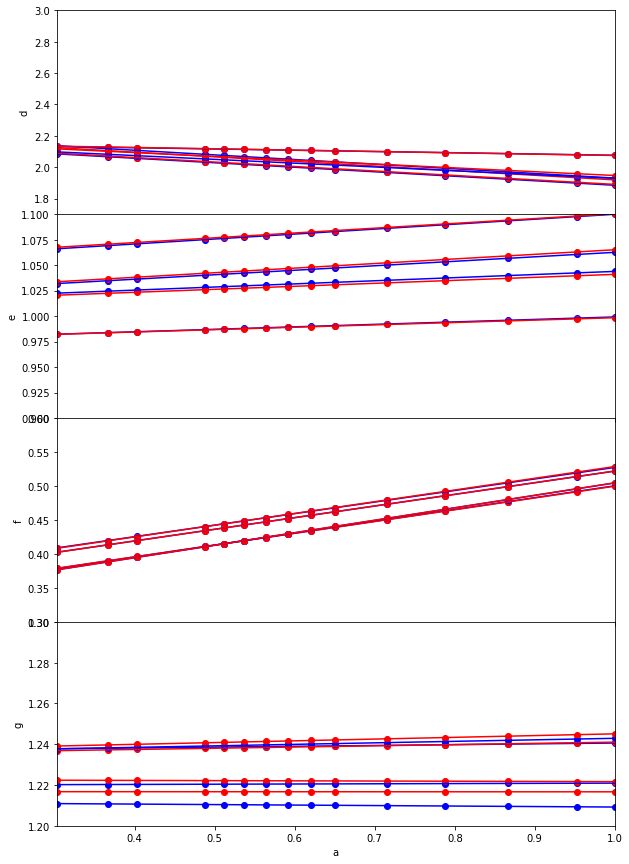

In [12]:

import matplotlib.pyplot as plt


fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(10,15), sharex=True)
wjat = ['Box_n50_0_1400', 'Box_n50_14_1400', 'Box_n50_33_1400', 'Box_n50_32_1400']
# wjat = [leave_out_box, 'Box98_1400']

# for box in [leave_out_box]:#, 'Box_n50_14_1400']:
# for box in [leave_out_box, 'Box98_1400', 'Box_n50_0_1400']:#, 'Box_n50_14_1400', 'Box_n50_33_1400', 'Box_n50_32_1400']:
for box in tqdm(wjat):
    curr_cosmo_vals = tuple(get_cosmo_vals(cosmo_params[box]))
    curr_ccl_cosmo = get_ccl_cosmology(curr_cosmo_vals)

    param_names = ['d','e','f','g']
    ndim = len(param_names)
    plt.subplots_adjust(wspace=0, hspace=0)

    params = {'d':[], 'e':[], 'f':[], 'g':[]}
    paramsEMU = {'d':[], 'e':[], 'f':[], 'g':[]}

    for a in a_list:
        R = 8 / (cosmo_params[box]['H0'] / 100)
        sigma8z = cosmo.sigmaR(R, a=a)
        EMU  = (Emulator.predict_params(cosmo_params[box], scaleToRedshift(a))) #, sigma8z))

        with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_params.pkl"%(box), "rb") as f:
            MLE_params = pickle.load(f)
            curr_params = list(MLE_params.values())
            paired_params = list(zip(curr_params, curr_params[1:]))[::2]

            param_at_z = {'d':-1, 'e':-1, 'f':-1, 'g':-1}

            for (p0,p1), key in zip(paired_params, param_at_z):
                param_at_z[key] = p(p0, p1, a)
            MLE_params = param_at_z

        for key in MLE_params:
            params[key] += [MLE_params[key]]
            paramsEMU[key] += [EMU[key]]


    for i, param in enumerate(params):
        aaaaa = 1
        axs[i].scatter(a_list, params[param], alpha=aaaaa, color='blue')
#         print(list(zip(a_list,params[param])))
#         print()
        axs[i].plot(a_list, params[param], alpha=aaaaa, color='blue')

        axs[i].scatter(a_list, paramsEMU[param], alpha=aaaaa, color='red')
        axs[i].plot(a_list, paramsEMU[param], alpha=aaaaa, color='red')

        axs[i].set_ylabel(param)
    #     axs[i].set_ylim([0,2])
        axs[i].set_xlim([min(a_list), 1])

axs[-1].set_xlabel('a')
# axs[0].set_ylim([0.25,.45])
# axs[1].set_ylim([0.29,.305])
# axs[2].set_ylim([1.4,1.8])
# axs[3].set_ylim([1.18, 1.2])
axs[0].set_ylim([1.7, 3.])
axs[1].set_ylim([0.9, 1.1])
axs[2].set_ylim([.3,.6])
axs[3].set_ylim([1.2,1.3])
# axs[0].set_title(box)

  7%|▋         | 1/15 [00:00<00:13,  1.02it/s]

[2.1162097439926297, -0.08028502176548288, 0.987102688450363, 0.024287519747148156, 0.4363584408531615, 0.17126132313423517, 1.2204005168112457, 0.0010557051753642959]


 20%|██        | 3/15 [00:01<00:03,  3.23it/s]

[2.1162097439926297, -0.08028502176548288, 0.987102688450363, 0.024287519747148156, 0.4363584408531615, 0.17126132313423517, 1.2204005168112457, 0.0010557051753642959]
[2.1162097439926297, -0.08028502176548288, 0.987102688450363, 0.024287519747148156, 0.4363584408531615, 0.17126132313423517, 1.2204005168112457, 0.0010557051753642959]


 33%|███▎      | 5/15 [00:01<00:01,  5.30it/s]

[2.1162097439926297, -0.08028502176548288, 0.987102688450363, 0.024287519747148156, 0.4363584408531615, 0.17126132313423517, 1.2204005168112457, 0.0010557051753642959]
[2.1162097439926297, -0.08028502176548288, 0.987102688450363, 0.024287519747148156, 0.4363584408531615, 0.17126132313423517, 1.2204005168112457, 0.0010557051753642959]


 47%|████▋     | 7/15 [00:01<00:01,  7.02it/s]

[2.1162097439926297, -0.08028502176548288, 0.987102688450363, 0.024287519747148156, 0.4363584408531615, 0.17126132313423517, 1.2204005168112457, 0.0010557051753642959]
[2.1162097439926297, -0.08028502176548288, 0.987102688450363, 0.024287519747148156, 0.4363584408531615, 0.17126132313423517, 1.2204005168112457, 0.0010557051753642959]


 60%|██████    | 9/15 [00:01<00:00,  8.32it/s]

[2.1162097439926297, -0.08028502176548288, 0.987102688450363, 0.024287519747148156, 0.4363584408531615, 0.17126132313423517, 1.2204005168112457, 0.0010557051753642959]
[2.1162097439926297, -0.08028502176548288, 0.987102688450363, 0.024287519747148156, 0.4363584408531615, 0.17126132313423517, 1.2204005168112457, 0.0010557051753642959]


 67%|██████▋   | 10/15 [00:02<00:00,  6.74it/s]

[2.1162097439926297, -0.08028502176548288, 0.987102688450363, 0.024287519747148156, 0.4363584408531615, 0.17126132313423517, 1.2204005168112457, 0.0010557051753642959]
[2.1162097439926297, -0.08028502176548288, 0.987102688450363, 0.024287519747148156, 0.4363584408531615, 0.17126132313423517, 1.2204005168112457, 0.0010557051753642959]
[2.1162097439926297, -0.08028502176548288, 0.987102688450363, 0.024287519747148156, 0.4363584408531615, 0.17126132313423517, 1.2204005168112457, 0.0010557051753642959]


100%|██████████| 15/15 [00:02<00:00,  6.05it/s]

[2.1162097439926297, -0.08028502176548288, 0.987102688450363, 0.024287519747148156, 0.4363584408531615, 0.17126132313423517, 1.2204005168112457, 0.0010557051753642959]
[2.1162097439926297, -0.08028502176548288, 0.987102688450363, 0.024287519747148156, 0.4363584408531615, 0.17126132313423517, 1.2204005168112457, 0.0010557051753642959]
[2.1162097439926297, -0.08028502176548288, 0.987102688450363, 0.024287519747148156, 0.4363584408531615, 0.17126132313423517, 1.2204005168112457, 0.0010557051753642959]


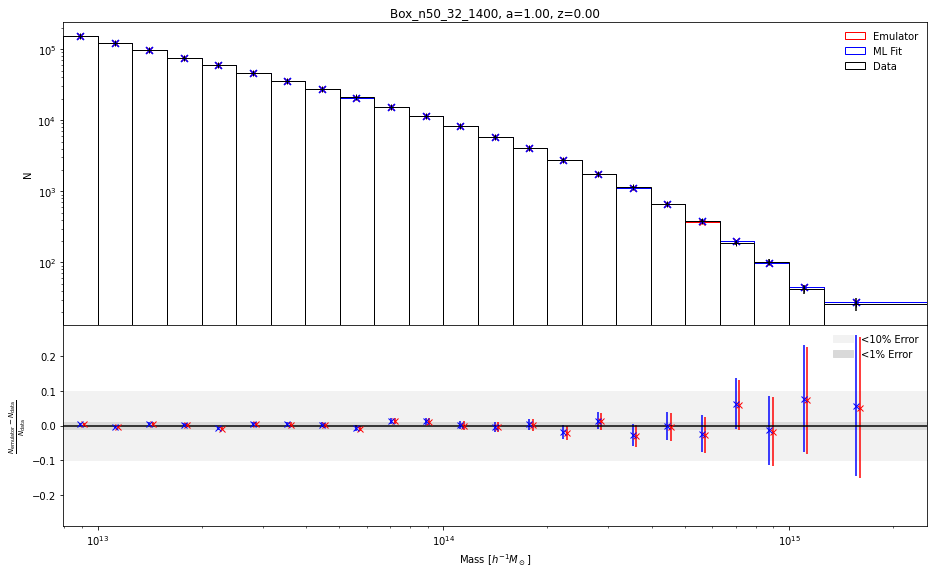

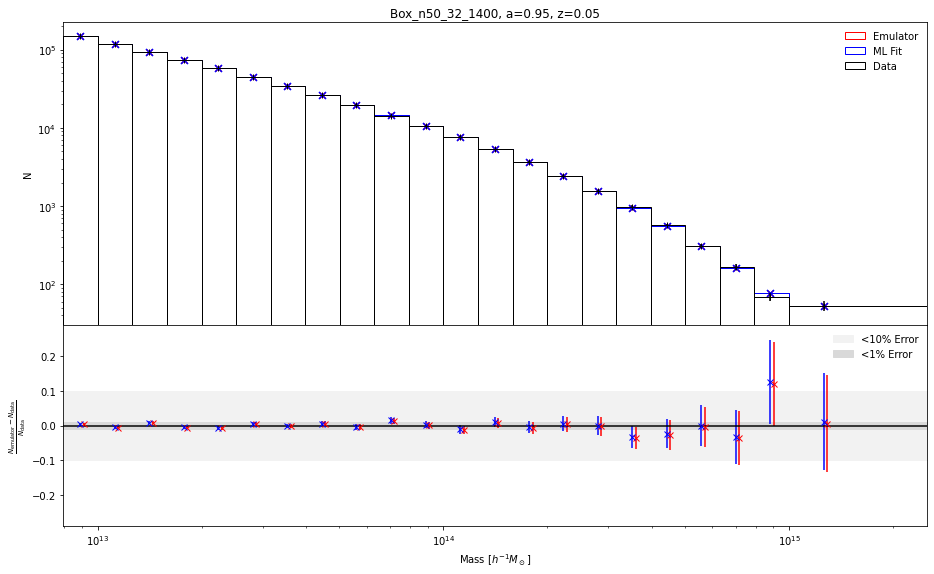

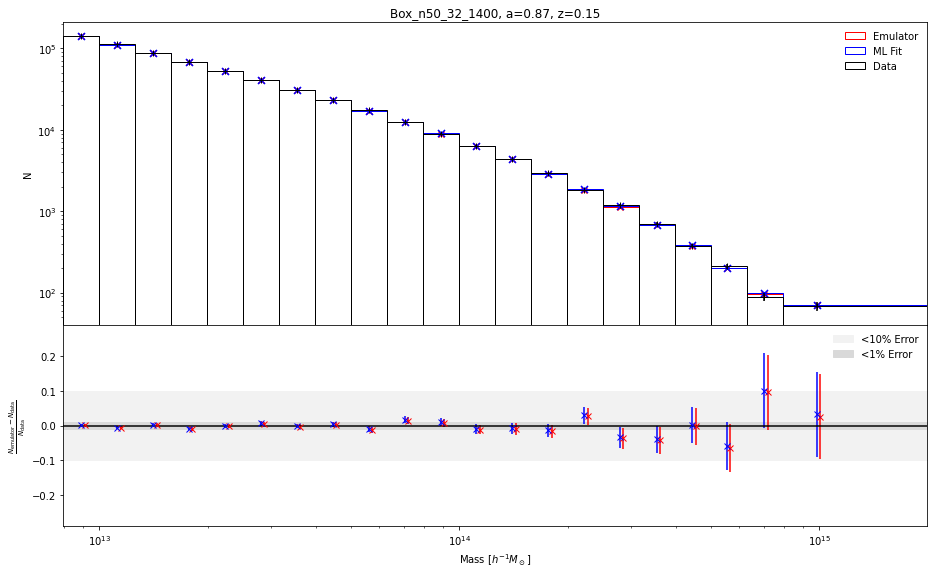

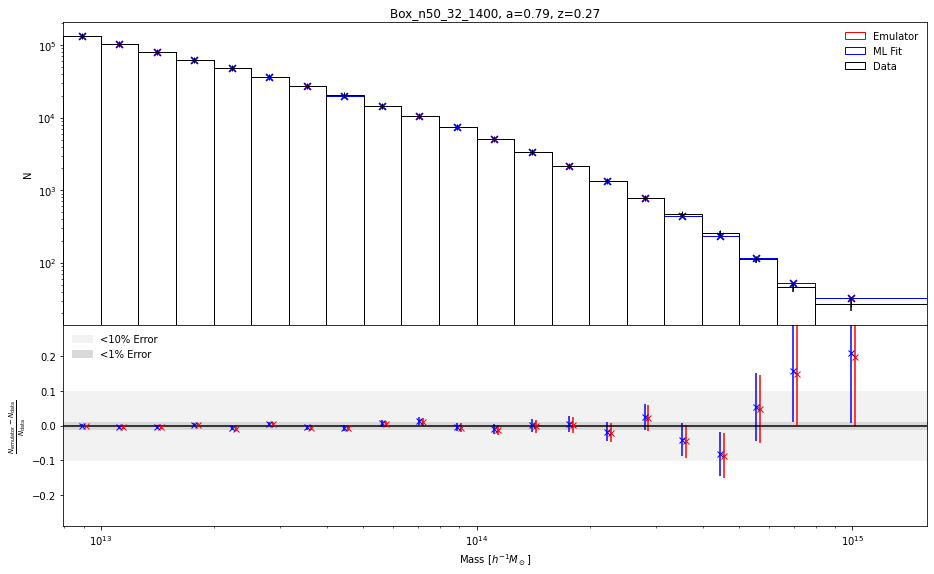

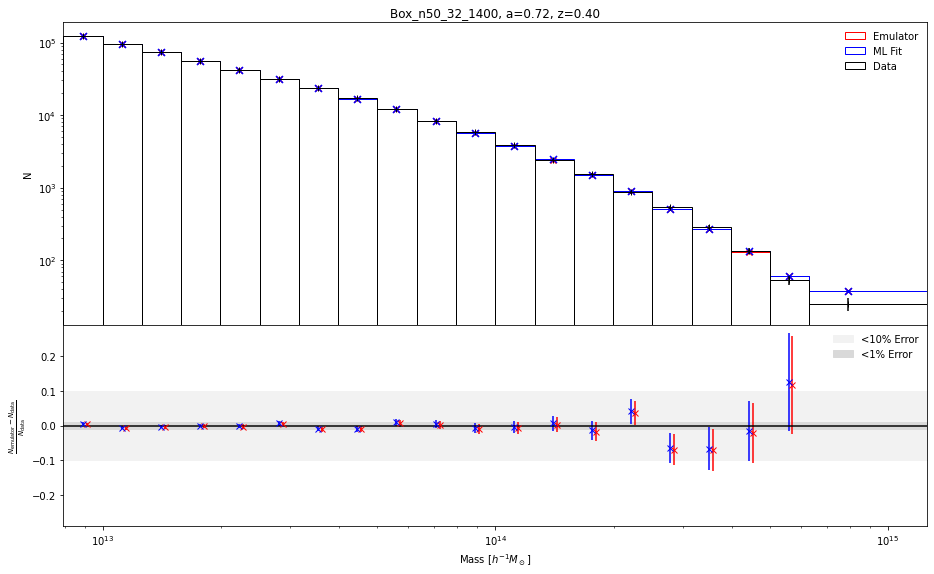

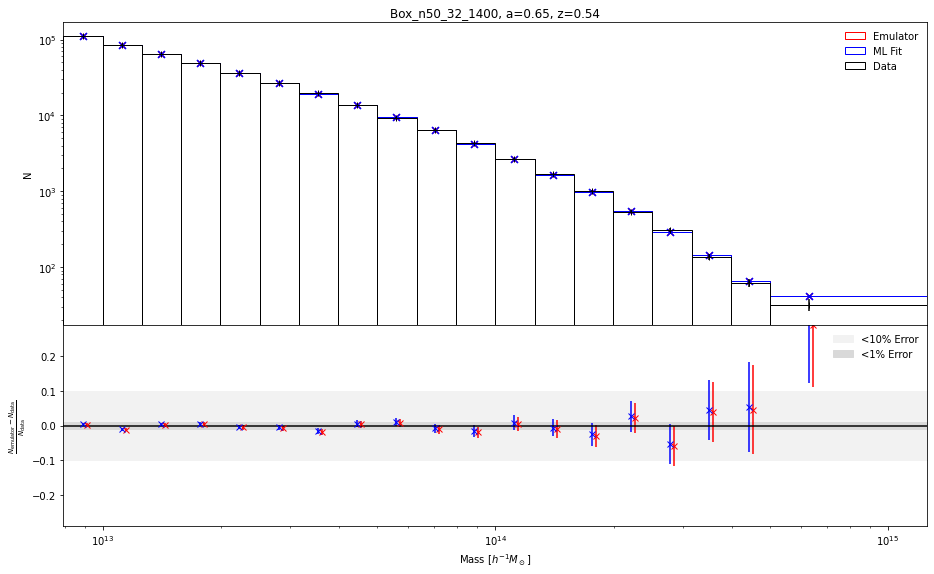

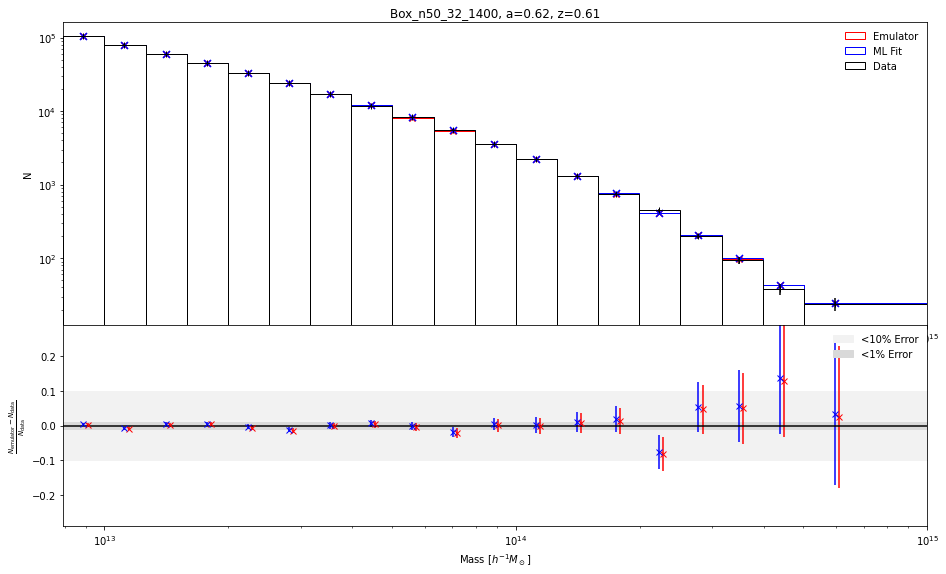

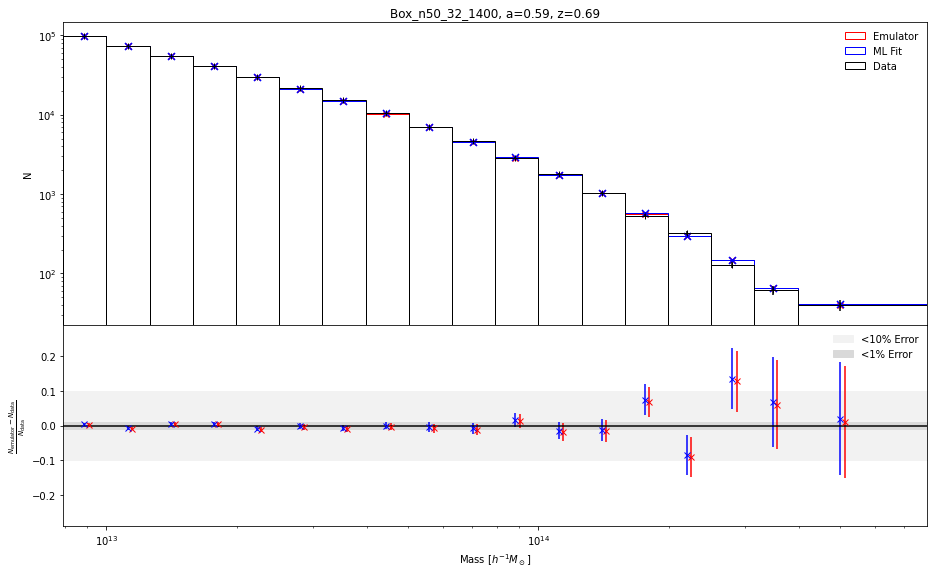

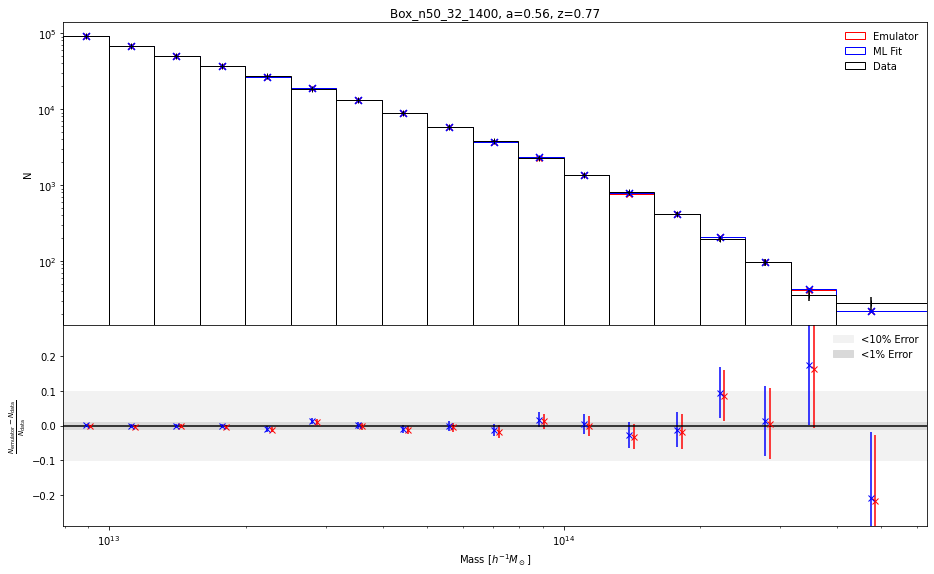

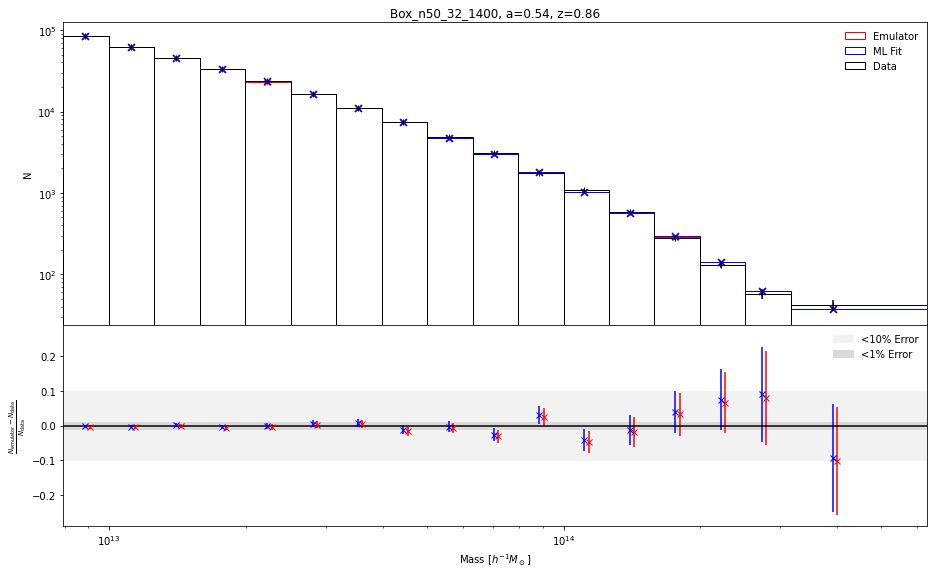

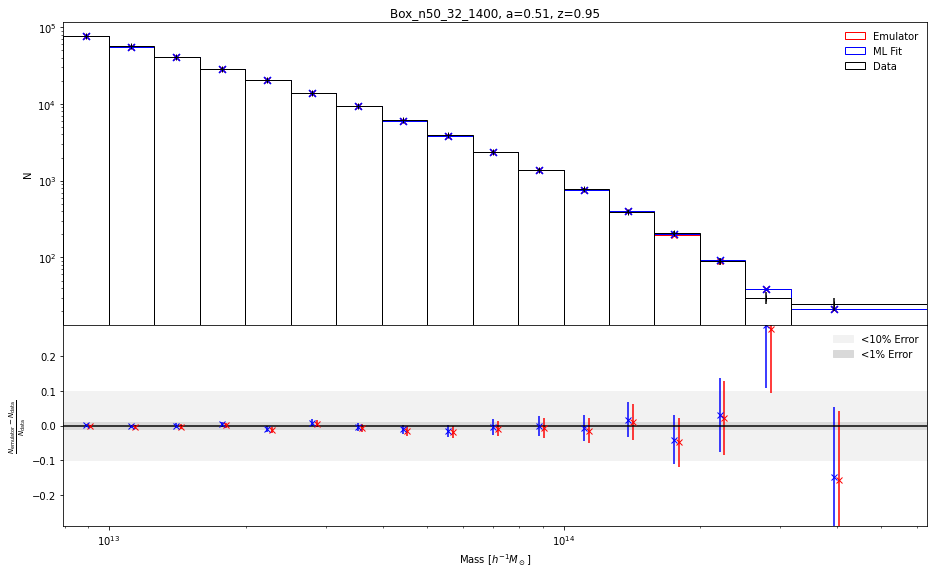

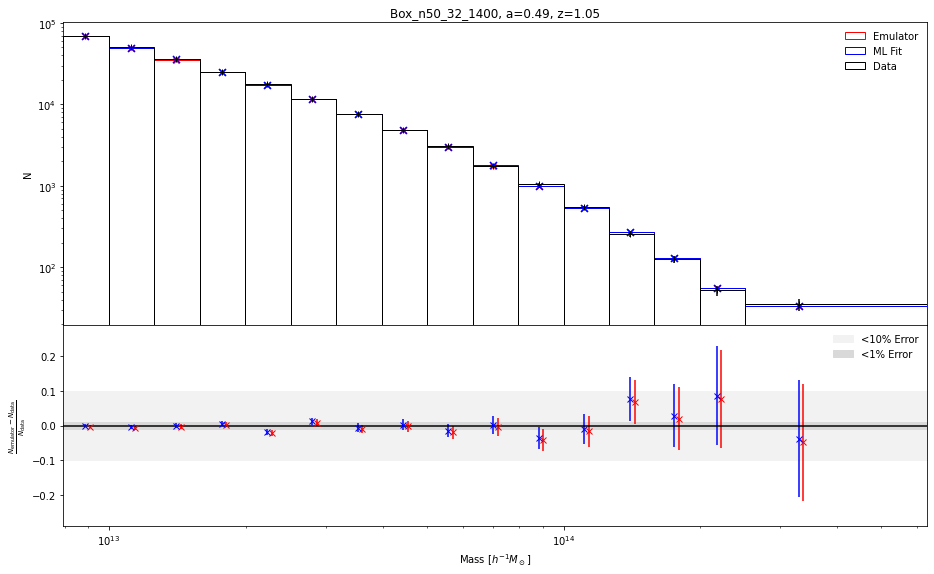

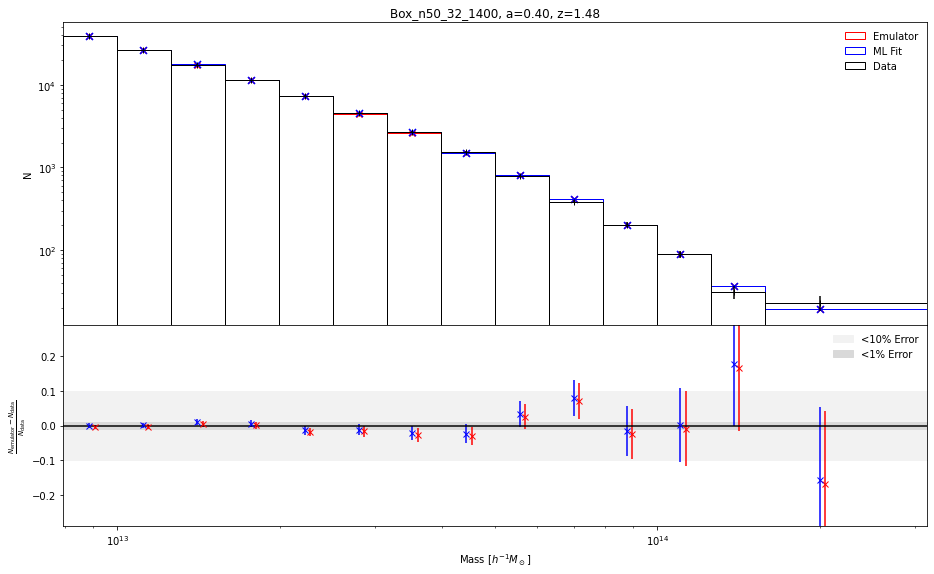

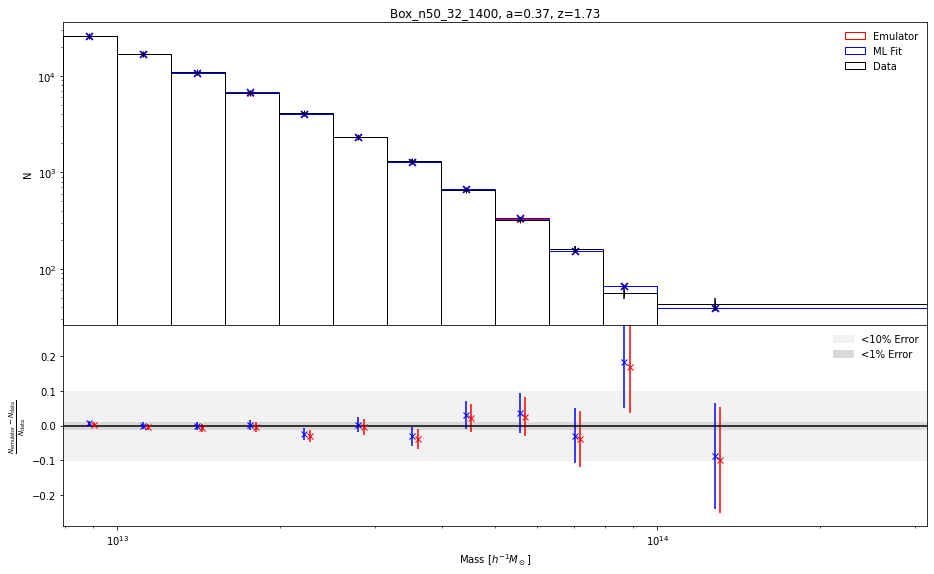

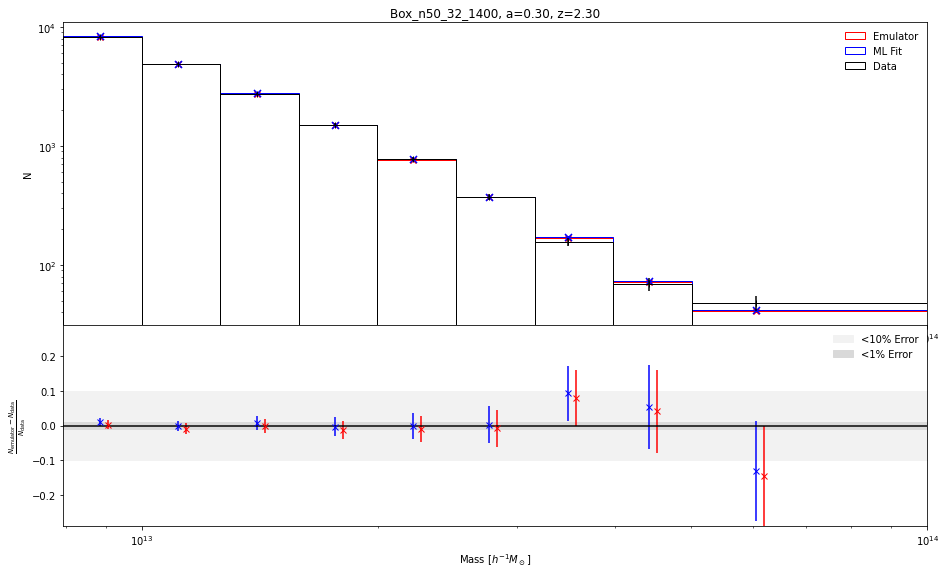

In [13]:
box = 'Box_n50_32_1400'

# from aemulusnu_massfunction.massfunction import *

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

N_data = {}
M_data = {}
aux_data = {}

vol = -1 #Mpc^3/h^3
Mpart = -1

for a in tqdm(a_list):
#     if(a != 1): #TEST
#         continue
    c_data = NvMs[a]

    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]
M_numerics = np.logspace(np.log10(100*Mpart), 16, 50)

jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()

jack_covs = {a:jackknife[a][1] for a in N_data}

# Compute the weighted covariance matrix incorporating jackknife and poisson
weighted_cov = {a: jack_covs[a] for a in jack_covs}

param_names = ['d','e','f','g']


true_params = {}

ccl_cosmo = get_ccl_cosmology(tuple(get_cosmo_vals(cosmo_params[box])))

h = cosmo_params[box]['H0']/100


for a in tqdm(a_list):
    yerr = np.sqrt(np.diagonal(weighted_cov[a]))
    fig1 = plt.figure(figsize =(12, 7))

    axs=[fig1.add_axes((0.0,0.4,1,.6)), fig1.add_axes((0.0,0.0,1,.4))]
    plt.subplots_adjust(wspace=0, hspace=0)
    c_data = NvMs[a]

    Ms = M_data[a]
    N = N_data[a]
    edge_pairs = c_data['edge_pairs']

    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]

    #shade in 1% and 10% error region
    edges = np.array(edges)
    
    

    y1 = 0.1*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.1*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    c_Ms = np.append(Ms, edges[-1])
    c_Ms = np.append(edges[0], c_Ms)
    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

    y1 = 0.01*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.01*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


    dM = np.array([edges[1]-edges[0] for edges in edge_pairs])


    #Emulator 
    f_dNdM_MCMC =  lambda M:Emulator(ccl_cosmo, M/h, a)*vol/(h**3 * M * np.log(10)) # h / Msun
    tinker_eval_MCMC = np.array([quad(f_dNdM_MCMC, edge[0],  edge[1], epsabs=0, epsrel=1e-5)[0] for edge in edge_pairs])

    axs[0].scatter(Ms, tinker_eval_MCMC, marker='x', c='red')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges),
               align='edge', fill=False, ec='red', label='Emulator')
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_NvMemulator_loo_output.pkl"%(box, a), "wb") as f:
        pickle.dump({'Ms':Ms, 'tinker_eval':tinker_eval_MCMC, 'N':N, 'edges':edges}, f)

    tmp = np.array([c_tmp*10**(0.01)-c_tmp for c_tmp in Ms])
    axs[1].errorbar(Ms + tmp, (tinker_eval_MCMC-N)/N, yerr/N, fmt='x', color='red')

    #ML Fit

    mass_function = MassFuncAemulusNu_fitting_all_snapshot()
    
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_params.pkl"%(box), "rb") as f:
        MLE_params = pickle.load(f)
        print(list(MLE_params.values()))
        mass_function.set_params(list(MLE_params.values()))


    f_dNdM_MCMC =  lambda M:mass_function(ccl_cosmo, M/h, a)*vol/(h**3 * M * np.log(10)) # h / Msun
    tinker_eval_MCMC = np.array([quad(f_dNdM_MCMC, edge[0],  edge[1], epsabs=0, epsrel=1e-5)[0] for edge in edge_pairs])
    axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), 
               align='edge', fill=False, ec='blue', label='ML Fit')
    axs[1].errorbar(Ms, (tinker_eval_MCMC-N)/N, yerr/N, fmt='x', color='blue')



    #Data
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
           align='edge', fill=False, ec='black', label='Data')
    axs[0].errorbar(Ms, N, yerr, fmt='+', c='black')

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    axs[1].set_xscale('log')
    # axs[1].set_yscale('lin', linthresh=1e-2)    
    axs[1].legend(frameon=False)
    axs[1].axhline(0, c='black')
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'$\frac{N_{\rm emulator}-N_{\rm data}}{N_{\rm data}} $')
    axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, scaleToRedshift(a)))

    left = np.ceil(np.log10(200*Mpart) * 10) / 10
    axs[0].set_xlim((10**left, np.max(edges)))
    axs[1].set_xlim((10**left, np.max(edges)))
    axs[1].set_ylim((-.29, .29))
    axs[1].set_yticks([-.2, -.1, 0, .1, .2])

#     plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/emulator/%s_emufit_%.2f.pdf'%(box, a), bbox_inches='tight')